## 라이브러리 불러오기

In [1]:
import sys
import pandas as pd
import numpy as np

import optuna  # 파라미터 튜닝
import shap
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor

from pycaret.regression import * 
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, mean_absolute_error

from scipy import stats
from scipy.stats import norm, skew

from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns

## Experiment 4 
- **실험 내용 : 5개의 데이터셋을 모두 다른 비율로 설정 후 모델링**

In [2]:
train = pd.read_csv('C:/Users/cdbre/Desktop/MyLife/DACON/data/teacher_train.csv')
real_test = pd.read_csv('C:/Users/cdbre/Desktop/MyLife/DACON/data/test_al.csv')

In [3]:
# AL 추가
train = train[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR','AL','Y_LABEL','Label','Score_0']]
real_test = real_test[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR','AL']]

In [4]:
# Label 기준으로 split
train, test = train_test_split(train, stratify=train.Label, test_size=0.2, random_state=42)

In [5]:
# YEAR 칼럼 LabelEncoding
le = LabelEncoder()
train.YEAR = le.fit_transform(train.YEAR)
test.YEAR = le.transform(test.YEAR)
real_test.YEAR = le.transform(real_test.YEAR)

In [6]:
numeric_feats = []

for col in train.columns:
    if col not in ['YEAR','Score_0','Label','Y_LABEL']:
        numeric_feats.append(col)

# Check the skew of all numerical features
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



Skew
CR           53.601677
ANONYMOUS_1  32.396129
FE           22.304026
CU           19.550846
NI           17.997284
AL           16.636099
V40          14.774742
PQINDEX      10.164341
ANONYMOUS_2   8.101399
MO            2.853648
ZN            0.228219

In [7]:
skewness = skewness[abs(skewness.Skew) > 0.75]

skewed_features = skewness.index

# log 변환
for col in skewed_features:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])
    real_test[col] = np.log1p(real_test[col])

In [8]:
print(train.Y_LABEL.value_counts())
print(test.Y_LABEL.value_counts())
print(train.Label.value_counts())
print(test.Label.value_counts())

0    10325
1      951
Name: Y_LABEL, dtype: int64
0    2567
1     252
Name: Y_LABEL, dtype: int64
0    10526
1      750
Name: Label, dtype: int64
0    2631
1     188
Name: Label, dtype: int64


## Labeling, Metric

In [9]:
def labeling(prob, threshold=0.5):
    return 0 if prob > threshold else 1

def competition_metric(pred, org):
    return round(f1_score(pred, org),4), round(f1_score(pred, org, average='macro'),4)

## DownSample Dataset

In [10]:
train0_index_list = []
train0 = train[train.Score_0 >= 0.5].reset_index(drop=True)
train1 = train[train.Score_0 <= 0.5].reset_index(drop=True)

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

for index, train0_index in kf.split(train0):
    train0_index_list.append(train0_index)

In [11]:
train01 = train0[train0.index.isin(train0_index_list[0])]
train02 = train0[train0.index.isin(train0_index_list[1])]
train03 = train0[train0.index.isin(train0_index_list[2])]
train04 = train0[train0.index.isin(train0_index_list[3])]
train05 = train0[train0.index.isin(train0_index_list[4])]

In [12]:
train_df1 = pd.concat([train01, train1], axis=0).reset_index(drop=True)
train_df2 = pd.concat([train02, train1], axis=0).reset_index(drop=True)
train_df3 = pd.concat([train03, train1], axis=0).reset_index(drop=True)
train_df4 = pd.concat([train04, train1], axis=0).reset_index(drop=True)
train_df5 = pd.concat([train05, train1], axis=0).reset_index(drop=True)

In [13]:
X_train1 = train_df1[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train1 = train_df1[['Label','Score_0']]

X_train2 = train_df2[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train2 = train_df2[['Label','Score_0']]

X_train3 = train_df3[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train3 = train_df3[['Label','Score_0']]

X_train4 = train_df4[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train4 = train_df4[['Label','Score_0']]

X_train5 = train_df5[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train5 = train_df5[['Label','Score_0']]

X_test = test[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_test = test[['Y_LABEL', 'Score_0']]

In [14]:
print(X_train1.shape, y_train1.shape)
print(X_train2.shape, y_train2.shape)
print(X_train3.shape, y_train3.shape)
print(X_train4.shape, y_train4.shape)
print(X_train5.shape, y_train5.shape)

(2856, 11) (2856, 2)
(2855, 11) (2855, 2)
(2855, 11) (2855, 2)
(2855, 11) (2855, 2)
(2855, 11) (2855, 2)


## Dataset 1

### Decision Tree

In [15]:
def objectiveDT(trial, X, y):
    
    param = {
    'criterion': trial.suggest_categorical('criterion',['mae']),
    'splitter': trial.suggest_categorical('splitter',['best','random']),
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = DecisionTreeRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [16]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train1, y_train1), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-11 18:01:41,910] A new study created in memory with name: no-name-b376d11d-398d-40bf-bf48-37721b8b8e6a
[I 2022-12-11 18:01:43,782] Trial 0 finished with value: 0.24938825027861805 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 10, 'max_leaf_nodes': 430}. Best is trial 0 with value: 0.24938825027861805.
[I 2022-12-11 18:01:44,495] Trial 1 finished with value: 0.2419963409488935 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 8, 'max_leaf_nodes': 152}. Best is trial 1 with value: 0.2419963409488935.
[I 2022-12-11 18:01:46,365] Trial 2 finished with value: 0.2437079494935887 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 9, 'max_leaf_nodes': 584}. Best is trial 1 with value: 0.2419963409488935.
[I 2022-12-11 18:01:47,171] Trial 3 finished with value: 0.24905342369539393 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 11, 'max_leaf_nodes': 446}. Best is trial 1 with value: 0.24199634094

[I 2022-12-11 18:02:23,655] Trial 34 finished with value: 0.23310964826766933 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 4, 'max_leaf_nodes': 379}. Best is trial 19 with value: 0.22938643381137247.
[I 2022-12-11 18:02:25,049] Trial 35 finished with value: 0.23308960938361115 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 5, 'max_leaf_nodes': 205}. Best is trial 19 with value: 0.22938643381137247.
[I 2022-12-11 18:02:25,759] Trial 36 finished with value: 0.23223941471838144 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 7, 'max_leaf_nodes': 474}. Best is trial 19 with value: 0.22938643381137247.
[I 2022-12-11 18:02:26,692] Trial 37 finished with value: 0.22940608146669444 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 169}. Best is trial 19 with value: 0.22938643381137247.
[I 2022-12-11 18:02:27,559] Trial 38 finished with value: 0.24668285623308392 and parameters: {'cr

[I 2022-12-11 18:03:02,943] Trial 69 finished with value: 0.26122797034401674 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 13, 'max_leaf_nodes': 607}. Best is trial 19 with value: 0.22938643381137247.
[I 2022-12-11 18:03:04,713] Trial 70 finished with value: 0.24242577201694976 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 8, 'max_leaf_nodes': 170}. Best is trial 19 with value: 0.22938643381137247.
[I 2022-12-11 18:03:05,668] Trial 71 finished with value: 0.22940608146669444 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 537}. Best is trial 19 with value: 0.22938643381137247.
[I 2022-12-11 18:03:06,657] Trial 72 finished with value: 0.22940608146669444 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 63}. Best is trial 19 with value: 0.22938643381137247.
[I 2022-12-11 18:03:07,666] Trial 73 finished with value: 0.22940608146669444 and parameters: {'crit

study.best_params: 0.22938643381137247
Number of finished trials: 100
Best trial: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 13, 'max_leaf_nodes': 3}
study.best_params: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 13, 'max_leaf_nodes': 3}


In [17]:
param_dt = studyDT.best_params

clf_dt1 = DecisionTreeRegressor(**param_dt, random_state=42)

In [18]:
clf_dt1.fit(X_train1, y_train1.Score_0)

pred_test_dt = clf_dt1.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.0892
F1 Score : 0.144
Macro F1 Score : 0.5415 

[[2471  225]
 [  96   27]]


In [19]:
optuna.visualization.plot_param_importances(studyDT)

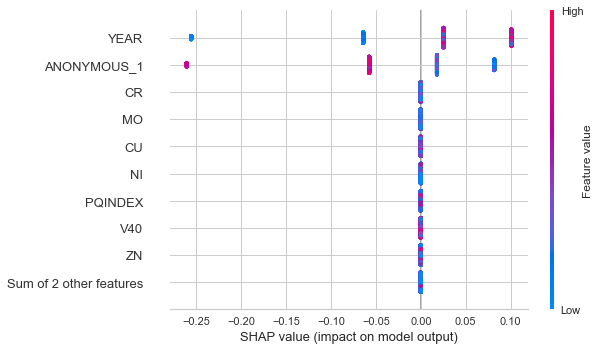

In [20]:
explainer_dt = shap.Explainer(clf_dt1)
shap_values_dt = explainer_dt(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [21]:
fi_dt = pd.DataFrame(clf_dt1.feature_importances_, index=X_train1.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
ANONYMOUS_1               0.758604
YEAR                      0.241396
FE                        0.000000
ANONYMOUS_2               0.000000
ZN                        0.000000
V40                       0.000000
PQINDEX                   0.000000
NI                        0.000000
CU                        0.000000
MO                        0.000000
CR                        0.000000

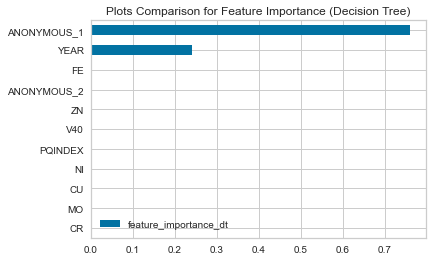

In [22]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [23]:
def objectiveSVR(trial, X, y):
    
    param = {
        'C': trial.suggest_loguniform('C', 0.3, 10.0),
        'degree': trial.suggest_int('degree', 2, 7),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 0.01),
        'epsilon': trial.suggest_float('epsilon', 0.05, 0.5),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = SVR(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [24]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train1, y_train1), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-11 18:03:40,503] A new study created in memory with name: no-name-c1deb96b-d057-49c6-a624-d1abeb9b061e
[I 2022-12-11 18:03:42,725] Trial 0 finished with value: 0.2822333957704314 and parameters: {'C': 0.3590385704410674, 'degree': 2, 'gamma': 0.009603118283495351, 'epsilon': 0.12377838821055398}. Best is trial 0 with value: 0.2822333957704314.
[I 2022-12-11 18:03:44,560] Trial 1 finished with value: 0.37938961850870384 and parameters: {'C': 3.411825247861948, 'degree': 4, 'gamma': 0.0020207197071342407, 'epsilon': 0.365892563065811}. Best is trial 0 with value: 0.2822333957704314.
[I 2022-12-11 18:03:46,895] Trial 2 finished with value: 0.25896508711444755 and parameters: {'C': 1.1828477936858235, 'degree': 4, 'gamma': 0.003562317048928139, 'epsilon': 0.058251111570457224}. Best is trial 2 with value: 0.25896508711444755.
[I 2022-12-11 18:03:48,907] Trial 3 finished with value: 0.27315930629714 and parameters: {'C': 0.3715117480444264, 'degree': 7, 'gamma': 0.004291455931584

[I 2022-12-11 18:04:46,169] Trial 32 finished with value: 0.24760847790281124 and parameters: {'C': 0.3056148370828132, 'degree': 3, 'gamma': 0.0018412800978725031, 'epsilon': 0.05139533842809112}. Best is trial 11 with value: 0.24756515984160524.
[I 2022-12-11 18:04:48,067] Trial 33 finished with value: 0.2699211627115174 and parameters: {'C': 0.32702923424142044, 'degree': 4, 'gamma': 0.0024023065775641904, 'epsilon': 0.10604477019447847}. Best is trial 11 with value: 0.24756515984160524.
[I 2022-12-11 18:04:50,061] Trial 34 finished with value: 0.24775001240851552 and parameters: {'C': 0.4474735206466921, 'degree': 3, 'gamma': 0.0019383402556350262, 'epsilon': 0.050702249693506}. Best is trial 11 with value: 0.24756515984160524.
[I 2022-12-11 18:04:51,862] Trial 35 finished with value: 0.26142349211397875 and parameters: {'C': 0.43125550265482093, 'degree': 4, 'gamma': 0.0013748848603036368, 'epsilon': 0.0881789016765378}. Best is trial 11 with value: 0.24756515984160524.
[I 2022-12

[I 2022-12-11 18:05:48,813] Trial 64 finished with value: 0.296281035535941 and parameters: {'C': 0.9243326974561444, 'degree': 3, 'gamma': 0.0018702205159260112, 'epsilon': 0.16754109260722636}. Best is trial 46 with value: 0.24755269816645797.
[I 2022-12-11 18:05:50,880] Trial 65 finished with value: 0.2557267176640923 and parameters: {'C': 0.814994993265973, 'degree': 3, 'gamma': 0.002103922550438173, 'epsilon': 0.06743738887840686}. Best is trial 46 with value: 0.24755269816645797.
[I 2022-12-11 18:05:53,601] Trial 66 finished with value: 0.2768174762960755 and parameters: {'C': 9.121420980679643, 'degree': 5, 'gamma': 0.0016941734289826003, 'epsilon': 0.1001489207306254}. Best is trial 46 with value: 0.24755269816645797.
[I 2022-12-11 18:05:55,778] Trial 67 finished with value: 0.25333459476275655 and parameters: {'C': 2.2662431958435296, 'degree': 4, 'gamma': 0.0011723898767017297, 'epsilon': 0.06169797423976858}. Best is trial 46 with value: 0.24755269816645797.
[I 2022-12-11 18

[I 2022-12-11 18:06:55,286] Trial 96 finished with value: 0.2602379011856836 and parameters: {'C': 0.6254504162334731, 'degree': 2, 'gamma': 0.0012453436302057336, 'epsilon': 0.08559126319714355}. Best is trial 92 with value: 0.2469742792246905.
[I 2022-12-11 18:06:57,270] Trial 97 finished with value: 0.2506489138276332 and parameters: {'C': 0.35940798530949125, 'degree': 2, 'gamma': 0.0010900915599663407, 'epsilon': 0.060559022941178146}. Best is trial 92 with value: 0.2469742792246905.
[I 2022-12-11 18:06:59,128] Trial 98 finished with value: 0.2687430755941206 and parameters: {'C': 0.4601813070374408, 'degree': 5, 'gamma': 0.0010014067870189579, 'epsilon': 0.10590107231987893}. Best is trial 92 with value: 0.2469742792246905.
[I 2022-12-11 18:07:01,232] Trial 99 finished with value: 0.25688279132756586 and parameters: {'C': 0.39551105194557273, 'degree': 2, 'gamma': 0.0013470707266107745, 'epsilon': 0.07699668709245139}. Best is trial 92 with value: 0.2469742792246905.


study.best_params: 0.2469742792246905
Number of finished trials: 100
Best trial: {'C': 0.4950538093025208, 'degree': 2, 'gamma': 0.0010919603562300655, 'epsilon': 0.05050421930135487}
study.best_params: {'C': 0.4950538093025208, 'degree': 2, 'gamma': 0.0010919603562300655, 'epsilon': 0.05050421930135487}


In [25]:
param_svr = studySVR.best_params

clf_svr1 = SVR(**param_svr)

In [26]:
clf_svr1.fit(X_train1, y_train1.Score_0)

pred_test_svr = clf_svr1.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.1114
F1 Score : 0.0215
Macro F1 Score : 0.4853 

[[2543  249]
 [  24    3]]


In [27]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [28]:
def objectiveRF(trial, X, y):

    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),  # max_depth 제한
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),  # n_estimators 제한
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = RandomForestRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [29]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train1, y_train1), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-11 18:07:04,504] A new study created in memory with name: no-name-16c0680d-b26d-46e4-ad8c-7c23435c0c16
[I 2022-12-11 18:07:18,950] Trial 0 finished with value: 0.29240230179121574 and parameters: {'max_depth': 9, 'max_leaf_nodes': 549, 'n_estimators': 354}. Best is trial 0 with value: 0.29240230179121574.
[I 2022-12-11 18:07:30,223] Trial 1 finished with value: 0.2932253926235978 and parameters: {'max_depth': 11, 'max_leaf_nodes': 799, 'n_estimators': 220}. Best is trial 0 with value: 0.29240230179121574.
[I 2022-12-11 18:07:31,144] Trial 2 finished with value: 0.30296425471324573 and parameters: {'max_depth': 3, 'max_leaf_nodes': 405, 'n_estimators': 50}. Best is trial 0 with value: 0.29240230179121574.
[I 2022-12-11 18:07:42,414] Trial 3 finished with value: 0.2961742339053649 and parameters: {'max_depth': 5, 'max_leaf_nodes': 783, 'n_estimators': 444}. Best is trial 0 with value: 0.29240230179121574.
[I 2022-12-11 18:07:47,199] Trial 4 finished with value: 0.2965770022513

[I 2022-12-11 18:12:03,095] Trial 38 finished with value: 0.2965328618638191 and parameters: {'max_depth': 12, 'max_leaf_nodes': 21, 'n_estimators': 232}. Best is trial 23 with value: 0.29034103861188437.
[I 2022-12-11 18:12:11,585] Trial 39 finished with value: 0.2927409727931992 and parameters: {'max_depth': 9, 'max_leaf_nodes': 279, 'n_estimators': 203}. Best is trial 23 with value: 0.29034103861188437.
[I 2022-12-11 18:12:18,066] Trial 40 finished with value: 0.2923913904065282 and parameters: {'max_depth': 12, 'max_leaf_nodes': 56, 'n_estimators': 172}. Best is trial 23 with value: 0.29034103861188437.
[I 2022-12-11 18:12:27,076] Trial 41 finished with value: 0.29039976030075265 and parameters: {'max_depth': 13, 'max_leaf_nodes': 123, 'n_estimators': 194}. Best is trial 23 with value: 0.29034103861188437.
[I 2022-12-11 18:12:39,767] Trial 42 finished with value: 0.29029714223052205 and parameters: {'max_depth': 13, 'max_leaf_nodes': 127, 'n_estimators': 255}. Best is trial 42 with

[I 2022-12-11 18:18:18,990] Trial 76 finished with value: 0.30310055999742314 and parameters: {'max_depth': 3, 'max_leaf_nodes': 205, 'n_estimators': 204}. Best is trial 54 with value: 0.2900554771280105.
[I 2022-12-11 18:18:25,577] Trial 77 finished with value: 0.2932110315863668 and parameters: {'max_depth': 13, 'max_leaf_nodes': 265, 'n_estimators': 142}. Best is trial 54 with value: 0.2900554771280105.
[I 2022-12-11 18:18:31,869] Trial 78 finished with value: 0.29035178931037947 and parameters: {'max_depth': 12, 'max_leaf_nodes': 145, 'n_estimators': 180}. Best is trial 54 with value: 0.2900554771280105.
[I 2022-12-11 18:18:36,345] Trial 79 finished with value: 0.29231718488023656 and parameters: {'max_depth': 11, 'max_leaf_nodes': 179, 'n_estimators': 117}. Best is trial 54 with value: 0.2900554771280105.
[I 2022-12-11 18:18:40,874] Trial 80 finished with value: 0.29336527602468887 and parameters: {'max_depth': 10, 'max_leaf_nodes': 44, 'n_estimators': 177}. Best is trial 54 with 

study.best_params: 0.2900554771280105
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 138, 'n_estimators': 173}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 138, 'n_estimators': 173}


In [30]:
param_rf = studyRF.best_params

clf_rf1 = RandomForestRegressor(**param_rf, random_state=42)

In [31]:
clf_rf1.fit(X_train1, y_train1.Score_0)

pred_test_rf = clf_rf1.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.2151
F1 Score : 0.2247
Macro F1 Score : 0.571 

[[2337  191]
 [ 230   61]]


In [32]:
optuna.visualization.plot_param_importances(studyRF)

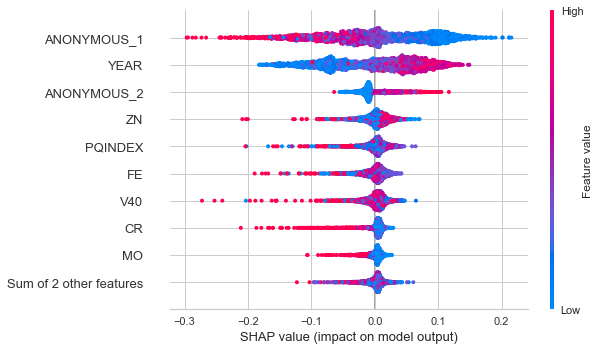

In [33]:
explainer_rf = shap.Explainer(clf_rf1)
shap_values_rf = explainer_rf(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [34]:
fi_rf = pd.DataFrame(clf_rf1.feature_importances_, index=X_train1.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.211125
YEAR                      0.118538
V40                       0.116949
ZN                        0.110829
FE                        0.103471
PQINDEX                   0.102785
CU                        0.070431
CR                        0.051801
MO                        0.047251
ANONYMOUS_2               0.044638
NI                        0.022182

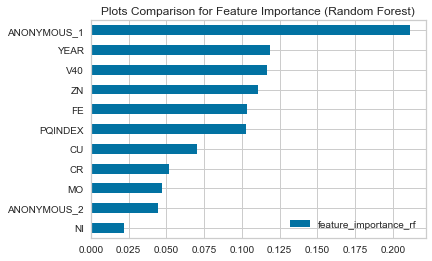

In [35]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [36]:
def objectiveXGB(trial, X, y):

    param = {
    'verbosity':1,
    'objective': trial.suggest_categorical('objective',['reg:squarederror']),
    'max_depth':trial.suggest_int('max_depth',3,13),  # 데이터 수가 적어 3~13으로 제한
    'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'subsample':trial.suggest_loguniform('subsample',0.7,1),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 300 ),
    'alpha': trial.suggest_loguniform( 'alpha', 1e-3, 10.0),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [37]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train1, y_train1), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-11 18:21:27,328] A new study created in memory with name: no-name-9ce27aa7-f316-45f4-a76c-8516faeeeeb6
[I 2022-12-11 18:21:27,766] Trial 0 finished with value: 0.4444342324225687 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 1.0605036481613475e-08, 'n_estimators': 441, 'subsample': 0.9752401656805578, 'min_child_weight': 67, 'alpha': 0.06445718265124005}. Best is trial 0 with value: 0.4444342324225687.
[I 2022-12-11 18:21:28,991] Trial 1 finished with value: 0.44443380359287027 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 7.485965381497567e-08, 'n_estimators': 87, 'subsample': 0.7165616858762065, 'min_child_weight': 102, 'alpha': 0.03558867314397784}. Best is trial 1 with value: 0.44443380359287027.
[I 2022-12-11 18:21:31,002] Trial 2 finished with value: 0.3769292015729911 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.003959184449754137, 'n_estimators': 165, '

[I 2022-12-11 18:22:45,102] Trial 23 finished with value: 0.3064064653924245 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.00853966804605389, 'n_estimators': 456, 'subsample': 0.9444186305864233, 'min_child_weight': 205, 'alpha': 0.20856330107914592}. Best is trial 17 with value: 0.3041755993504169.
[I 2022-12-11 18:22:50,828] Trial 24 finished with value: 0.37921112108402444 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.0013526207479799325, 'n_estimators': 463, 'subsample': 0.9526892387903698, 'min_child_weight': 215, 'alpha': 0.18614177668912865}. Best is trial 17 with value: 0.3041755993504169.
[I 2022-12-11 18:22:57,452] Trial 25 finished with value: 0.43536576392111537 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.00013357677240871928, 'n_estimators': 500, 'subsample': 0.936874162796824, 'min_child_weight': 202, 'alpha': 0.018719846208169005}. Best is trial 17 with 

[I 2022-12-11 18:25:11,803] Trial 47 finished with value: 0.4091438636855961 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.0006807298175762063, 'n_estimators': 423, 'subsample': 0.8626792412418148, 'min_child_weight': 74, 'alpha': 1.5603826831280514}. Best is trial 39 with value: 0.3025775800918516.
[I 2022-12-11 18:25:16,771] Trial 48 finished with value: 0.32257251959116645 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.005093508377900402, 'n_estimators': 452, 'subsample': 0.8099935859431769, 'min_child_weight': 175, 'alpha': 6.282680004221666}. Best is trial 39 with value: 0.3025775800918516.
[I 2022-12-11 18:25:27,878] Trial 49 finished with value: 0.4439511754673623 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 6.6878828379631e-06, 'n_estimators': 482, 'subsample': 0.9870848245725186, 'min_child_weight': 16, 'alpha': 0.0019110725263746166}. Best is trial 39 with valu

[I 2022-12-11 18:27:27,536] Trial 71 finished with value: 0.30927921743936093 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.009022624593958965, 'n_estimators': 424, 'subsample': 0.8925834189318014, 'min_child_weight': 264, 'alpha': 3.029237820615192}. Best is trial 39 with value: 0.3025775800918516.
[I 2022-12-11 18:27:31,343] Trial 72 finished with value: 0.3218744053021617 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.00660359084326175, 'n_estimators': 396, 'subsample': 0.8769331343885951, 'min_child_weight': 260, 'alpha': 9.973533520328287}. Best is trial 39 with value: 0.3025775800918516.
[I 2022-12-11 18:27:34,580] Trial 73 finished with value: 0.3088645399478825 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.009830209561657059, 'n_estimators': 413, 'subsample': 0.9277369570818946, 'min_child_weight': 292, 'alpha': 4.726398774770796}. Best is trial 39 with value: 0.3

[I 2022-12-11 18:30:33,951] Trial 95 finished with value: 0.34394437827441743 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.006802926852687046, 'n_estimators': 163, 'subsample': 0.9378500207406416, 'min_child_weight': 30, 'alpha': 0.0038356077746761613}. Best is trial 91 with value: 0.30242524403659105.
[I 2022-12-11 18:30:45,026] Trial 96 finished with value: 0.37324739286536823 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.0013006048079485515, 'n_estimators': 487, 'subsample': 0.9538657148385089, 'min_child_weight': 7, 'alpha': 0.014292475432764783}. Best is trial 91 with value: 0.30242524403659105.
[I 2022-12-11 18:30:54,596] Trial 97 finished with value: 0.33858566742468577 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.002578493234814603, 'n_estimators': 472, 'subsample': 0.9425530314914424, 'min_child_weight': 17, 'alpha': 0.09693472980278549}. Best is trial 91 w

study.best_params: 0.30242524403659105
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.006433326253714362, 'n_estimators': 473, 'subsample': 0.9219206823041243, 'min_child_weight': 9, 'alpha': 0.01571457514070178}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.006433326253714362, 'n_estimators': 473, 'subsample': 0.9219206823041243, 'min_child_weight': 9, 'alpha': 0.01571457514070178}


In [38]:
param_xgb = studyXGB.best_params

clf_xgb1 = xgb.XGBRegressor(**param_xgb, random_state=42)

In [39]:
clf_xgb1.fit(X_train1, y_train1.Score_0)

pred_test_xgb = clf_xgb1.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2284
F1 Score : 0.2341
Macro F1 Score : 0.5702 

[[2276  180]
 [ 291   72]]


In [40]:
optuna.visualization.plot_param_importances(studyXGB)

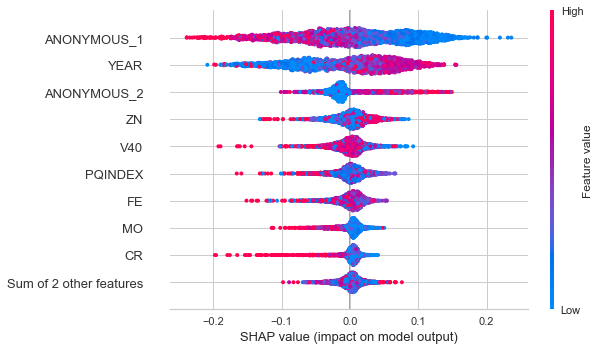

In [41]:
explainer_xgb = shap.Explainer(clf_xgb1)
shap_values_xgb = explainer_xgb(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [42]:
fi_xgb = pd.DataFrame(clf_xgb1.feature_importances_, index=X_train1.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
YEAR                       0.131574
ANONYMOUS_1                0.107487
CR                         0.104835
NI                         0.089841
ANONYMOUS_2                0.088848
PQINDEX                    0.083983
V40                        0.083390
FE                         0.082636
ZN                         0.080499
MO                         0.074572
CU                         0.072334

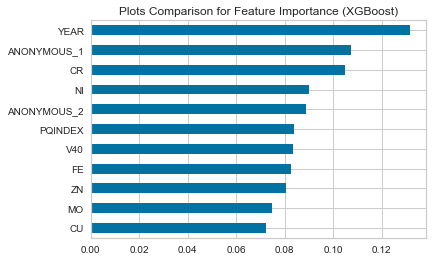

In [43]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
plt.legend([])  # 범례 없애기
plt.show()

### LGBM

In [44]:
def objectiveLGBM(trial, X, y):

    param = {
        'metric': 'mae', 
        'random_state': 42,
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
#         'max_depth':trial.suggest_int('max_depth',3,30),
        'num_leaves' : trial.suggest_categorical('num_leaves', [8,16,32,64,128,256,512,1024]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [45]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train1, y_train1), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-11 18:31:27,858] A new study created in memory with name: no-name-f2fec52e-c83b-4a2e-9901-3aa94bcdb4d7
[I 2022-12-11 18:31:28,541] Trial 0 finished with value: 0.3212315136854302 and parameters: {'n_estimators': 343, 'reg_alpha': 0.005006908133422324, 'reg_lambda': 0.0016094063777817677, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0010751322049211123, 'num_leaves': 32, 'min_child_samples': 258, 'min_data_per_groups': 100}. Best is trial 0 with value: 0.3212315136854302.
[I 2022-12-11 18:31:29,075] Trial 1 finished with value: 0.32648595307997025 and parameters: {'n_estimators': 133, 'reg_alpha': 0.10285049995604817, 'reg_lambda': 0.002090191536758872, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 8.912197435616287e-07, 'num_leaves': 256, 'min_child_samples': 181, 'min_data_per_groups': 81}. Best is trial 0 with value: 0.3212315136854302.
[I 2022-12-11 18:31:30,348] Trial 2 finished with value: 0.3088120096521813 and parameters: {'n_estimators'

[I 2022-12-11 18:31:56,583] Trial 21 finished with value: 0.29733016035689297 and parameters: {'n_estimators': 469, 'reg_alpha': 0.0010438978766252097, 'reg_lambda': 9.011016459297963, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009992237236699723, 'num_leaves': 16, 'min_child_samples': 93, 'min_data_per_groups': 3}. Best is trial 11 with value: 0.29650205832251464.
[I 2022-12-11 18:31:58,581] Trial 22 finished with value: 0.3178844880024621 and parameters: {'n_estimators': 401, 'reg_alpha': 0.0031862318854235247, 'reg_lambda': 3.958289903661631, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.001218283678933441, 'num_leaves': 16, 'min_child_samples': 108, 'min_data_per_groups': 15}. Best is trial 11 with value: 0.29650205832251464.
[I 2022-12-11 18:32:00,845] Trial 23 finished with value: 0.3099084230653236 and parameters: {'n_estimators': 463, 'reg_alpha': 0.00794597938110648, 'reg_lambda': 1.1545499365064238, 'colsample_bytree': 0.8, 'subsample': 1.0,

[I 2022-12-11 18:33:03,125] Trial 42 finished with value: 0.2970029616219362 and parameters: {'n_estimators': 482, 'reg_alpha': 0.004622265653447383, 'reg_lambda': 2.6092306528601146, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.009151431968050634, 'num_leaves': 16, 'min_child_samples': 77, 'min_data_per_groups': 16}. Best is trial 27 with value: 0.2949880372642353.
[I 2022-12-11 18:33:05,182] Trial 43 finished with value: 0.3115722751454031 and parameters: {'n_estimators': 413, 'reg_alpha': 0.0036526704031210806, 'reg_lambda': 0.9297686046435153, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.0021577709142781235, 'num_leaves': 16, 'min_child_samples': 61, 'min_data_per_groups': 16}. Best is trial 27 with value: 0.2949880372642353.
[I 2022-12-11 18:33:06,410] Trial 44 finished with value: 0.31141738000613933 and parameters: {'n_estimators': 480, 'reg_alpha': 0.005003817900969969, 'reg_lambda': 2.2358108414021136, 'colsample_bytree': 0.4, 'subsample': 0.6

[I 2022-12-11 18:33:44,507] Trial 63 finished with value: 0.2969812992905432 and parameters: {'n_estimators': 292, 'reg_alpha': 0.002249821151492432, 'reg_lambda': 4.839496298414631, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009887585251374707, 'num_leaves': 128, 'min_child_samples': 41, 'min_data_per_groups': 16}. Best is trial 62 with value: 0.2947624188013315.
[I 2022-12-11 18:33:50,240] Trial 64 finished with value: 0.29251206732433277 and parameters: {'n_estimators': 268, 'reg_alpha': 0.0026296016343111983, 'reg_lambda': 4.442344228109496, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009583396723557935, 'num_leaves': 128, 'min_child_samples': 9, 'min_data_per_groups': 16}. Best is trial 64 with value: 0.29251206732433277.
[I 2022-12-11 18:33:52,639] Trial 65 finished with value: 0.30411605327785934 and parameters: {'n_estimators': 259, 'reg_alpha': 0.002677106984065543, 'reg_lambda': 4.785705278009954, 'colsample_bytree': 1.0, 'subsample': 1.0,

[I 2022-12-11 18:36:17,507] Trial 84 finished with value: 0.2940382120192878 and parameters: {'n_estimators': 346, 'reg_alpha': 0.0038040375941710823, 'reg_lambda': 7.670142947426194, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.0062210670616765825, 'num_leaves': 128, 'min_child_samples': 1, 'min_data_per_groups': 57}. Best is trial 73 with value: 0.29019841552322445.
[I 2022-12-11 18:36:30,939] Trial 85 finished with value: 0.3040819755707438 and parameters: {'n_estimators': 383, 'reg_alpha': 0.006091984404531856, 'reg_lambda': 7.120835549596274, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.002586157778785456, 'num_leaves': 128, 'min_child_samples': 1, 'min_data_per_groups': 53}. Best is trial 73 with value: 0.29019841552322445.
[I 2022-12-11 18:36:38,696] Trial 86 finished with value: 0.2948112719313329 and parameters: {'n_estimators': 349, 'reg_alpha': 0.0038614395101221805, 'reg_lambda': 2.1400166641148672, 'colsample_bytree': 0.9, 'subsample': 0.4

study.best_params: 0.29019841552322445
Number of finished trials: 100
Best trial: {'n_estimators': 323, 'reg_alpha': 0.0018871568319738029, 'reg_lambda': 9.907504189472133, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009783427879335416, 'num_leaves': 128, 'min_child_samples': 2, 'min_data_per_groups': 28}
study.best_params: {'n_estimators': 323, 'reg_alpha': 0.0018871568319738029, 'reg_lambda': 9.907504189472133, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009783427879335416, 'num_leaves': 128, 'min_child_samples': 2, 'min_data_per_groups': 28}


In [46]:
param_lgbm = studyLGBM.best_params

clf_lgbm1 = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [47]:
clf_lgbm1.fit(X_train1, y_train1.Score_0)

pred_test_lgbm = clf_lgbm1.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.2123
F1 Score : 0.227
Macro F1 Score : 0.5713 

[[2327  189]
 [ 240   63]]


In [48]:
optuna.visualization.plot_param_importances(studyLGBM)

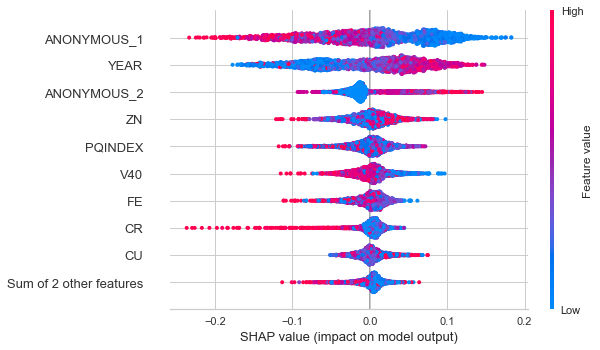

In [49]:
explainer_lgbm = shap.Explainer(clf_lgbm1)
shap_values_lgbm = explainer_lgbm(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [50]:
fi_lgbm = pd.DataFrame(clf_lgbm1.feature_importances_, index=X_train1.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                     6777
ZN                              5424
V40                             5016
PQINDEX                         4886
FE                              4813
CU                              3750
YEAR                            3193
MO                              2513
CR                              2000
ANONYMOUS_2                     1922
NI                               727

In [51]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.165208
ZN                          0.132225
V40                         0.122279
PQINDEX                     0.119110
FE                          0.117330
CU                          0.091417
YEAR                        0.077838
MO                          0.061261
CR                          0.048756
ANONYMOUS_2                 0.046854
NI                          0.017723

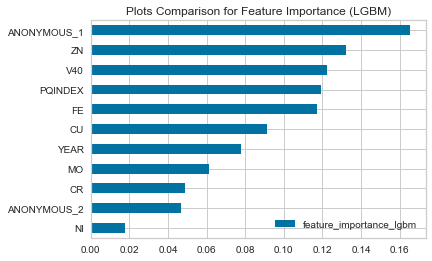

In [52]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [53]:
def objectiveCB(trial, X, y):
    
    param = {
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'max_depth':trial.suggest_int('max_depth',3,13),
        'random_state': 42,
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = CatBoostRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [54]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train1, y_train1), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-11 18:38:00,718] A new study created in memory with name: no-name-33452019-6f20-4bd0-b565-bba067005208
[I 2022-12-11 18:38:08,524] Trial 0 finished with value: 0.3148760205906981 and parameters: {'l2_leaf_reg': 0.13022044558655113, 'max_bin': 373, 'learning_rate': 0.007685704500326136, 'n_estimators': 79, 'max_depth': 9, 'min_data_in_leaf': 93}. Best is trial 0 with value: 0.3148760205906981.
[I 2022-12-11 18:38:17,719] Trial 1 finished with value: 0.29815490633038894 and parameters: {'l2_leaf_reg': 1.3698882606100868, 'max_bin': 385, 'learning_rate': 0.014912926769548755, 'n_estimators': 330, 'max_depth': 7, 'min_data_in_leaf': 96}. Best is trial 1 with value: 0.29815490633038894.
[I 2022-12-11 18:38:21,861] Trial 2 finished with value: 0.30434623939310806 and parameters: {'l2_leaf_reg': 0.002709080776759123, 'max_bin': 362, 'learning_rate': 0.009057528403480692, 'n_estimators': 288, 'max_depth': 4, 'min_data_in_leaf': 47}. Best is trial 1 with value: 0.29815490633038894.
[

[I 2022-12-11 18:57:37,269] Trial 27 finished with value: 0.29892483022676747 and parameters: {'l2_leaf_reg': 0.018008777516258193, 'max_bin': 224, 'learning_rate': 0.014122008618092959, 'n_estimators': 345, 'max_depth': 5, 'min_data_in_leaf': 125}. Best is trial 25 with value: 0.29545703330923023.
[I 2022-12-11 18:57:41,187] Trial 28 finished with value: 0.2977736691885365 and parameters: {'l2_leaf_reg': 0.12292163657789434, 'max_bin': 251, 'learning_rate': 0.016543056695709317, 'n_estimators': 470, 'max_depth': 4, 'min_data_in_leaf': 163}. Best is trial 25 with value: 0.29545703330923023.
[I 2022-12-11 18:57:45,460] Trial 29 finished with value: 0.3069579317659656 and parameters: {'l2_leaf_reg': 0.0012156913681184807, 'max_bin': 300, 'learning_rate': 0.01676532204081515, 'n_estimators': 81, 'max_depth': 8, 'min_data_in_leaf': 26}. Best is trial 25 with value: 0.29545703330923023.
[I 2022-12-11 18:58:01,087] Trial 30 finished with value: 0.2995801777108974 and parameters: {'l2_leaf_re

[I 2022-12-11 18:59:39,800] Trial 54 finished with value: 0.2972013828106029 and parameters: {'l2_leaf_reg': 2.425750692793137, 'max_bin': 294, 'learning_rate': 0.015999036263153486, 'n_estimators': 484, 'max_depth': 6, 'min_data_in_leaf': 196}. Best is trial 25 with value: 0.29545703330923023.
[I 2022-12-11 18:59:43,132] Trial 55 finished with value: 0.29723168768699515 and parameters: {'l2_leaf_reg': 0.07605574272351782, 'max_bin': 264, 'learning_rate': 0.017938335723403864, 'n_estimators': 425, 'max_depth': 5, 'min_data_in_leaf': 215}. Best is trial 25 with value: 0.29545703330923023.
[I 2022-12-11 18:59:45,631] Trial 56 finished with value: 0.3021069878649224 and parameters: {'l2_leaf_reg': 0.01091377109457011, 'max_bin': 231, 'learning_rate': 0.010910997048515277, 'n_estimators': 450, 'max_depth': 3, 'min_data_in_leaf': 240}. Best is trial 25 with value: 0.29545703330923023.
[I 2022-12-11 18:59:48,645] Trial 57 finished with value: 0.29984747201383777 and parameters: {'l2_leaf_reg

[I 2022-12-11 19:04:23,006] Trial 81 finished with value: 0.29752059757924565 and parameters: {'l2_leaf_reg': 0.18288305218927486, 'max_bin': 263, 'learning_rate': 0.017758569907647966, 'n_estimators': 456, 'max_depth': 4, 'min_data_in_leaf': 74}. Best is trial 25 with value: 0.29545703330923023.
[I 2022-12-11 19:04:25,970] Trial 82 finished with value: 0.2978856642464236 and parameters: {'l2_leaf_reg': 0.2352181473289936, 'max_bin': 256, 'learning_rate': 0.017138872072866847, 'n_estimators': 421, 'max_depth': 4, 'min_data_in_leaf': 101}. Best is trial 25 with value: 0.29545703330923023.
[I 2022-12-11 19:04:29,154] Trial 83 finished with value: 0.29816715279921924 and parameters: {'l2_leaf_reg': 0.6008333304676197, 'max_bin': 261, 'learning_rate': 0.01653196013849482, 'n_estimators': 487, 'max_depth': 3, 'min_data_in_leaf': 37}. Best is trial 25 with value: 0.29545703330923023.
[I 2022-12-11 19:04:33,407] Trial 84 finished with value: 0.2966035265596788 and parameters: {'l2_leaf_reg': 

study.best_params: 0.29545703330923023
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.03637355436516731, 'max_bin': 272, 'learning_rate': 0.016177015715028883, 'n_estimators': 495, 'max_depth': 5, 'min_data_in_leaf': 180}
study.best_params: {'l2_leaf_reg': 0.03637355436516731, 'max_bin': 272, 'learning_rate': 0.016177015715028883, 'n_estimators': 495, 'max_depth': 5, 'min_data_in_leaf': 180}


In [55]:
param_cat = studyCB.best_params

clf_cat1 = CatBoostRegressor(**param_cat, random_state=42)

In [56]:
clf_cat1.fit(X_train1, y_train1.Score_0)

pred_test_cat = clf_cat1.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3809506	total: 2.13ms	remaining: 1.05s
1:	learn: 0.3804518	total: 4.58ms	remaining: 1.13s
2:	learn: 0.3800137	total: 7ms	remaining: 1.15s
3:	learn: 0.3795831	total: 9.76ms	remaining: 1.2s
4:	learn: 0.3791757	total: 12.7ms	remaining: 1.25s
5:	learn: 0.3786769	total: 14.9ms	remaining: 1.21s
6:	learn: 0.3781074	total: 17.1ms	remaining: 1.19s
7:	learn: 0.3776650	total: 19.5ms	remaining: 1.19s
8:	learn: 0.3773197	total: 21.8ms	remaining: 1.18s
9:	learn: 0.3768610	total: 24.3ms	remaining: 1.18s
10:	learn: 0.3765052	total: 26.6ms	remaining: 1.17s
11:	learn: 0.3761564	total: 28.4ms	remaining: 1.14s
12:	learn: 0.3757852	total: 30.1ms	remaining: 1.11s
13:	learn: 0.3754560	total: 31.7ms	remaining: 1.09s
14:	learn: 0.3750616	total: 33.6ms	remaining: 1.07s
15:	learn: 0.3747126	total: 35.6ms	remaining: 1.07s
16:	learn: 0.3743688	total: 37.4ms	remaining: 1.05s
17:	learn: 0.3740624	total: 39.4ms	remaining: 1.04s
18:	learn: 0.3737094	total: 41.3ms	remaining: 1.03s
19:	learn: 0.3733274	total

164:	learn: 0.3531356	total: 333ms	remaining: 665ms
165:	learn: 0.3530876	total: 335ms	remaining: 663ms
166:	learn: 0.3530448	total: 336ms	remaining: 660ms
167:	learn: 0.3529987	total: 338ms	remaining: 658ms
168:	learn: 0.3529149	total: 339ms	remaining: 655ms
169:	learn: 0.3527973	total: 341ms	remaining: 652ms
170:	learn: 0.3527256	total: 343ms	remaining: 650ms
171:	learn: 0.3526715	total: 345ms	remaining: 647ms
172:	learn: 0.3526051	total: 347ms	remaining: 645ms
173:	learn: 0.3525534	total: 348ms	remaining: 643ms
174:	learn: 0.3524841	total: 350ms	remaining: 640ms
175:	learn: 0.3524040	total: 352ms	remaining: 638ms
176:	learn: 0.3523337	total: 354ms	remaining: 635ms
177:	learn: 0.3522882	total: 355ms	remaining: 633ms
178:	learn: 0.3522113	total: 357ms	remaining: 631ms
179:	learn: 0.3521210	total: 359ms	remaining: 628ms
180:	learn: 0.3520675	total: 361ms	remaining: 626ms
181:	learn: 0.3519867	total: 363ms	remaining: 624ms
182:	learn: 0.3518972	total: 364ms	remaining: 621ms
183:	learn: 

350:	learn: 0.3430187	total: 667ms	remaining: 274ms
351:	learn: 0.3429639	total: 669ms	remaining: 272ms
352:	learn: 0.3429219	total: 671ms	remaining: 270ms
353:	learn: 0.3428800	total: 672ms	remaining: 268ms
354:	learn: 0.3428440	total: 674ms	remaining: 266ms
355:	learn: 0.3428118	total: 676ms	remaining: 264ms
356:	learn: 0.3427885	total: 677ms	remaining: 262ms
357:	learn: 0.3427684	total: 679ms	remaining: 260ms
358:	learn: 0.3427030	total: 681ms	remaining: 258ms
359:	learn: 0.3426538	total: 683ms	remaining: 256ms
360:	learn: 0.3426042	total: 685ms	remaining: 254ms
361:	learn: 0.3425713	total: 686ms	remaining: 252ms
362:	learn: 0.3425205	total: 688ms	remaining: 250ms
363:	learn: 0.3424971	total: 690ms	remaining: 248ms
364:	learn: 0.3424328	total: 692ms	remaining: 247ms
365:	learn: 0.3423904	total: 694ms	remaining: 245ms
366:	learn: 0.3423318	total: 696ms	remaining: 243ms
367:	learn: 0.3422819	total: 697ms	remaining: 241ms
368:	learn: 0.3422353	total: 699ms	remaining: 239ms
369:	learn: 

In [57]:
optuna.visualization.plot_param_importances(studyCB)

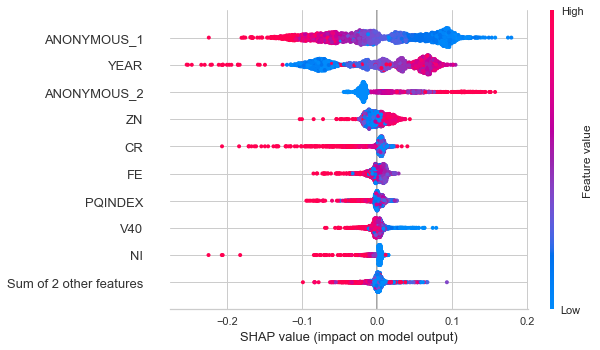

In [58]:
explainer_cat = shap.Explainer(clf_cat1)
shap_values_cat = explainer_cat(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [59]:
fi_cat = pd.DataFrame(clf_cat1.feature_importances_, index=X_train1.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
YEAR                      23.167523
ANONYMOUS_1               20.441696
ANONYMOUS_2               11.402997
CR                         7.520459
ZN                         6.775365
PQINDEX                    6.643046
FE                         6.530805
V40                        6.093725
MO                         4.049493
NI                         3.773860
CU                         3.601031

In [60]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
YEAR                       0.231675
ANONYMOUS_1                0.204417
ANONYMOUS_2                0.114030
CR                         0.075205
ZN                         0.067754
PQINDEX                    0.066430
FE                         0.065308
V40                        0.060937
MO                         0.040495
NI                         0.037739
CU                         0.036010

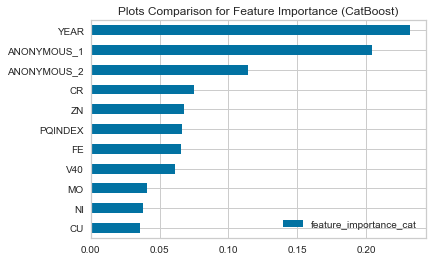

In [61]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Trees

In [62]:
def objectiveET(trial, X, y):
    
    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = ExtraTreesRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [63]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train1, y_train1), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-11 19:06:17,382] A new study created in memory with name: no-name-c2ea15ef-4b0a-42b4-a8a0-618e2e4ab350
[I 2022-12-11 19:06:19,401] Trial 0 finished with value: 0.29593436708395626 and parameters: {'max_depth': 8, 'max_leaf_nodes': 177, 'n_estimators': 177}. Best is trial 0 with value: 0.29593436708395626.
[I 2022-12-11 19:06:21,764] Trial 1 finished with value: 0.30347698022598546 and parameters: {'max_depth': 5, 'max_leaf_nodes': 276, 'n_estimators': 316}. Best is trial 0 with value: 0.29593436708395626.
[I 2022-12-11 19:06:26,704] Trial 2 finished with value: 0.29304050811567717 and parameters: {'max_depth': 13, 'max_leaf_nodes': 348, 'n_estimators': 318}. Best is trial 2 with value: 0.29304050811567717.
[I 2022-12-11 19:06:29,178] Trial 3 finished with value: 0.30754083093594314 and parameters: {'max_depth': 4, 'max_leaf_nodes': 652, 'n_estimators': 427}. Best is trial 2 with value: 0.29304050811567717.
[I 2022-12-11 19:06:30,899] Trial 4 finished with value: 0.3003471861

[I 2022-12-11 19:09:01,937] Trial 38 finished with value: 0.29326444497683124 and parameters: {'max_depth': 12, 'max_leaf_nodes': 209, 'n_estimators': 261}. Best is trial 16 with value: 0.2926579757674946.
[I 2022-12-11 19:09:02,842] Trial 39 finished with value: 0.3125120737039281 and parameters: {'max_depth': 3, 'max_leaf_nodes': 298, 'n_estimators': 186}. Best is trial 16 with value: 0.2926579757674946.
[I 2022-12-11 19:09:04,139] Trial 40 finished with value: 0.29807147230412645 and parameters: {'max_depth': 7, 'max_leaf_nodes': 426, 'n_estimators': 142}. Best is trial 16 with value: 0.2926579757674946.
[I 2022-12-11 19:09:09,389] Trial 41 finished with value: 0.2932477244532452 and parameters: {'max_depth': 12, 'max_leaf_nodes': 374, 'n_estimators': 351}. Best is trial 16 with value: 0.2926579757674946.
[I 2022-12-11 19:09:15,666] Trial 42 finished with value: 0.29327611051154673 and parameters: {'max_depth': 11, 'max_leaf_nodes': 257, 'n_estimators': 469}. Best is trial 16 with v

[I 2022-12-11 19:12:38,534] Trial 76 finished with value: 0.2931950312679142 and parameters: {'max_depth': 12, 'max_leaf_nodes': 399, 'n_estimators': 462}. Best is trial 16 with value: 0.2926579757674946.
[I 2022-12-11 19:12:46,026] Trial 77 finished with value: 0.293517513477399 and parameters: {'max_depth': 11, 'max_leaf_nodes': 361, 'n_estimators': 488}. Best is trial 16 with value: 0.2926579757674946.
[I 2022-12-11 19:12:51,919] Trial 78 finished with value: 0.29367062694630885 and parameters: {'max_depth': 10, 'max_leaf_nodes': 215, 'n_estimators': 481}. Best is trial 16 with value: 0.2926579757674946.
[I 2022-12-11 19:13:00,406] Trial 79 finished with value: 0.2933732679605767 and parameters: {'max_depth': 12, 'max_leaf_nodes': 467, 'n_estimators': 498}. Best is trial 16 with value: 0.2926579757674946.
[I 2022-12-11 19:13:05,184] Trial 80 finished with value: 0.2958354996783933 and parameters: {'max_depth': 8, 'max_leaf_nodes': 267, 'n_estimators': 463}. Best is trial 16 with val

study.best_params: 0.2926579757674946
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 292, 'n_estimators': 62}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 292, 'n_estimators': 62}


In [64]:
param_et = studyET.best_params

clf_et1 = ExtraTreesRegressor(**param_et, random_state=42)

In [65]:
clf_et1.fit(X_train1, y_train1.Score_0)

pred_test_et = clf_et1.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.2197
F1 Score : 0.2274
Macro F1 Score : 0.5745 

[[2359  193]
 [ 208   59]]


In [66]:
optuna.visualization.plot_param_importances(studyET)

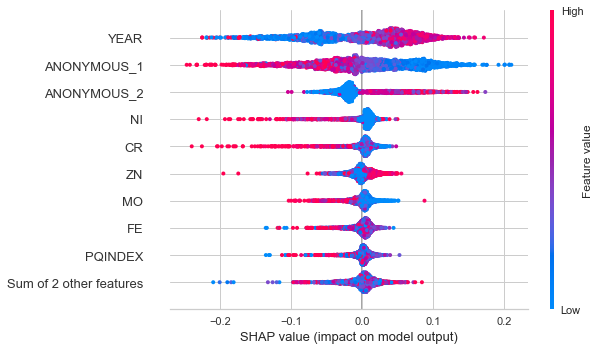

In [67]:
explainer_et = shap.Explainer(clf_et1)
shap_values_et = explainer_et(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [68]:
fi_et = pd.DataFrame(clf_et1.feature_importances_, index=X_train1.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.183311
YEAR                      0.162534
PQINDEX                   0.078829
FE                        0.078721
V40                       0.077549
CU                        0.076601
CR                        0.075182
ZN                        0.071275
ANONYMOUS_2               0.068716
MO                        0.066920
NI                        0.060362

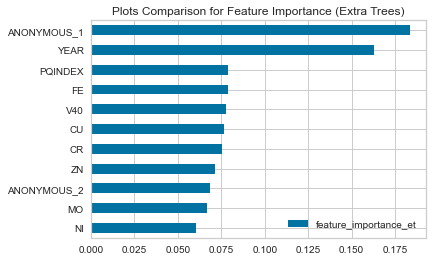

In [69]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Dataset 2

### Decision Tree

In [70]:
def objectiveDT(trial, X, y):
    
    param = {
    'criterion': trial.suggest_categorical('criterion',['mae']),
    'splitter': trial.suggest_categorical('splitter',['best','random']),
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = DecisionTreeRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [71]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train2, y_train2), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-11 19:15:44,565] A new study created in memory with name: no-name-d33713cd-349f-450a-8952-9d7dea0e33cf
[I 2022-12-11 19:15:46,710] Trial 0 finished with value: 0.2580239054290718 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 13, 'max_leaf_nodes': 335}. Best is trial 0 with value: 0.2580239054290718.
[I 2022-12-11 19:15:47,870] Trial 1 finished with value: 0.23408218914185638 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 4, 'max_leaf_nodes': 484}. Best is trial 1 with value: 0.23408218914185638.
[I 2022-12-11 19:15:49,551] Trial 2 finished with value: 0.2359149036777583 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 7, 'max_leaf_nodes': 530}. Best is trial 1 with value: 0.23408218914185638.
[I 2022-12-11 19:15:50,191] Trial 3 finished with value: 0.2365437302977233 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 5, 'max_leaf_nodes': 949}. Best is trial 1 with value: 0.23408218914185

[I 2022-12-11 19:16:32,558] Trial 35 finished with value: 0.23408218914185638 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 4, 'max_leaf_nodes': 919}. Best is trial 11 with value: 0.2339699649737303.
[I 2022-12-11 19:16:33,142] Trial 36 finished with value: 0.2376862171628722 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 3, 'max_leaf_nodes': 685}. Best is trial 11 with value: 0.2339699649737303.
[I 2022-12-11 19:16:34,535] Trial 37 finished with value: 0.23408218914185638 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 4, 'max_leaf_nodes': 571}. Best is trial 11 with value: 0.2339699649737303.
[I 2022-12-11 19:16:35,554] Trial 38 finished with value: 0.27830732049036777 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 13, 'max_leaf_nodes': 841}. Best is trial 11 with value: 0.2339699649737303.
[I 2022-12-11 19:16:37,171] Trial 39 finished with value: 0.23572259194395792 and parameters: {'crit

[I 2022-12-11 19:17:19,522] Trial 70 finished with value: 0.23408218914185638 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 4, 'max_leaf_nodes': 997}. Best is trial 11 with value: 0.2339699649737303.
[I 2022-12-11 19:17:20,523] Trial 71 finished with value: 0.2339699649737303 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 912}. Best is trial 11 with value: 0.2339699649737303.
[I 2022-12-11 19:17:21,477] Trial 72 finished with value: 0.2339699649737303 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 933}. Best is trial 11 with value: 0.2339699649737303.
[I 2022-12-11 19:17:22,471] Trial 73 finished with value: 0.2339699649737303 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 99}. Best is trial 11 with value: 0.2339699649737303.
[I 2022-12-11 19:17:23,415] Trial 74 finished with value: 0.2339699649737303 and parameters: {'criterion': '

study.best_params: 0.2339699649737303
Number of finished trials: 100
Best trial: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 784}
study.best_params: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 784}


In [72]:
param_dt = studyDT.best_params

clf_dt2 = DecisionTreeRegressor(**param_dt, random_state=42)

In [73]:
clf_dt2.fit(X_train2, y_train2.Score_0)

pred_test_dt = clf_dt2.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.0907
F1 Score : 0.1296
Macro F1 Score : 0.5355 

[[2487  229]
 [  80   23]]


In [74]:
optuna.visualization.plot_param_importances(studyDT)

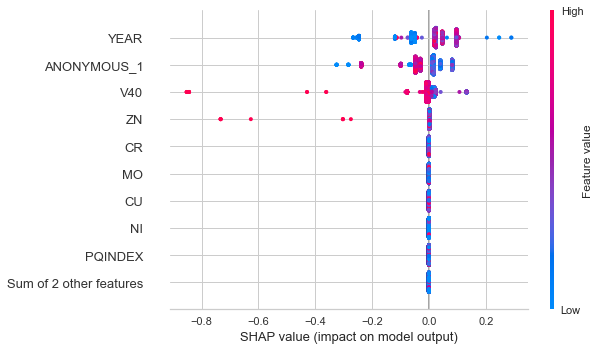

In [75]:
explainer_dt = shap.Explainer(clf_dt2)
shap_values_dt = explainer_dt(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [76]:
fi_dt = pd.DataFrame(clf_dt2.feature_importances_, index=X_train2.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
ANONYMOUS_1               0.516116
V40                       0.207823
YEAR                      0.190939
ZN                        0.085122
FE                        0.000000
ANONYMOUS_2               0.000000
PQINDEX                   0.000000
NI                        0.000000
CU                        0.000000
MO                        0.000000
CR                        0.000000

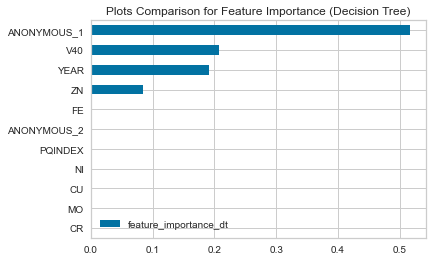

In [77]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [78]:
def objectiveSVR(trial, X, y):
    
    param = {
        'C': trial.suggest_loguniform('C', 0.3, 10.0),
        'degree': trial.suggest_int('degree', 2, 7),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 0.01),
        'epsilon': trial.suggest_float('epsilon', 0.05, 0.5),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = SVR(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [79]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train2, y_train2), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-11 19:17:52,011] A new study created in memory with name: no-name-8af7a8b6-290c-44c0-b425-0f6365b36602
[I 2022-12-11 19:17:53,877] Trial 0 finished with value: 0.3478633097961564 and parameters: {'C': 2.6423328565257447, 'degree': 2, 'gamma': 0.0018855348004294186, 'epsilon': 0.2958237596259918}. Best is trial 0 with value: 0.3478633097961564.
[I 2022-12-11 19:17:55,373] Trial 1 finished with value: 0.3881095830052294 and parameters: {'C': 1.3347857087616413, 'degree': 2, 'gamma': 0.002801042061982116, 'epsilon': 0.3849289748729722}. Best is trial 0 with value: 0.3478633097961564.
[I 2022-12-11 19:17:56,654] Trial 2 finished with value: 0.4265098107756515 and parameters: {'C': 0.9959625312609718, 'degree': 6, 'gamma': 0.003431625423134859, 'epsilon': 0.46605883488589156}. Best is trial 0 with value: 0.3478633097961564.
[I 2022-12-11 19:17:58,736] Trial 3 finished with value: 0.38266847912404894 and parameters: {'C': 6.622112121155128, 'degree': 5, 'gamma': 0.0070524975347436

[I 2022-12-11 19:19:02,077] Trial 32 finished with value: 0.2525222716540639 and parameters: {'C': 0.41365890144662637, 'degree': 3, 'gamma': 0.0036538923513111505, 'epsilon': 0.05141306650938663}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-11 19:19:03,982] Trial 33 finished with value: 0.2796697726278439 and parameters: {'C': 0.3930180131541069, 'degree': 2, 'gamma': 0.0036241990794308935, 'epsilon': 0.12524721285333887}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-11 19:19:06,264] Trial 34 finished with value: 0.2560868598279399 and parameters: {'C': 1.1896098376499842, 'degree': 3, 'gamma': 0.003318324288124785, 'epsilon': 0.05026993102743202}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-11 19:19:07,841] Trial 35 finished with value: 0.42140311882007103 and parameters: {'C': 0.5736771376359402, 'degree': 4, 'gamma': 0.002683648030598229, 'epsilon': 0.45354007297540794}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-1

[I 2022-12-11 19:20:17,241] Trial 64 finished with value: 0.27536880814098497 and parameters: {'C': 0.49255350838159473, 'degree': 4, 'gamma': 0.0028798287569443506, 'epsilon': 0.11522623983453255}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-11 19:20:19,266] Trial 65 finished with value: 0.2510301561628533 and parameters: {'C': 0.7687705039838278, 'degree': 3, 'gamma': 0.0014497871255191145, 'epsilon': 0.05037071832479928}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-11 19:20:21,188] Trial 66 finished with value: 0.2670914752173491 and parameters: {'C': 0.7568279437311535, 'degree': 3, 'gamma': 0.0013192628509058031, 'epsilon': 0.09667131597042386}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-11 19:20:23,190] Trial 67 finished with value: 0.28406356134470206 and parameters: {'C': 0.40939825196647556, 'degree': 4, 'gamma': 0.0020867282761113746, 'epsilon': 0.13743937797613284}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-

[I 2022-12-11 19:21:22,026] Trial 96 finished with value: 0.2528527373624653 and parameters: {'C': 0.43032109763482834, 'degree': 4, 'gamma': 0.003933302932757075, 'epsilon': 0.052059297673690774}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-11 19:21:23,915] Trial 97 finished with value: 0.2568281298760058 and parameters: {'C': 0.3661345296186156, 'degree': 4, 'gamma': 0.003266236985062338, 'epsilon': 0.06652709296945777}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-11 19:21:25,308] Trial 98 finished with value: 0.4030723514612687 and parameters: {'C': 0.33531371064665716, 'degree': 4, 'gamma': 0.003910925212840526, 'epsilon': 0.41122138591243607}. Best is trial 18 with value: 0.25077814446321745.
[I 2022-12-11 19:21:27,286] Trial 99 finished with value: 0.2511912003659778 and parameters: {'C': 0.4320614226871024, 'degree': 4, 'gamma': 0.0022113216933649787, 'epsilon': 0.05003840723998973}. Best is trial 18 with value: 0.25077814446321745.


study.best_params: 0.25077814446321745
Number of finished trials: 100
Best trial: {'C': 0.3158204381197464, 'degree': 3, 'gamma': 0.0021238193761269073, 'epsilon': 0.050870958046898396}
study.best_params: {'C': 0.3158204381197464, 'degree': 3, 'gamma': 0.0021238193761269073, 'epsilon': 0.050870958046898396}


In [80]:
param_svr = studySVR.best_params

clf_svr2 = SVR(**param_svr)

In [81]:
clf_svr2.fit(X_train2, y_train2.Score_0)

pred_test_svr = clf_svr2.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.1124
F1 Score : 0.0296
Macro F1 Score : 0.4904 

[[2553  248]
 [  14    4]]


In [82]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [83]:
def objectiveRF(trial, X, y):

    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),  # max_depth 제한
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),  # n_estimators 제한
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = RandomForestRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [84]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train2, y_train2), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-11 19:21:29,986] A new study created in memory with name: no-name-33c55918-839a-407d-bf36-eb097c700e8f
[I 2022-12-11 19:21:38,056] Trial 0 finished with value: 0.28971883237530277 and parameters: {'max_depth': 9, 'max_leaf_nodes': 959, 'n_estimators': 242}. Best is trial 0 with value: 0.28971883237530277.
[I 2022-12-11 19:21:40,250] Trial 1 finished with value: 0.3039488006970625 and parameters: {'max_depth': 3, 'max_leaf_nodes': 928, 'n_estimators': 157}. Best is trial 0 with value: 0.28971883237530277.
[I 2022-12-11 19:21:49,422] Trial 2 finished with value: 0.28898042282615755 and parameters: {'max_depth': 11, 'max_leaf_nodes': 197, 'n_estimators': 224}. Best is trial 2 with value: 0.28898042282615755.
[I 2022-12-11 19:21:52,721] Trial 3 finished with value: 0.3038324553879859 and parameters: {'max_depth': 3, 'max_leaf_nodes': 84, 'n_estimators': 230}. Best is trial 2 with value: 0.28898042282615755.
[I 2022-12-11 19:22:02,919] Trial 4 finished with value: 0.2881716953774

[I 2022-12-11 19:27:35,788] Trial 38 finished with value: 0.28981795271104616 and parameters: {'max_depth': 11, 'max_leaf_nodes': 835, 'n_estimators': 133}. Best is trial 35 with value: 0.28778323418043295.
[I 2022-12-11 19:27:42,753] Trial 39 finished with value: 0.2917456707018099 and parameters: {'max_depth': 13, 'max_leaf_nodes': 43, 'n_estimators': 252}. Best is trial 35 with value: 0.28778323418043295.
[I 2022-12-11 19:27:50,974] Trial 40 finished with value: 0.28949508346663927 and parameters: {'max_depth': 11, 'max_leaf_nodes': 368, 'n_estimators': 222}. Best is trial 35 with value: 0.28778323418043295.
[I 2022-12-11 19:27:58,585] Trial 41 finished with value: 0.28823727488090567 and parameters: {'max_depth': 10, 'max_leaf_nodes': 140, 'n_estimators': 220}. Best is trial 35 with value: 0.28778323418043295.
[I 2022-12-11 19:28:08,895] Trial 42 finished with value: 0.2877223436121411 and parameters: {'max_depth': 11, 'max_leaf_nodes': 147, 'n_estimators': 298}. Best is trial 42 w

[I 2022-12-11 19:33:21,979] Trial 76 finished with value: 0.2900593388598441 and parameters: {'max_depth': 12, 'max_leaf_nodes': 282, 'n_estimators': 242}. Best is trial 51 with value: 0.2876387746734893.
[I 2022-12-11 19:33:28,576] Trial 77 finished with value: 0.28938497612289665 and parameters: {'max_depth': 10, 'max_leaf_nodes': 709, 'n_estimators': 192}. Best is trial 51 with value: 0.2876387746734893.
[I 2022-12-11 19:33:40,324] Trial 78 finished with value: 0.28819916025589914 and parameters: {'max_depth': 11, 'max_leaf_nodes': 162, 'n_estimators': 332}. Best is trial 51 with value: 0.2876387746734893.
[I 2022-12-11 19:33:43,801] Trial 79 finished with value: 0.3038307596613704 and parameters: {'max_depth': 3, 'max_leaf_nodes': 134, 'n_estimators': 257}. Best is trial 51 with value: 0.2876387746734893.
[I 2022-12-11 19:33:53,554] Trial 80 finished with value: 0.2894072269168469 and parameters: {'max_depth': 10, 'max_leaf_nodes': 198, 'n_estimators': 287}. Best is trial 51 with v

study.best_params: 0.2875721262613866
Number of finished trials: 100
Best trial: {'max_depth': 12, 'max_leaf_nodes': 152, 'n_estimators': 235}
study.best_params: {'max_depth': 12, 'max_leaf_nodes': 152, 'n_estimators': 235}


In [85]:
param_rf = studyRF.best_params

clf_rf2 = RandomForestRegressor(**param_rf, random_state=42)

In [86]:
clf_rf2.fit(X_train2, y_train2.Score_0)

pred_test_rf = clf_rf2.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.2171
F1 Score : 0.257
Macro F1 Score : 0.5894 

[[2351  183]
 [ 216   69]]


In [87]:
optuna.visualization.plot_param_importances(studyRF)

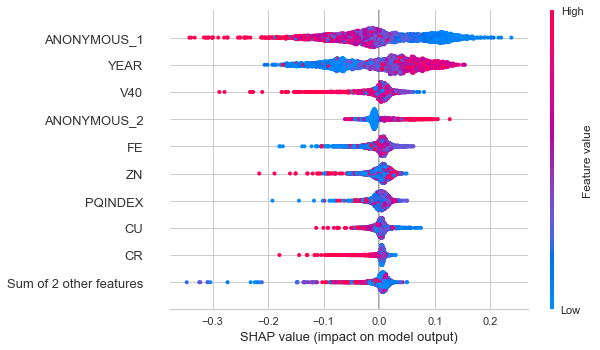

In [88]:
explainer_rf = shap.Explainer(clf_rf2)
shap_values_rf = explainer_rf(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [89]:
fi_rf = pd.DataFrame(clf_rf2.feature_importances_, index=X_train2.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.215211
V40                       0.120535
YEAR                      0.113919
ZN                        0.107566
FE                        0.101001
PQINDEX                   0.088878
CU                        0.074689
MO                        0.051319
CR                        0.045797
ANONYMOUS_2               0.045102
NI                        0.035983

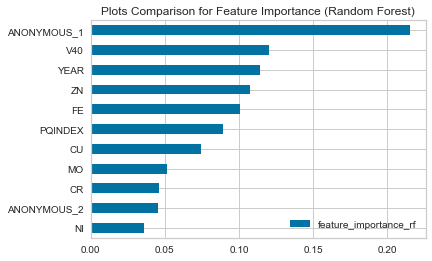

In [90]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [91]:
def objectiveXGB(trial, X, y):

    param = {
    'verbosity':1,
    'objective': trial.suggest_categorical('objective',['reg:squarederror']),
    'max_depth':trial.suggest_int('max_depth',3,13),  # 데이터 수가 적어 3~13으로 제한
    'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'subsample':trial.suggest_loguniform('subsample',0.7,1),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 300 ),
    'alpha': trial.suggest_loguniform( 'alpha', 1e-3, 10.0),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [92]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train2, y_train2), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-11 19:36:57,378] A new study created in memory with name: no-name-0b897ce3-d479-4831-9fea-9a4219131908
[I 2022-12-11 19:36:59,720] Trial 0 finished with value: 0.3819098561050929 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.0029994962106345614, 'n_estimators': 173, 'subsample': 0.862517615859184, 'min_child_weight': 21, 'alpha': 0.004189356325649903}. Best is trial 0 with value: 0.3819098561050929.
[I 2022-12-11 19:37:02,878] Trial 1 finished with value: 0.4402714763180387 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 2.564648416195268e-05, 'n_estimators': 376, 'subsample': 0.8990831177229061, 'min_child_weight': 195, 'alpha': 0.03944381809005082}. Best is trial 0 with value: 0.3819098561050929.
[I 2022-12-11 19:37:04,385] Trial 2 finished with value: 0.4405954886493248 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 6.208720423663617e-05, 'n_estimators': 111, 'sub

[I 2022-12-11 19:38:08,154] Trial 23 finished with value: 0.4359647844849702 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.00016711343846447839, 'n_estimators': 250, 'subsample': 0.7540662585266753, 'min_child_weight': 195, 'alpha': 0.002879006393136235}. Best is trial 16 with value: 0.31284146046478145.
[I 2022-12-11 19:38:09,822] Trial 24 finished with value: 0.4038830924193454 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.002415517045551607, 'n_estimators': 134, 'subsample': 0.8368345243857748, 'min_child_weight': 266, 'alpha': 0.03731660996916305}. Best is trial 16 with value: 0.31284146046478145.
[I 2022-12-11 19:38:13,839] Trial 25 finished with value: 0.34189359943660463 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.004129857983556679, 'n_estimators': 318, 'subsample': 0.7604102628920971, 'min_child_weight': 215, 'alpha': 0.009635388310889214}. Best is trial 16 wi

[I 2022-12-11 19:39:20,664] Trial 46 finished with value: 0.4228480074404334 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.0006006596603141839, 'n_estimators': 234, 'subsample': 0.8486176959414625, 'min_child_weight': 85, 'alpha': 0.003374960173841349}. Best is trial 16 with value: 0.31284146046478145.
[I 2022-12-11 19:39:22,379] Trial 47 finished with value: 0.4155651101890337 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.0011745128690303095, 'n_estimators': 178, 'subsample': 0.9224764095738403, 'min_child_weight': 183, 'alpha': 0.013076570234356601}. Best is trial 16 with value: 0.31284146046478145.
[I 2022-12-11 19:39:26,122] Trial 48 finished with value: 0.31949408181803446 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.00634616194405197, 'n_estimators': 315, 'subsample': 0.7825213171911154, 'min_child_weight': 136, 'alpha': 0.0020878251840946156}. Best is trial 16 wi

[I 2022-12-11 19:40:44,700] Trial 69 finished with value: 0.39003933603447083 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.0010214491003670391, 'n_estimators': 430, 'subsample': 0.8033243008708185, 'min_child_weight': 51, 'alpha': 0.004680395621295835}. Best is trial 65 with value: 0.30022578053823495.
[I 2022-12-11 19:40:53,996] Trial 70 finished with value: 0.4246755407565028 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.00033602876331876273, 'n_estimators': 358, 'subsample': 0.7593158214174919, 'min_child_weight': 11, 'alpha': 0.0014133434398421805}. Best is trial 65 with value: 0.30022578053823495.
[I 2022-12-11 19:40:58,752] Trial 71 finished with value: 0.31212071507934935 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.0074818766911111416, 'n_estimators': 328, 'subsample': 0.741921500278476, 'min_child_weight': 137, 'alpha': 0.0018749545688214852}. Best is trial

[I 2022-12-11 19:42:58,313] Trial 93 finished with value: 0.31634666838425474 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.00484024830035445, 'n_estimators': 431, 'subsample': 0.7213914805857988, 'min_child_weight': 24, 'alpha': 2.5411050305641343}. Best is trial 65 with value: 0.30022578053823495.
[I 2022-12-11 19:43:04,295] Trial 94 finished with value: 0.3278780852124069 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.004171498276439239, 'n_estimators': 416, 'subsample': 0.717567163253934, 'min_child_weight': 14, 'alpha': 5.391370979155027}. Best is trial 65 with value: 0.30022578053823495.
[I 2022-12-11 19:43:11,210] Trial 95 finished with value: 0.44139906782277205 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 3.664127214740712e-06, 'n_estimators': 401, 'subsample': 0.7000498806800297, 'min_child_weight': 6, 'alpha': 4.10260868499392}. Best is trial 65 with value: 0

study.best_params: 0.30022578053823495
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.009483611689139445, 'n_estimators': 351, 'subsample': 0.8107017262600892, 'min_child_weight': 98, 'alpha': 0.0010726441097354638}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.009483611689139445, 'n_estimators': 351, 'subsample': 0.8107017262600892, 'min_child_weight': 98, 'alpha': 0.0010726441097354638}


In [93]:
param_xgb = studyXGB.best_params

clf_xgb2 = xgb.XGBRegressor(**param_xgb, random_state=42)

In [94]:
clf_xgb2.fit(X_train2, y_train2.Score_0)

pred_test_xgb = clf_xgb2.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2317
F1 Score : 0.239
Macro F1 Score : 0.5823 

[[2377  192]
 [ 190   60]]


In [95]:
optuna.visualization.plot_param_importances(studyXGB)

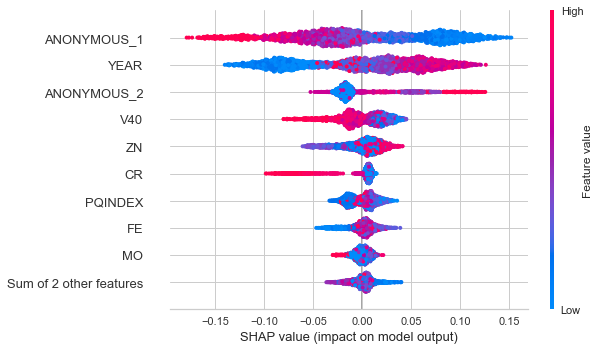

In [96]:
explainer_xgb = shap.Explainer(clf_xgb2)
shap_values_xgb = explainer_xgb(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [97]:
fi_xgb = pd.DataFrame(clf_xgb2.feature_importances_, index=X_train2.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
YEAR                       0.142924
CR                         0.127030
ANONYMOUS_1                0.120906
ANONYMOUS_2                0.111864
NI                         0.086262
V40                        0.074137
ZN                         0.069488
CU                         0.068961
FE                         0.067016
PQINDEX                    0.065785
MO                         0.065627

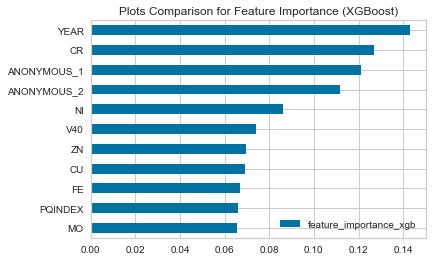

In [98]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
# plt.legend([])  # 범례 없애기
plt.show()

### LGBM

In [99]:
def objectiveLGBM(trial, X, y):

    param = {
        'metric': 'mae', 
        'random_state': 42,
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
#         'max_depth':trial.suggest_int('max_depth',3,30),
        'num_leaves' : trial.suggest_categorical('num_leaves', [8,16,32,64,128,256,512,1024]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [100]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train2, y_train2), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-11 19:43:43,846] A new study created in memory with name: no-name-c4d772e0-b929-42c3-ac72-064cf57ee57f
[I 2022-12-11 19:43:48,294] Trial 0 finished with value: 0.3268631996480706 and parameters: {'n_estimators': 370, 'reg_alpha': 2.6276406230403584, 'reg_lambda': 0.01746649068345401, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 1.3676082526194473e-08, 'num_leaves': 128, 'min_child_samples': 10, 'min_data_per_groups': 79}. Best is trial 0 with value: 0.3268631996480706.
[I 2022-12-11 19:43:50,491] Trial 1 finished with value: 0.326862608821106 and parameters: {'n_estimators': 317, 'reg_alpha': 0.0016318559495359462, 'reg_lambda': 0.04257683580233883, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 1.0231836636123739e-07, 'num_leaves': 1024, 'min_child_samples': 68, 'min_data_per_groups': 46}. Best is trial 1 with value: 0.326862608821106.
[I 2022-12-11 19:43:52,521] Trial 2 finished with value: 0.32667820816391413 and parameters: {'n_estimators': 42

[I 2022-12-11 19:44:12,510] Trial 21 finished with value: 0.3095733441050457 and parameters: {'n_estimators': 165, 'reg_alpha': 0.01976231047537727, 'reg_lambda': 0.0011664477150090645, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.008045520563026013, 'num_leaves': 8, 'min_child_samples': 122, 'min_data_per_groups': 8}. Best is trial 3 with value: 0.3042450755223098.
[I 2022-12-11 19:44:13,384] Trial 22 finished with value: 0.3060644484480207 and parameters: {'n_estimators': 181, 'reg_alpha': 0.2980377162712453, 'reg_lambda': 0.0033211306576324535, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.009387567666405972, 'num_leaves': 8, 'min_child_samples': 68, 'min_data_per_groups': 11}. Best is trial 3 with value: 0.3042450755223098.
[I 2022-12-11 19:44:15,129] Trial 23 finished with value: 0.31421181963020695 and parameters: {'n_estimators': 259, 'reg_alpha': 0.3093834883969512, 'reg_lambda': 0.0043357649680032485, 'colsample_bytree': 0.8, 'subsample': 0.7, 

[I 2022-12-11 19:44:46,944] Trial 42 finished with value: 0.31979705273701 and parameters: {'n_estimators': 287, 'reg_alpha': 4.150197425323417, 'reg_lambda': 0.0025737814364323033, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0013584743505585918, 'num_leaves': 8, 'min_child_samples': 89, 'min_data_per_groups': 69}. Best is trial 27 with value: 0.30380649107351193.
[I 2022-12-11 19:44:48,062] Trial 43 finished with value: 0.30636223905688026 and parameters: {'n_estimators': 332, 'reg_alpha': 0.4802116981308583, 'reg_lambda': 0.004756787081583921, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.004758163474704931, 'num_leaves': 8, 'min_child_samples': 33, 'min_data_per_groups': 47}. Best is trial 27 with value: 0.30380649107351193.
[I 2022-12-11 19:44:49,256] Trial 44 finished with value: 0.29610200863825586 and parameters: {'n_estimators': 451, 'reg_alpha': 0.22800836293959356, 'reg_lambda': 0.0015578759634422865, 'colsample_bytree': 0.9, 'subsample': 0.4

[I 2022-12-11 19:45:13,640] Trial 63 finished with value: 0.3042050931056367 and parameters: {'n_estimators': 439, 'reg_alpha': 0.0012534308493537475, 'reg_lambda': 0.001246743968445018, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.006340125164108123, 'num_leaves': 16, 'min_child_samples': 179, 'min_data_per_groups': 45}. Best is trial 44 with value: 0.29610200863825586.
[I 2022-12-11 19:45:14,642] Trial 64 finished with value: 0.3018441897226435 and parameters: {'n_estimators': 412, 'reg_alpha': 0.0017341615387298304, 'reg_lambda': 0.001060566931994486, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.0062837437627359044, 'num_leaves': 64, 'min_child_samples': 158, 'min_data_per_groups': 26}. Best is trial 44 with value: 0.29610200863825586.
[I 2022-12-11 19:45:25,528] Trial 65 finished with value: 0.32684752057695987 and parameters: {'n_estimators': 413, 'reg_alpha': 0.004864042215289892, 'reg_lambda': 0.0010232504113855487, 'colsample_bytree': 0.9, 'sub

[I 2022-12-11 19:45:42,699] Trial 84 finished with value: 0.30967105552981766 and parameters: {'n_estimators': 445, 'reg_alpha': 0.13602415980736127, 'reg_lambda': 0.002591487024021205, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.003667715152178535, 'num_leaves': 512, 'min_child_samples': 249, 'min_data_per_groups': 55}. Best is trial 44 with value: 0.29610200863825586.
[I 2022-12-11 19:45:45,664] Trial 85 finished with value: 0.29340393564880224 and parameters: {'n_estimators': 465, 'reg_alpha': 0.054949894061480715, 'reg_lambda': 0.0018130604749788306, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006080885430719144, 'num_leaves': 256, 'min_child_samples': 49, 'min_data_per_groups': 52}. Best is trial 85 with value: 0.29340393564880224.
[I 2022-12-11 19:45:49,151] Trial 86 finished with value: 0.29207017415964 and parameters: {'n_estimators': 464, 'reg_alpha': 0.04855611000352864, 'reg_lambda': 0.0019119450432628054, 'colsample_bytree': 1.0, 'subsamp

study.best_params: 0.29196722515953494
Number of finished trials: 100
Best trial: {'n_estimators': 416, 'reg_alpha': 0.022268642137076522, 'reg_lambda': 0.001249976719322058, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006287270816391996, 'num_leaves': 256, 'min_child_samples': 41, 'min_data_per_groups': 51}
study.best_params: {'n_estimators': 416, 'reg_alpha': 0.022268642137076522, 'reg_lambda': 0.001249976719322058, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006287270816391996, 'num_leaves': 256, 'min_child_samples': 41, 'min_data_per_groups': 51}


In [101]:
param_lgbm = studyLGBM.best_params

clf_lgbm2 = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [102]:
clf_lgbm2.fit(X_train2, y_train2.Score_0)

pred_test_lgbm = clf_lgbm2.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.2212
F1 Score : 0.2331
Macro F1 Score : 0.5766 

[[2349  190]
 [ 218   62]]


In [103]:
optuna.visualization.plot_param_importances(studyLGBM)

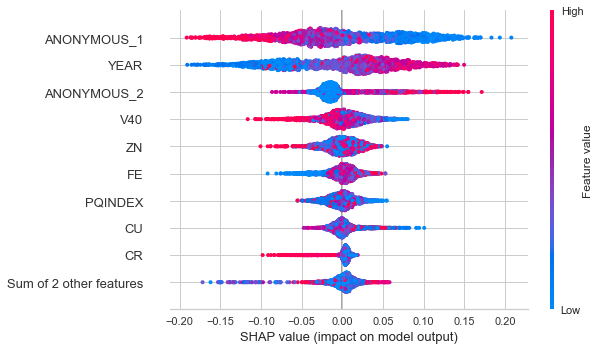

In [104]:
explainer_lgbm = shap.Explainer(clf_lgbm2)
shap_values_lgbm = explainer_lgbm(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [105]:
fi_lgbm = pd.DataFrame(clf_lgbm2.feature_importances_, index=X_train2.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                     3650
V40                             2981
ZN                              2749
FE                              2637
PQINDEX                         2229
YEAR                            2104
CU                              2013
ANONYMOUS_2                     1302
MO                              1166
CR                               589
NI                               368

In [106]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.167523
V40                         0.136818
ZN                          0.126170
FE                          0.121030
PQINDEX                     0.102304
YEAR                        0.096567
CU                          0.092390
ANONYMOUS_2                 0.059758
MO                          0.053516
CR                          0.027033
NI                          0.016890

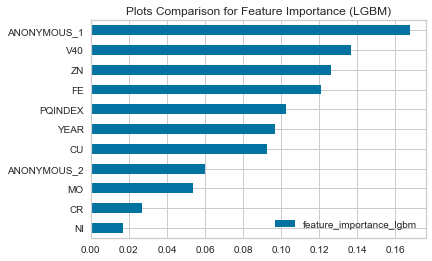

In [107]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [108]:
def objectiveCB(trial, X, y):
    
    param = {
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'max_depth':trial.suggest_int('max_depth',3,13),
        'random_state': 42,
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = CatBoostRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [109]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train2, y_train2), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-11 19:46:41,085] A new study created in memory with name: no-name-42c4e8b2-53d5-4034-b301-5c4611df0692
[I 2022-12-11 19:47:52,784] Trial 0 finished with value: 0.29825394203105043 and parameters: {'l2_leaf_reg': 0.4098231406098498, 'max_bin': 338, 'learning_rate': 0.013812522503035869, 'n_estimators': 208, 'max_depth': 11, 'min_data_in_leaf': 289}. Best is trial 0 with value: 0.29825394203105043.
[I 2022-12-11 19:50:43,110] Trial 1 finished with value: 0.2984670397096884 and parameters: {'l2_leaf_reg': 0.028890725133250705, 'max_bin': 204, 'learning_rate': 0.01367201180219264, 'n_estimators': 359, 'max_depth': 13, 'min_data_in_leaf': 61}. Best is trial 0 with value: 0.29825394203105043.
[I 2022-12-11 19:50:44,192] Trial 2 finished with value: 0.30951285302370024 and parameters: {'l2_leaf_reg': 0.032008669606599004, 'max_bin': 329, 'learning_rate': 0.01601415033729662, 'n_estimators': 86, 'max_depth': 5, 'min_data_in_leaf': 226}. Best is trial 0 with value: 0.2982539420310504

[I 2022-12-11 20:04:23,146] Trial 26 finished with value: 0.294333464871536 and parameters: {'l2_leaf_reg': 0.01822685653285454, 'max_bin': 378, 'learning_rate': 0.012612056560700406, 'n_estimators': 459, 'max_depth': 8, 'min_data_in_leaf': 106}. Best is trial 13 with value: 0.29364379118425815.
[I 2022-12-11 20:04:37,865] Trial 27 finished with value: 0.29374762565275453 and parameters: {'l2_leaf_reg': 0.017143929997760526, 'max_bin': 380, 'learning_rate': 0.013208803915439844, 'n_estimators': 466, 'max_depth': 8, 'min_data_in_leaf': 112}. Best is trial 13 with value: 0.29364379118425815.
[I 2022-12-11 20:04:42,736] Trial 28 finished with value: 0.295098827254153 and parameters: {'l2_leaf_reg': 0.054359654125354845, 'max_bin': 347, 'learning_rate': 0.014472833571633249, 'n_estimators': 386, 'max_depth': 6, 'min_data_in_leaf': 166}. Best is trial 13 with value: 0.29364379118425815.
[I 2022-12-11 20:04:55,870] Trial 29 finished with value: 0.2934617892951819 and parameters: {'l2_leaf_re

[I 2022-12-11 20:12:09,348] Trial 53 finished with value: 0.29322334268313294 and parameters: {'l2_leaf_reg': 0.35933520304024374, 'max_bin': 336, 'learning_rate': 0.01586755632701325, 'n_estimators': 462, 'max_depth': 6, 'min_data_in_leaf': 135}. Best is trial 37 with value: 0.29277920970028104.
[I 2022-12-11 20:12:13,414] Trial 54 finished with value: 0.29493277551209973 and parameters: {'l2_leaf_reg': 0.3885743382261693, 'max_bin': 347, 'learning_rate': 0.01593024373891596, 'n_estimators': 464, 'max_depth': 5, 'min_data_in_leaf': 133}. Best is trial 37 with value: 0.29277920970028104.
[I 2022-12-11 20:12:16,484] Trial 55 finished with value: 0.2963288625551024 and parameters: {'l2_leaf_reg': 0.5316944540043105, 'max_bin': 392, 'learning_rate': 0.01589287973147875, 'n_estimators': 433, 'max_depth': 4, 'min_data_in_leaf': 97}. Best is trial 37 with value: 0.29277920970028104.
[I 2022-12-11 20:12:39,219] Trial 56 finished with value: 0.2931285655808236 and parameters: {'l2_leaf_reg': 0

[I 2022-12-11 20:36:49,166] Trial 80 finished with value: 0.29825139217850005 and parameters: {'l2_leaf_reg': 0.16035791361924812, 'max_bin': 273, 'learning_rate': 0.015629039225835792, 'n_estimators': 169, 'max_depth': 10, 'min_data_in_leaf': 78}. Best is trial 73 with value: 0.29228585083853326.
[I 2022-12-11 20:38:27,346] Trial 81 finished with value: 0.2944447602542854 and parameters: {'l2_leaf_reg': 5.227423939443355, 'max_bin': 292, 'learning_rate': 0.016801960865827956, 'n_estimators': 415, 'max_depth': 11, 'min_data_in_leaf': 46}. Best is trial 73 with value: 0.29228585083853326.
[I 2022-12-11 20:39:57,428] Trial 82 finished with value: 0.2936287707885991 and parameters: {'l2_leaf_reg': 3.374565173567627, 'max_bin': 296, 'learning_rate': 0.01763270708885313, 'n_estimators': 453, 'max_depth': 11, 'min_data_in_leaf': 29}. Best is trial 73 with value: 0.29228585083853326.
[I 2022-12-11 20:40:57,085] Trial 83 finished with value: 0.29403353162983953 and parameters: {'l2_leaf_reg': 

study.best_params: 0.29228585083853326
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.3216749434347217, 'max_bin': 284, 'learning_rate': 0.017070446705175116, 'n_estimators': 429, 'max_depth': 10, 'min_data_in_leaf': 18}
study.best_params: {'l2_leaf_reg': 0.3216749434347217, 'max_bin': 284, 'learning_rate': 0.017070446705175116, 'n_estimators': 429, 'max_depth': 10, 'min_data_in_leaf': 18}


In [110]:
param_cat = studyCB.best_params

clf_cat2 = CatBoostRegressor(**param_cat, random_state=42)

In [111]:
clf_cat2.fit(X_train2, y_train2.Score_0)

pred_test_cat = clf_cat2.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3800823	total: 30ms	remaining: 12.8s
1:	learn: 0.3790290	total: 60.3ms	remaining: 12.9s
2:	learn: 0.3780655	total: 89.7ms	remaining: 12.7s
3:	learn: 0.3774808	total: 121ms	remaining: 12.9s
4:	learn: 0.3767384	total: 155ms	remaining: 13.2s
5:	learn: 0.3759054	total: 184ms	remaining: 13s
6:	learn: 0.3749625	total: 212ms	remaining: 12.8s
7:	learn: 0.3740627	total: 243ms	remaining: 12.8s
8:	learn: 0.3733523	total: 272ms	remaining: 12.7s
9:	learn: 0.3725620	total: 301ms	remaining: 12.6s
10:	learn: 0.3717975	total: 331ms	remaining: 12.6s
11:	learn: 0.3710033	total: 358ms	remaining: 12.5s
12:	learn: 0.3703541	total: 387ms	remaining: 12.4s
13:	learn: 0.3695681	total: 417ms	remaining: 12.4s
14:	learn: 0.3687376	total: 446ms	remaining: 12.3s
15:	learn: 0.3680413	total: 474ms	remaining: 12.2s
16:	learn: 0.3673929	total: 497ms	remaining: 12s
17:	learn: 0.3666302	total: 524ms	remaining: 12s
18:	learn: 0.3658049	total: 549ms	remaining: 11.8s
19:	learn: 0.3652363	total: 573ms	remaining: 1

166:	learn: 0.3116027	total: 4.61s	remaining: 7.23s
167:	learn: 0.3114804	total: 4.63s	remaining: 7.2s
168:	learn: 0.3112925	total: 4.67s	remaining: 7.18s
169:	learn: 0.3110760	total: 4.69s	remaining: 7.14s
170:	learn: 0.3106283	total: 4.71s	remaining: 7.12s
171:	learn: 0.3103312	total: 4.74s	remaining: 7.08s
172:	learn: 0.3100701	total: 4.77s	remaining: 7.06s
173:	learn: 0.3097510	total: 4.8s	remaining: 7.03s
174:	learn: 0.3094924	total: 4.83s	remaining: 7.01s
175:	learn: 0.3092795	total: 4.85s	remaining: 6.98s
176:	learn: 0.3091175	total: 4.88s	remaining: 6.95s
177:	learn: 0.3086995	total: 4.9s	remaining: 6.91s
178:	learn: 0.3085568	total: 4.93s	remaining: 6.88s
179:	learn: 0.3083080	total: 4.95s	remaining: 6.85s
180:	learn: 0.3079567	total: 4.98s	remaining: 6.82s
181:	learn: 0.3075576	total: 5s	remaining: 6.79s
182:	learn: 0.3072979	total: 5.04s	remaining: 6.77s
183:	learn: 0.3070171	total: 5.07s	remaining: 6.75s
184:	learn: 0.3067333	total: 5.1s	remaining: 6.72s
185:	learn: 0.30663

330:	learn: 0.2778340	total: 9.35s	remaining: 2.77s
331:	learn: 0.2777194	total: 9.38s	remaining: 2.74s
332:	learn: 0.2776763	total: 9.41s	remaining: 2.71s
333:	learn: 0.2775859	total: 9.44s	remaining: 2.68s
334:	learn: 0.2774442	total: 9.47s	remaining: 2.66s
335:	learn: 0.2771812	total: 9.5s	remaining: 2.63s
336:	learn: 0.2771182	total: 9.52s	remaining: 2.6s
337:	learn: 0.2768933	total: 9.55s	remaining: 2.57s
338:	learn: 0.2767255	total: 9.58s	remaining: 2.54s
339:	learn: 0.2764842	total: 9.6s	remaining: 2.51s
340:	learn: 0.2763381	total: 9.63s	remaining: 2.48s
341:	learn: 0.2760241	total: 9.65s	remaining: 2.46s
342:	learn: 0.2758689	total: 9.68s	remaining: 2.43s
343:	learn: 0.2757884	total: 9.71s	remaining: 2.4s
344:	learn: 0.2754987	total: 9.73s	remaining: 2.37s
345:	learn: 0.2753750	total: 9.75s	remaining: 2.34s
346:	learn: 0.2752533	total: 9.78s	remaining: 2.31s
347:	learn: 0.2751437	total: 9.81s	remaining: 2.28s
348:	learn: 0.2750577	total: 9.83s	remaining: 2.25s
349:	learn: 0.27

In [112]:
optuna.visualization.plot_param_importances(studyCB)

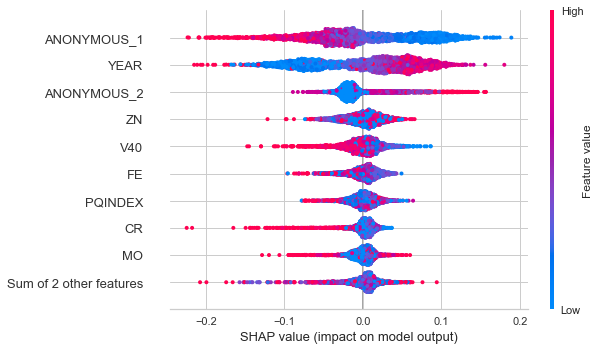

In [113]:
explainer_cat = shap.Explainer(clf_cat2)
shap_values_cat = explainer_cat(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [114]:
fi_cat = pd.DataFrame(clf_cat2.feature_importances_, index=X_train2.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
ANONYMOUS_1               16.924892
YEAR                      16.113086
ZN                         9.326573
V40                        8.886455
ANONYMOUS_2                8.713661
FE                         8.659980
PQINDEX                    7.985545
CU                         7.694537
CR                         6.245494
MO                         6.129509
NI                         3.320267

In [115]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
ANONYMOUS_1                0.169249
YEAR                       0.161131
ZN                         0.093266
V40                        0.088865
ANONYMOUS_2                0.087137
FE                         0.086600
PQINDEX                    0.079855
CU                         0.076945
CR                         0.062455
MO                         0.061295
NI                         0.033203

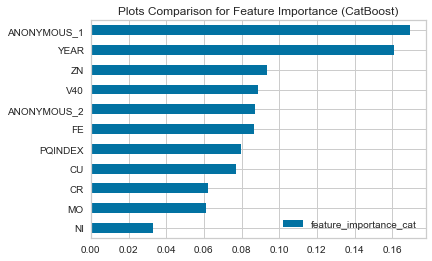

In [116]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [117]:
def objectiveET(trial, X, y):
    
    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = ExtraTreesRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [118]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train2, y_train2), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-11 20:51:40,777] A new study created in memory with name: no-name-21bb12e2-dab0-4257-8ef2-e1ca36c905ae
[I 2022-12-11 20:51:42,955] Trial 0 finished with value: 0.299910593819589 and parameters: {'max_depth': 6, 'max_leaf_nodes': 139, 'n_estimators': 249}. Best is trial 0 with value: 0.299910593819589.
[I 2022-12-11 20:51:49,951] Trial 1 finished with value: 0.2905505752887275 and parameters: {'max_depth': 12, 'max_leaf_nodes': 931, 'n_estimators': 399}. Best is trial 1 with value: 0.2905505752887275.
[I 2022-12-11 20:51:52,565] Trial 2 finished with value: 0.29428843810000826 and parameters: {'max_depth': 8, 'max_leaf_nodes': 182, 'n_estimators': 269}. Best is trial 1 with value: 0.2905505752887275.
[I 2022-12-11 20:51:54,699] Trial 3 finished with value: 0.30373619890704195 and parameters: {'max_depth': 5, 'max_leaf_nodes': 240, 'n_estimators': 325}. Best is trial 1 with value: 0.2905505752887275.
[I 2022-12-11 20:51:56,005] Trial 4 finished with value: 0.2997801287639065 a

[I 2022-12-11 20:53:23,747] Trial 38 finished with value: 0.31338885113855686 and parameters: {'max_depth': 3, 'max_leaf_nodes': 965, 'n_estimators': 366}. Best is trial 27 with value: 0.29005691111033416.
[I 2022-12-11 20:53:27,005] Trial 39 finished with value: 0.29009917740565616 and parameters: {'max_depth': 13, 'max_leaf_nodes': 773, 'n_estimators': 145}. Best is trial 27 with value: 0.29005691111033416.
[I 2022-12-11 20:53:30,966] Trial 40 finished with value: 0.2903582601431415 and parameters: {'max_depth': 12, 'max_leaf_nodes': 623, 'n_estimators': 186}. Best is trial 27 with value: 0.29005691111033416.
[I 2022-12-11 20:53:35,057] Trial 41 finished with value: 0.2901153361884535 and parameters: {'max_depth': 13, 'max_leaf_nodes': 777, 'n_estimators': 147}. Best is trial 27 with value: 0.29005691111033416.
[I 2022-12-11 20:53:37,818] Trial 42 finished with value: 0.2897773533848517 and parameters: {'max_depth': 13, 'max_leaf_nodes': 706, 'n_estimators': 107}. Best is trial 42 wi

[I 2022-12-11 20:54:49,512] Trial 76 finished with value: 0.28971620370814455 and parameters: {'max_depth': 12, 'max_leaf_nodes': 342, 'n_estimators': 153}. Best is trial 74 with value: 0.28899698487973197.
[I 2022-12-11 20:54:51,297] Trial 77 finished with value: 0.2912119138871018 and parameters: {'max_depth': 10, 'max_leaf_nodes': 277, 'n_estimators': 136}. Best is trial 74 with value: 0.28899698487973197.
[I 2022-12-11 20:54:52,768] Trial 78 finished with value: 0.2899405754731009 and parameters: {'max_depth': 13, 'max_leaf_nodes': 214, 'n_estimators': 101}. Best is trial 74 with value: 0.28899698487973197.
[I 2022-12-11 20:54:54,062] Trial 79 finished with value: 0.2892923552036334 and parameters: {'max_depth': 13, 'max_leaf_nodes': 321, 'n_estimators': 83}. Best is trial 74 with value: 0.28899698487973197.
[I 2022-12-11 20:54:55,301] Trial 80 finished with value: 0.2899333929647547 and parameters: {'max_depth': 12, 'max_leaf_nodes': 323, 'n_estimators': 84}. Best is trial 74 with

study.best_params: 0.28899698487973197
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 298, 'n_estimators': 99}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 298, 'n_estimators': 99}


In [119]:
param_et = studyET.best_params

clf_et2 = ExtraTreesRegressor(**param_et, random_state=42)

In [120]:
clf_et2.fit(X_train2, y_train2.Score_0)

pred_test_et = clf_et2.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.2221
F1 Score : 0.2559
Macro F1 Score : 0.588 

[[2342  182]
 [ 225   70]]


In [121]:
optuna.visualization.plot_param_importances(studyET)

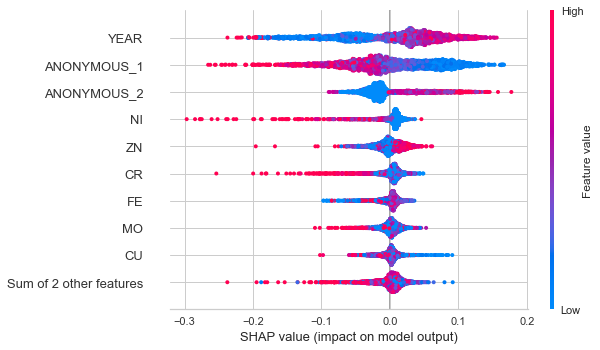

In [122]:
explainer_et = shap.Explainer(clf_et2)
shap_values_et = explainer_et(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [123]:
fi_et = pd.DataFrame(clf_et2.feature_importances_, index=X_train2.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.176843
YEAR                      0.162887
FE                        0.080686
V40                       0.077976
CR                        0.077767
CU                        0.077263
ZN                        0.073077
PQINDEX                   0.071930
ANONYMOUS_2               0.070770
MO                        0.068832
NI                        0.061969

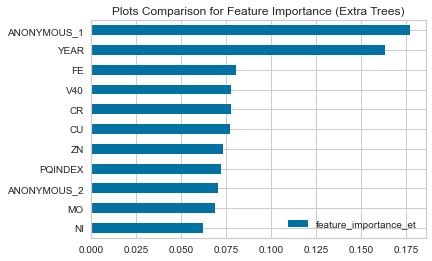

In [124]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Dataset 3

### Decision Tree

In [125]:
def objectiveDT(trial, X, y):
    
    param = {
    'criterion': trial.suggest_categorical('criterion',['mae']),
    'splitter': trial.suggest_categorical('splitter',['best','random']),
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = DecisionTreeRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [126]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train3, y_train3), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-11 20:55:57,785] A new study created in memory with name: no-name-28863a7f-c71a-4130-a3a8-ae4db5a303ec
[I 2022-12-11 20:55:58,748] Trial 0 finished with value: 0.24547175131348514 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 8, 'max_leaf_nodes': 202}. Best is trial 0 with value: 0.24547175131348514.
[I 2022-12-11 20:56:00,391] Trial 1 finished with value: 0.2366226970227671 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 6, 'max_leaf_nodes': 714}. Best is trial 1 with value: 0.2366226970227671.
[I 2022-12-11 20:56:02,027] Trial 2 finished with value: 0.2366226970227671 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 6, 'max_leaf_nodes': 783}. Best is trial 1 with value: 0.2366226970227671.
[I 2022-12-11 20:56:02,792] Trial 3 finished with value: 0.26701194395796846 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 12, 'max_leaf_nodes': 299}. Best is trial 1 with value: 0.236622697022

[I 2022-12-11 20:56:38,891] Trial 35 finished with value: 0.23767593695271452 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 5, 'max_leaf_nodes': 186}. Best is trial 6 with value: 0.2348107180385289.
[I 2022-12-11 20:56:39,710] Trial 36 finished with value: 0.23821210157618214 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 6, 'max_leaf_nodes': 85}. Best is trial 6 with value: 0.2348107180385289.
[I 2022-12-11 20:56:40,406] Trial 37 finished with value: 0.2348107180385289 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 4, 'max_leaf_nodes': 112}. Best is trial 6 with value: 0.2348107180385289.
[I 2022-12-11 20:56:40,983] Trial 38 finished with value: 0.23846211908931697 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 3, 'max_leaf_nodes': 179}. Best is trial 6 with value: 0.2348107180385289.
[I 2022-12-11 20:56:41,779] Trial 39 finished with value: 0.23821210157618214 and parameters: {'criter

[I 2022-12-11 20:57:03,588] Trial 70 finished with value: 0.23767593695271452 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 5, 'max_leaf_nodes': 254}. Best is trial 6 with value: 0.2348107180385289.
[I 2022-12-11 20:57:04,188] Trial 71 finished with value: 0.2348107180385289 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 4, 'max_leaf_nodes': 318}. Best is trial 6 with value: 0.2348107180385289.
[I 2022-12-11 20:57:04,700] Trial 72 finished with value: 0.23846211908931697 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 3, 'max_leaf_nodes': 264}. Best is trial 6 with value: 0.2348107180385289.
[I 2022-12-11 20:57:05,302] Trial 73 finished with value: 0.2348107180385289 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 4, 'max_leaf_nodes': 118}. Best is trial 6 with value: 0.2348107180385289.
[I 2022-12-11 20:57:05,982] Trial 74 finished with value: 0.23767593695271452 and parameters: {'criter

study.best_params: 0.2348107180385289
Number of finished trials: 100
Best trial: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 4, 'max_leaf_nodes': 516}
study.best_params: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 4, 'max_leaf_nodes': 516}


In [127]:
param_dt = studyDT.best_params

clf_dt3 = DecisionTreeRegressor(**param_dt, random_state=42)

In [128]:
clf_dt3.fit(X_train3, y_train3.Score_0)

pred_test_dt = clf_dt3.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.0817
F1 Score : 0.0305
Macro F1 Score : 0.4916 

[[2561  248]
 [   6    4]]


In [129]:
optuna.visualization.plot_param_importances(studyDT)

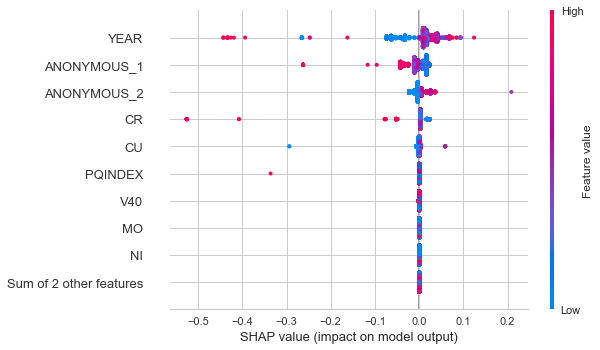

In [130]:
explainer_dt = shap.Explainer(clf_dt3)
shap_values_dt = explainer_dt(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [131]:
fi_dt = pd.DataFrame(clf_dt3.feature_importances_, index=X_train3.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
YEAR                      0.510350
ANONYMOUS_1               0.209343
CR                        0.128287
ANONYMOUS_2               0.070850
CU                        0.059925
PQINDEX                   0.019667
V40                       0.001577
FE                        0.000000
ZN                        0.000000
NI                        0.000000
MO                        0.000000

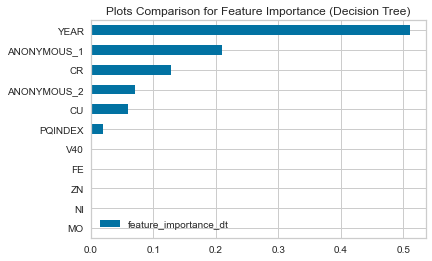

In [132]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [133]:
def objectiveSVR(trial, X, y):
    
    param = {
        'C': trial.suggest_loguniform('C', 0.3, 10.0),
        'degree': trial.suggest_int('degree', 2, 7),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 0.01),
        'epsilon': trial.suggest_float('epsilon', 0.05, 0.5),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = SVR(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [134]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train3, y_train3), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-11 20:57:23,736] A new study created in memory with name: no-name-b21ed797-83e7-4ccd-a01e-c8afdbb5a8fc
[I 2022-12-11 20:57:26,289] Trial 0 finished with value: 0.3221368629518716 and parameters: {'C': 5.778208561723265, 'degree': 6, 'gamma': 0.006088274819762348, 'epsilon': 0.1997798185393293}. Best is trial 0 with value: 0.3221368629518716.
[I 2022-12-11 20:57:28,272] Trial 1 finished with value: 0.3334825479900152 and parameters: {'C': 1.3662694900538475, 'degree': 3, 'gamma': 0.004735041274972773, 'epsilon': 0.2509713703676945}. Best is trial 0 with value: 0.3221368629518716.
[I 2022-12-11 20:57:30,432] Trial 2 finished with value: 0.29673436262989933 and parameters: {'C': 0.6080359136908335, 'degree': 6, 'gamma': 0.008112459801721966, 'epsilon': 0.1514129941764692}. Best is trial 2 with value: 0.29673436262989933.
[I 2022-12-11 20:57:32,591] Trial 3 finished with value: 0.2877021767443776 and parameters: {'C': 1.9164489773455118, 'degree': 4, 'gamma': 0.00268349883221605

[I 2022-12-11 20:58:33,345] Trial 32 finished with value: 0.2552735484126868 and parameters: {'C': 2.9560973706031617, 'degree': 3, 'gamma': 0.0011108297893199645, 'epsilon': 0.051752776117080665}. Best is trial 12 with value: 0.2548712360293969.
[I 2022-12-11 20:58:35,409] Trial 33 finished with value: 0.265467698051156 and parameters: {'C': 2.5595157574899985, 'degree': 3, 'gamma': 0.0012325049860596876, 'epsilon': 0.08528087235523903}. Best is trial 12 with value: 0.2548712360293969.
[I 2022-12-11 20:58:37,766] Trial 34 finished with value: 0.2538403098095251 and parameters: {'C': 1.5260774301796696, 'degree': 3, 'gamma': 0.0014167839942513386, 'epsilon': 0.0501149108202536}. Best is trial 34 with value: 0.2538403098095251.
[I 2022-12-11 20:58:39,775] Trial 35 finished with value: 0.28752062540008116 and parameters: {'C': 1.4681024906006614, 'degree': 3, 'gamma': 0.0014148828166377372, 'epsilon': 0.1455204017650225}. Best is trial 34 with value: 0.2538403098095251.
[I 2022-12-11 20:

[I 2022-12-11 20:59:45,795] Trial 64 finished with value: 0.27416165423970396 and parameters: {'C': 3.321777162354671, 'degree': 2, 'gamma': 0.0012935158180692817, 'epsilon': 0.10888642987391917}. Best is trial 59 with value: 0.25271569734028876.
[I 2022-12-11 20:59:48,183] Trial 65 finished with value: 0.25612476920875293 and parameters: {'C': 1.4441053481433088, 'degree': 2, 'gamma': 0.0011688273023895178, 'epsilon': 0.06260103903749456}. Best is trial 59 with value: 0.25271569734028876.
[I 2022-12-11 20:59:50,508] Trial 66 finished with value: 0.2578881874255049 and parameters: {'C': 1.3529745585830653, 'degree': 2, 'gamma': 0.0011535369660245671, 'epsilon': 0.0686863065354936}. Best is trial 59 with value: 0.25271569734028876.
[I 2022-12-11 20:59:52,835] Trial 67 finished with value: 0.26424911423438746 and parameters: {'C': 1.0595473854070028, 'degree': 2, 'gamma': 0.0010719555048144499, 'epsilon': 0.08871648683796256}. Best is trial 59 with value: 0.25271569734028876.
[I 2022-12-

[I 2022-12-11 21:00:51,305] Trial 96 finished with value: 0.25795228986821844 and parameters: {'C': 0.4469141769957868, 'degree': 2, 'gamma': 0.0012371643745231983, 'epsilon': 0.07363652190413147}. Best is trial 81 with value: 0.24970882553654788.
[I 2022-12-11 21:00:53,029] Trial 97 finished with value: 0.25252249123187115 and parameters: {'C': 0.3827988146942911, 'degree': 2, 'gamma': 0.0011114765230224304, 'epsilon': 0.059598334529525135}. Best is trial 81 with value: 0.24970882553654788.
[I 2022-12-11 21:00:54,800] Trial 98 finished with value: 0.2493906253902552 and parameters: {'C': 0.3827927190523177, 'degree': 2, 'gamma': 0.0011230819708625528, 'epsilon': 0.05005056543218382}. Best is trial 98 with value: 0.2493906253902552.
[I 2022-12-11 21:00:56,470] Trial 99 finished with value: 0.2614686919166874 and parameters: {'C': 0.375515263867078, 'degree': 2, 'gamma': 0.0011012092757336838, 'epsilon': 0.0842891844930391}. Best is trial 98 with value: 0.2493906253902552.


study.best_params: 0.2493906253902552
Number of finished trials: 100
Best trial: {'C': 0.3827927190523177, 'degree': 2, 'gamma': 0.0011230819708625528, 'epsilon': 0.05005056543218382}
study.best_params: {'C': 0.3827927190523177, 'degree': 2, 'gamma': 0.0011230819708625528, 'epsilon': 0.05005056543218382}


In [135]:
param_svr = studySVR.best_params

clf_svr3 = SVR(**param_svr)

In [136]:
clf_svr3.fit(X_train3, y_train3.Score_0)

pred_test_svr = clf_svr3.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.1085
F1 Score : 0.0155
Macro F1 Score : 0.4841 

[[2563  250]
 [   4    2]]


In [137]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [138]:
def objectiveRF(trial, X, y):

    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),  # max_depth 제한
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),  # n_estimators 제한
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = RandomForestRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [139]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train3, y_train3), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-11 21:00:59,024] A new study created in memory with name: no-name-66c90c5b-0255-41f5-b9dc-dc36467378ec
[I 2022-12-11 21:01:09,912] Trial 0 finished with value: 0.2929931218722828 and parameters: {'max_depth': 9, 'max_leaf_nodes': 578, 'n_estimators': 347}. Best is trial 0 with value: 0.2929931218722828.
[I 2022-12-11 21:01:23,042] Trial 1 finished with value: 0.2932858028666353 and parameters: {'max_depth': 10, 'max_leaf_nodes': 508, 'n_estimators': 381}. Best is trial 0 with value: 0.2929931218722828.
[I 2022-12-11 21:01:26,001] Trial 2 finished with value: 0.2980878402589534 and parameters: {'max_depth': 4, 'max_leaf_nodes': 332, 'n_estimators': 177}. Best is trial 0 with value: 0.2929931218722828.
[I 2022-12-11 21:01:27,008] Trial 3 finished with value: 0.30149518101755024 and parameters: {'max_depth': 7, 'max_leaf_nodes': 8, 'n_estimators': 60}. Best is trial 0 with value: 0.2929931218722828.
[I 2022-12-11 21:01:32,807] Trial 4 finished with value: 0.2957309043981609 and

[I 2022-12-11 21:07:11,240] Trial 38 finished with value: 0.2931492869807214 and parameters: {'max_depth': 11, 'max_leaf_nodes': 50, 'n_estimators': 369}. Best is trial 32 with value: 0.2918998676907406.
[I 2022-12-11 21:07:19,965] Trial 39 finished with value: 0.29178440788002613 and parameters: {'max_depth': 11, 'max_leaf_nodes': 139, 'n_estimators': 278}. Best is trial 39 with value: 0.29178440788002613.
[I 2022-12-11 21:07:32,906] Trial 40 finished with value: 0.29450002894792054 and parameters: {'max_depth': 12, 'max_leaf_nodes': 385, 'n_estimators': 330}. Best is trial 39 with value: 0.29178440788002613.
[I 2022-12-11 21:07:41,643] Trial 41 finished with value: 0.2918799440744616 and parameters: {'max_depth': 10, 'max_leaf_nodes': 108, 'n_estimators': 281}. Best is trial 39 with value: 0.29178440788002613.
[I 2022-12-11 21:07:50,963] Trial 42 finished with value: 0.2917060297778876 and parameters: {'max_depth': 11, 'max_leaf_nodes': 125, 'n_estimators': 290}. Best is trial 42 wit

[I 2022-12-11 21:13:06,485] Trial 76 finished with value: 0.29241312179578693 and parameters: {'max_depth': 12, 'max_leaf_nodes': 178, 'n_estimators': 339}. Best is trial 42 with value: 0.2917060297778876.
[I 2022-12-11 21:13:13,980] Trial 77 finished with value: 0.29199991975576334 and parameters: {'max_depth': 11, 'max_leaf_nodes': 136, 'n_estimators': 231}. Best is trial 42 with value: 0.2917060297778876.
[I 2022-12-11 21:13:23,000] Trial 78 finished with value: 0.2927997142424615 and parameters: {'max_depth': 9, 'max_leaf_nodes': 276, 'n_estimators': 285}. Best is trial 42 with value: 0.2917060297778876.
[I 2022-12-11 21:13:28,620] Trial 79 finished with value: 0.29253617963923506 and parameters: {'max_depth': 12, 'max_leaf_nodes': 98, 'n_estimators': 189}. Best is trial 42 with value: 0.2917060297778876.
[I 2022-12-11 21:13:36,028] Trial 80 finished with value: 0.29471901596476874 and parameters: {'max_depth': 11, 'max_leaf_nodes': 31, 'n_estimators': 303}. Best is trial 42 with v

study.best_params: 0.29168419099677256
Number of finished trials: 100
Best trial: {'max_depth': 11, 'max_leaf_nodes': 130, 'n_estimators': 288}
study.best_params: {'max_depth': 11, 'max_leaf_nodes': 130, 'n_estimators': 288}


In [140]:
param_rf = studyRF.best_params

clf_rf3 = RandomForestRegressor(**param_rf, random_state=42)

In [141]:
clf_rf3.fit(X_train3, y_train3.Score_0)

pred_test_rf = clf_rf3.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.2155
F1 Score : 0.2418
Macro F1 Score : 0.585 

[[2390  193]
 [ 177   59]]


In [142]:
optuna.visualization.plot_param_importances(studyRF)

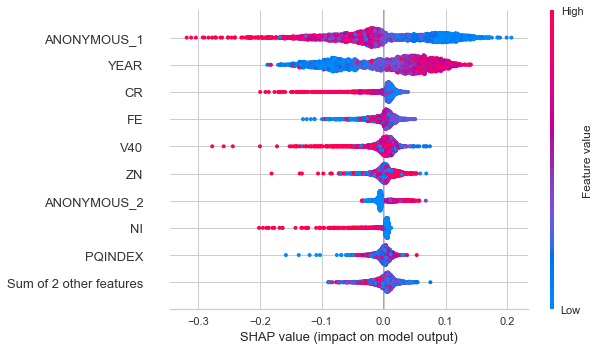

In [143]:
explainer_rf = shap.Explainer(clf_rf3)
shap_values_rf = explainer_rf(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [144]:
fi_rf = pd.DataFrame(clf_rf3.feature_importances_, index=X_train3.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.220166
YEAR                      0.119134
V40                       0.117903
ZN                        0.107290
FE                        0.096697
PQINDEX                   0.087960
CU                        0.071119
CR                        0.061840
MO                        0.050724
ANONYMOUS_2               0.036159
NI                        0.031009

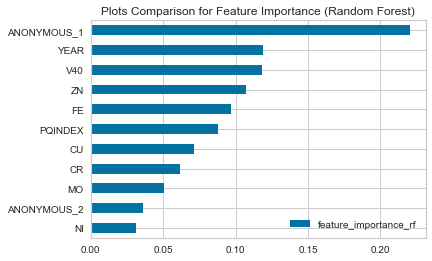

In [145]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [146]:
def objectiveXGB(trial, X, y):

    param = {
    'verbosity':1,
    'objective': trial.suggest_categorical('objective',['reg:squarederror']),
    'max_depth':trial.suggest_int('max_depth',3,13),  # 데이터 수가 적어 3~13으로 제한
    'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'subsample':trial.suggest_loguniform('subsample',0.7,1),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 300 ),
    'alpha': trial.suggest_loguniform( 'alpha', 1e-3, 10.0),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [147]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train3, y_train3), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-11 21:16:57,791] A new study created in memory with name: no-name-20cabd68-9295-4e44-b603-cecded317bd6
[I 2022-12-11 21:17:01,357] Trial 0 finished with value: 0.43986299506928994 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 2.369958467314723e-05, 'n_estimators': 227, 'subsample': 0.8735867280699666, 'min_child_weight': 20, 'alpha': 0.01658714110107691}. Best is trial 0 with value: 0.43986299506928994.
[I 2022-12-11 21:17:02,484] Trial 1 finished with value: 0.4405826163668891 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 4.2009086572476075e-06, 'n_estimators': 96, 'subsample': 0.7521550957613753, 'min_child_weight': 22, 'alpha': 1.839560919206394}. Best is trial 0 with value: 0.43986299506928994.
[I 2022-12-11 21:17:03,934] Trial 2 finished with value: 0.4403196276362764 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 1.3732020512011938e-05, 'n_estimators': 168, 's

[I 2022-12-11 21:18:20,501] Trial 23 finished with value: 0.30458231707703215 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.009316591654040791, 'n_estimators': 481, 'subsample': 0.7301560222067722, 'min_child_weight': 177, 'alpha': 0.002588525619408348}. Best is trial 23 with value: 0.30458231707703215.
[I 2022-12-11 21:18:26,663] Trial 24 finished with value: 0.4086475488819382 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.000581442761481307, 'n_estimators': 450, 'subsample': 0.7315431933276426, 'min_child_weight': 169, 'alpha': 0.0022191798143813336}. Best is trial 23 with value: 0.30458231707703215.
[I 2022-12-11 21:18:33,846] Trial 25 finished with value: 0.34162019913835406 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.0029945065081809843, 'n_estimators': 393, 'subsample': 0.7284162697636758, 'min_child_weight': 69, 'alpha': 0.002349517762110436}. Best is trial 2

[I 2022-12-11 21:20:06,580] Trial 46 finished with value: 0.31720763512993866 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.005053395407023041, 'n_estimators': 451, 'subsample': 0.8098014371506106, 'min_child_weight': 230, 'alpha': 0.9328850357861302}. Best is trial 23 with value: 0.30458231707703215.
[I 2022-12-11 21:20:13,576] Trial 47 finished with value: 0.4171195096031797 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.0005049527576733493, 'n_estimators': 353, 'subsample': 0.799898706009371, 'min_child_weight': 13, 'alpha': 0.10640409286416268}. Best is trial 23 with value: 0.30458231707703215.
[I 2022-12-11 21:20:18,026] Trial 48 finished with value: 0.440413549065498 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 3.749109939900314e-06, 'n_estimators': 431, 'subsample': 0.9377261524993967, 'min_child_weight': 146, 'alpha': 0.3207674959105217}. Best is trial 23 with v

[I 2022-12-11 21:22:02,531] Trial 70 finished with value: 0.30556793016249995 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.007384374267638207, 'n_estimators': 500, 'subsample': 0.7314709228849088, 'min_child_weight': 197, 'alpha': 0.0018505497990478582}. Best is trial 64 with value: 0.30281903707434127.
[I 2022-12-11 21:22:07,717] Trial 71 finished with value: 0.30500714455796624 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.009785994720285322, 'n_estimators': 466, 'subsample': 0.7643324787394425, 'min_child_weight': 209, 'alpha': 0.16524248448745368}. Best is trial 64 with value: 0.30281903707434127.
[I 2022-12-11 21:22:13,129] Trial 72 finished with value: 0.3203320980618171 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.004365598705728774, 'n_estimators': 469, 'subsample': 0.7644337626589269, 'min_child_weight': 210, 'alpha': 0.26168323653219}. Best is trial 64 wit

[I 2022-12-11 21:23:40,381] Trial 93 finished with value: 0.3148719564186003 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.005393175332017129, 'n_estimators': 411, 'subsample': 0.8968695392039978, 'min_child_weight': 176, 'alpha': 0.07158171941619469}. Best is trial 64 with value: 0.30281903707434127.
[I 2022-12-11 21:23:45,167] Trial 94 finished with value: 0.30368098481998346 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.009746881547272622, 'n_estimators': 435, 'subsample': 0.7567584055745611, 'min_child_weight': 104, 'alpha': 0.056067727836549446}. Best is trial 64 with value: 0.30281903707434127.
[I 2022-12-11 21:23:50,357] Trial 95 finished with value: 0.30497254165235205 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.007229275561847968, 'n_estimators': 435, 'subsample': 0.7601743247557704, 'min_child_weight': 132, 'alpha': 0.054253432818455606}. Best is trial 64 

study.best_params: 0.30281903707434127
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.009779519262957902, 'n_estimators': 486, 'subsample': 0.7633304595254295, 'min_child_weight': 175, 'alpha': 0.41428469341237717}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.009779519262957902, 'n_estimators': 486, 'subsample': 0.7633304595254295, 'min_child_weight': 175, 'alpha': 0.41428469341237717}


In [148]:
param_xgb = studyXGB.best_params

clf_xgb3 = xgb.XGBRegressor(**param_xgb, random_state=42)

In [149]:
clf_xgb3.fit(X_train3, y_train3.Score_0)

pred_test_xgb = clf_xgb3.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2278
F1 Score : 0.2168
Macro F1 Score : 0.5712 

[[2383  199]
 [ 184   53]]


In [150]:
optuna.visualization.plot_param_importances(studyXGB)

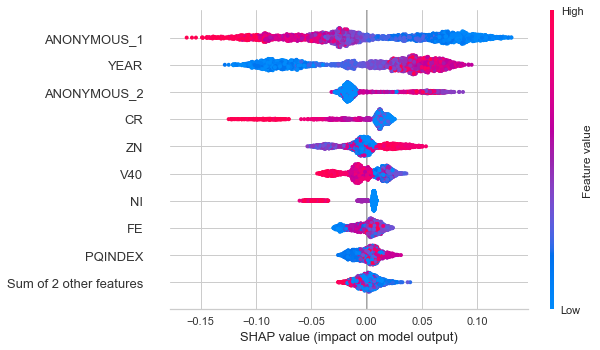

In [151]:
explainer_xgb = shap.Explainer(clf_xgb3)
shap_values_xgb = explainer_xgb(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [152]:
fi_xgb = pd.DataFrame(clf_xgb3.feature_importances_, index=X_train3.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
CR                         0.162024
NI                         0.147910
YEAR                       0.147080
ANONYMOUS_1                0.116554
ANONYMOUS_2                0.096380
V40                        0.058759
FE                         0.055737
ZN                         0.055100
PQINDEX                    0.054581
CU                         0.053261
MO                         0.052611

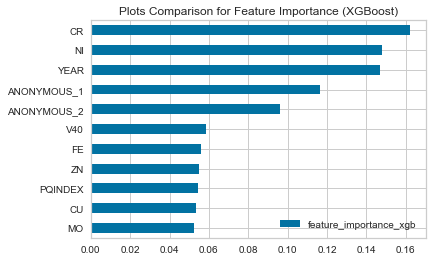

In [153]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
# plt.legend([])  # 범례 없애기
plt.show()

### LGBM

In [154]:
def objectiveLGBM(trial, X, y):

    param = {
        'metric': 'mae', 
        'random_state': 42,
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
#         'max_depth':trial.suggest_int('max_depth',3,30),
        'num_leaves' : trial.suggest_categorical('num_leaves', [8,16,32,64,128,256,512,1024]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [155]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train3, y_train3), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-11 21:24:18,896] A new study created in memory with name: no-name-49bf451a-da0a-4f04-a709-81b44a941d01
[I 2022-12-11 21:24:20,670] Trial 0 finished with value: 0.3106422470469114 and parameters: {'n_estimators': 324, 'reg_alpha': 0.024712754304839567, 'reg_lambda': 0.06684730902236061, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.003213594160833553, 'num_leaves': 64, 'min_child_samples': 74, 'min_data_per_groups': 81}. Best is trial 0 with value: 0.3106422470469114.
[I 2022-12-11 21:24:21,222] Trial 1 finished with value: 0.3258621123179166 and parameters: {'n_estimators': 141, 'reg_alpha': 0.032570806011699975, 'reg_lambda': 0.00323578794217895, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 3.729426190651722e-05, 'num_leaves': 256, 'min_child_samples': 146, 'min_data_per_groups': 83}. Best is trial 0 with value: 0.3106422470469114.
[I 2022-12-11 21:24:22,112] Trial 2 finished with value: 0.32590267237071757 and parameters: {'n_estimators': 294

[I 2022-12-11 21:25:33,014] Trial 21 finished with value: 0.30832214147456716 and parameters: {'n_estimators': 426, 'reg_alpha': 0.004056386073534714, 'reg_lambda': 0.007188366721166103, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.002510482950522338, 'num_leaves': 256, 'min_child_samples': 39, 'min_data_per_groups': 35}. Best is trial 10 with value: 0.29761728015843214.
[I 2022-12-11 21:25:37,017] Trial 22 finished with value: 0.2962611962202476 and parameters: {'n_estimators': 496, 'reg_alpha': 0.002904360108154819, 'reg_lambda': 0.003920175769900735, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.00666269480773411, 'num_leaves': 256, 'min_child_samples': 41, 'min_data_per_groups': 44}. Best is trial 22 with value: 0.2962611962202476.
[I 2022-12-11 21:25:54,002] Trial 23 finished with value: 0.2977650793037318 and parameters: {'n_estimators': 469, 'reg_alpha': 0.0020605904674909146, 'reg_lambda': 0.0033276140418712482, 'colsample_bytree': 0.7, 'subsamp

[I 2022-12-11 21:28:13,707] Trial 42 finished with value: 0.2993111962965477 and parameters: {'n_estimators': 443, 'reg_alpha': 0.00359975951410429, 'reg_lambda': 0.0018795485848011313, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.004424376952682773, 'num_leaves': 256, 'min_child_samples': 14, 'min_data_per_groups': 40}. Best is trial 41 with value: 0.2928788646882926.
[I 2022-12-11 21:28:17,293] Trial 43 finished with value: 0.3127669773218105 and parameters: {'n_estimators': 368, 'reg_alpha': 0.0014857265522133186, 'reg_lambda': 0.010801743868370198, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.002058664654189021, 'num_leaves': 256, 'min_child_samples': 39, 'min_data_per_groups': 16}. Best is trial 41 with value: 0.2928788646882926.
[I 2022-12-11 21:28:20,366] Trial 44 finished with value: 0.29764431493078175 and parameters: {'n_estimators': 477, 'reg_alpha': 0.0015575397036591255, 'reg_lambda': 0.004464646700361345, 'colsample_bytree': 0.6, 'subsamp

[I 2022-12-11 21:29:36,905] Trial 63 finished with value: 0.29455743950637236 and parameters: {'n_estimators': 442, 'reg_alpha': 0.0037645812969905193, 'reg_lambda': 0.007312288374934886, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.0065057851874582955, 'num_leaves': 1024, 'min_child_samples': 24, 'min_data_per_groups': 20}. Best is trial 41 with value: 0.2928788646882926.
[I 2022-12-11 21:29:43,236] Trial 64 finished with value: 0.29262330613558435 and parameters: {'n_estimators': 440, 'reg_alpha': 0.003862827751687634, 'reg_lambda': 0.01416332139290581, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009750494498212515, 'num_leaves': 1024, 'min_child_samples': 24, 'min_data_per_groups': 5}. Best is trial 64 with value: 0.29262330613558435.
[I 2022-12-11 21:29:50,862] Trial 65 finished with value: 0.3027655347947935 and parameters: {'n_estimators': 454, 'reg_alpha': 0.006470174912932443, 'reg_lambda': 0.022811573002105727, 'colsample_bytree': 0.8, 'subsa

[I 2022-12-11 21:31:50,572] Trial 84 finished with value: 0.31135332162770457 and parameters: {'n_estimators': 430, 'reg_alpha': 0.002602873365742199, 'reg_lambda': 0.0036819472813286176, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0025355029707293587, 'num_leaves': 128, 'min_child_samples': 2, 'min_data_per_groups': 25}. Best is trial 64 with value: 0.29262330613558435.
[I 2022-12-11 21:31:54,397] Trial 85 finished with value: 0.29930907142783447 and parameters: {'n_estimators': 464, 'reg_alpha': 0.004809782119948322, 'reg_lambda': 0.005653274023946052, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.0044976083046132185, 'num_leaves': 1024, 'min_child_samples': 37, 'min_data_per_groups': 22}. Best is trial 64 with value: 0.29262330613558435.
[I 2022-12-11 21:31:55,503] Trial 86 finished with value: 0.29783230378572684 and parameters: {'n_estimators': 479, 'reg_alpha': 0.003461101795424277, 'reg_lambda': 0.17570055232807943, 'colsample_bytree': 0.6, 'sub

study.best_params: 0.29262330613558435
Number of finished trials: 100
Best trial: {'n_estimators': 440, 'reg_alpha': 0.003862827751687634, 'reg_lambda': 0.01416332139290581, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009750494498212515, 'num_leaves': 1024, 'min_child_samples': 24, 'min_data_per_groups': 5}
study.best_params: {'n_estimators': 440, 'reg_alpha': 0.003862827751687634, 'reg_lambda': 0.01416332139290581, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009750494498212515, 'num_leaves': 1024, 'min_child_samples': 24, 'min_data_per_groups': 5}


In [156]:
param_lgbm = studyLGBM.best_params

clf_lgbm3 = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [157]:
clf_lgbm3.fit(X_train3, y_train3.Score_0)

pred_test_lgbm = clf_lgbm3.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.2201
F1 Score : 0.2549
Macro F1 Score : 0.5821 

[[2285  174]
 [ 282   78]]


In [158]:
optuna.visualization.plot_param_importances(studyLGBM)

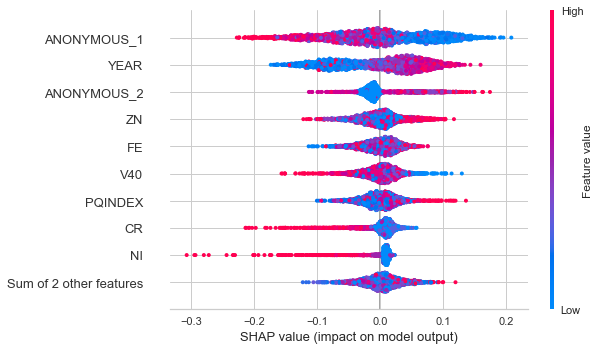

In [159]:
explainer_lgbm = shap.Explainer(clf_lgbm3)
shap_values_lgbm = explainer_lgbm(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [160]:
fi_lgbm = pd.DataFrame(clf_lgbm3.feature_importances_, index=X_train3.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                     6238
V40                             5467
ZN                              5363
FE                              4932
PQINDEX                         4856
CU                              3662
YEAR                            2618
MO                              2272
CR                              1830
ANONYMOUS_2                     1801
NI                               807

In [161]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.156553
V40                         0.137203
ZN                          0.134593
FE                          0.123777
PQINDEX                     0.121869
CU                          0.091904
YEAR                        0.065703
MO                          0.057020
CR                          0.045927
ANONYMOUS_2                 0.045199
NI                          0.020253

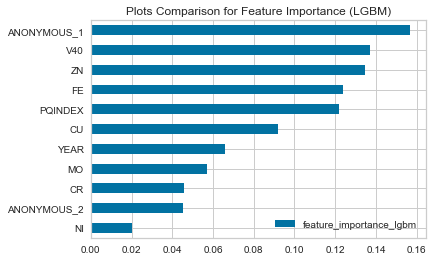

In [162]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [163]:
def objectiveCB(trial, X, y):
    
    param = {
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'max_depth':trial.suggest_int('max_depth',3,13),
        'random_state': 42,
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = CatBoostRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [164]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train3, y_train3), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-11 21:34:20,843] A new study created in memory with name: no-name-baf5793e-6144-47fd-969a-65e15dc54028
[I 2022-12-11 21:34:28,013] Trial 0 finished with value: 0.2964192342560959 and parameters: {'l2_leaf_reg': 0.48010278261605477, 'max_bin': 252, 'learning_rate': 0.014997314598315162, 'n_estimators': 407, 'max_depth': 6, 'min_data_in_leaf': 228}. Best is trial 0 with value: 0.2964192342560959.
[I 2022-12-11 21:34:48,935] Trial 1 finished with value: 0.2973857983401349 and parameters: {'l2_leaf_reg': 0.03753393717281652, 'max_bin': 304, 'learning_rate': 0.011525152575529362, 'n_estimators': 339, 'max_depth': 9, 'min_data_in_leaf': 151}. Best is trial 0 with value: 0.2964192342560959.
[I 2022-12-11 21:35:01,009] Trial 2 finished with value: 0.29814192410052026 and parameters: {'l2_leaf_reg': 0.002654476235588615, 'max_bin': 245, 'learning_rate': 0.014237976258086926, 'n_estimators': 479, 'max_depth': 9, 'min_data_in_leaf': 141}. Best is trial 0 with value: 0.2964192342560959.

[I 2022-12-11 21:45:31,342] Trial 27 finished with value: 0.2992362704860009 and parameters: {'l2_leaf_reg': 1.141709169998156, 'max_bin': 248, 'learning_rate': 0.011081090019106276, 'n_estimators': 340, 'max_depth': 5, 'min_data_in_leaf': 72}. Best is trial 25 with value: 0.2963478992133016.
[I 2022-12-11 21:45:37,652] Trial 28 finished with value: 0.2972097179563856 and parameters: {'l2_leaf_reg': 0.10576391339488526, 'max_bin': 223, 'learning_rate': 0.01719120964924283, 'n_estimators': 444, 'max_depth': 7, 'min_data_in_leaf': 169}. Best is trial 25 with value: 0.2963478992133016.
[I 2022-12-11 21:45:51,475] Trial 29 finished with value: 0.29742508935718054 and parameters: {'l2_leaf_reg': 8.652330855268103, 'max_bin': 311, 'learning_rate': 0.014827118295752461, 'n_estimators': 346, 'max_depth': 8, 'min_data_in_leaf': 127}. Best is trial 25 with value: 0.2963478992133016.
[I 2022-12-11 21:46:08,567] Trial 30 finished with value: 0.2968605923130633 and parameters: {'l2_leaf_reg': 0.789

[I 2022-12-11 21:52:33,555] Trial 54 finished with value: 0.2969997473903483 and parameters: {'l2_leaf_reg': 0.028645575751703345, 'max_bin': 213, 'learning_rate': 0.01775144340908999, 'n_estimators': 475, 'max_depth': 4, 'min_data_in_leaf': 191}. Best is trial 49 with value: 0.29563316930549255.
[I 2022-12-11 21:52:44,117] Trial 55 finished with value: 0.2964151105031737 and parameters: {'l2_leaf_reg': 0.05807380394901356, 'max_bin': 229, 'learning_rate': 0.016749904849250586, 'n_estimators': 492, 'max_depth': 8, 'min_data_in_leaf': 228}. Best is trial 49 with value: 0.29563316930549255.
[I 2022-12-11 21:52:56,794] Trial 56 finished with value: 0.29539945626151065 and parameters: {'l2_leaf_reg': 0.13934186106651797, 'max_bin': 228, 'learning_rate': 0.016313858863212558, 'n_estimators': 492, 'max_depth': 8, 'min_data_in_leaf': 135}. Best is trial 56 with value: 0.29539945626151065.
[I 2022-12-11 21:53:01,796] Trial 57 finished with value: 0.29617257007159054 and parameters: {'l2_leaf_r

[I 2022-12-11 21:57:40,331] Trial 81 finished with value: 0.2965782489376482 and parameters: {'l2_leaf_reg': 0.010688871883427247, 'max_bin': 221, 'learning_rate': 0.01780325356129489, 'n_estimators': 480, 'max_depth': 5, 'min_data_in_leaf': 109}. Best is trial 58 with value: 0.29529873555128805.
[I 2022-12-11 21:57:44,234] Trial 82 finished with value: 0.2969788060456927 and parameters: {'l2_leaf_reg': 0.015587854984567063, 'max_bin': 234, 'learning_rate': 0.016716809983264205, 'n_estimators': 465, 'max_depth': 4, 'min_data_in_leaf': 88}. Best is trial 58 with value: 0.29529873555128805.
[I 2022-12-11 21:57:49,168] Trial 83 finished with value: 0.29670150191902767 and parameters: {'l2_leaf_reg': 0.007122164275438373, 'max_bin': 244, 'learning_rate': 0.017485386141297087, 'n_estimators': 487, 'max_depth': 6, 'min_data_in_leaf': 106}. Best is trial 58 with value: 0.29529873555128805.
[I 2022-12-11 21:57:54,651] Trial 84 finished with value: 0.29651640960754916 and parameters: {'l2_leaf_

study.best_params: 0.29529873555128805
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.03353764620357991, 'max_bin': 228, 'learning_rate': 0.01638043516497813, 'n_estimators': 487, 'max_depth': 5, 'min_data_in_leaf': 101}
study.best_params: {'l2_leaf_reg': 0.03353764620357991, 'max_bin': 228, 'learning_rate': 0.01638043516497813, 'n_estimators': 487, 'max_depth': 5, 'min_data_in_leaf': 101}


In [165]:
param_cat = studyCB.best_params

clf_cat3 = CatBoostRegressor(**param_cat, random_state=42)

In [166]:
clf_cat3.fit(X_train3, y_train3.Score_0)

pred_test_cat = clf_cat3.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3799684	total: 2.49ms	remaining: 1.21s
1:	learn: 0.3795308	total: 5.6ms	remaining: 1.36s
2:	learn: 0.3790146	total: 8.47ms	remaining: 1.37s
3:	learn: 0.3784870	total: 11.1ms	remaining: 1.34s
4:	learn: 0.3780255	total: 15ms	remaining: 1.45s
5:	learn: 0.3775352	total: 18.7ms	remaining: 1.5s
6:	learn: 0.3770916	total: 22ms	remaining: 1.51s
7:	learn: 0.3766498	total: 25ms	remaining: 1.5s
8:	learn: 0.3763524	total: 28.9ms	remaining: 1.53s
9:	learn: 0.3758928	total: 32.3ms	remaining: 1.54s
10:	learn: 0.3754562	total: 35.4ms	remaining: 1.53s
11:	learn: 0.3750620	total: 37.9ms	remaining: 1.5s
12:	learn: 0.3747412	total: 40.4ms	remaining: 1.47s
13:	learn: 0.3743577	total: 42.9ms	remaining: 1.45s
14:	learn: 0.3740182	total: 45.3ms	remaining: 1.43s
15:	learn: 0.3736191	total: 47.3ms	remaining: 1.39s
16:	learn: 0.3733187	total: 49.6ms	remaining: 1.37s
17:	learn: 0.3730490	total: 51.8ms	remaining: 1.35s
18:	learn: 0.3727033	total: 53.9ms	remaining: 1.33s
19:	learn: 0.3723989	total: 56.3

223:	learn: 0.3475076	total: 442ms	remaining: 519ms
224:	learn: 0.3474206	total: 444ms	remaining: 517ms
225:	learn: 0.3473431	total: 446ms	remaining: 515ms
226:	learn: 0.3472514	total: 448ms	remaining: 513ms
227:	learn: 0.3471865	total: 449ms	remaining: 510ms
228:	learn: 0.3471286	total: 451ms	remaining: 508ms
229:	learn: 0.3470708	total: 453ms	remaining: 506ms
230:	learn: 0.3470218	total: 454ms	remaining: 503ms
231:	learn: 0.3469572	total: 456ms	remaining: 501ms
232:	learn: 0.3469336	total: 458ms	remaining: 499ms
233:	learn: 0.3468830	total: 460ms	remaining: 497ms
234:	learn: 0.3468304	total: 462ms	remaining: 495ms
235:	learn: 0.3467977	total: 463ms	remaining: 493ms
236:	learn: 0.3467501	total: 465ms	remaining: 491ms
237:	learn: 0.3467049	total: 467ms	remaining: 488ms
238:	learn: 0.3466476	total: 468ms	remaining: 486ms
239:	learn: 0.3465588	total: 470ms	remaining: 484ms
240:	learn: 0.3465230	total: 472ms	remaining: 482ms
241:	learn: 0.3464503	total: 473ms	remaining: 479ms
242:	learn: 

393:	learn: 0.3391631	total: 771ms	remaining: 182ms
394:	learn: 0.3391131	total: 773ms	remaining: 180ms
395:	learn: 0.3390810	total: 775ms	remaining: 178ms
396:	learn: 0.3390547	total: 777ms	remaining: 176ms
397:	learn: 0.3390157	total: 779ms	remaining: 174ms
398:	learn: 0.3389793	total: 781ms	remaining: 172ms
399:	learn: 0.3389282	total: 783ms	remaining: 170ms
400:	learn: 0.3388740	total: 785ms	remaining: 168ms
401:	learn: 0.3388386	total: 787ms	remaining: 166ms
402:	learn: 0.3387953	total: 789ms	remaining: 164ms
403:	learn: 0.3387133	total: 791ms	remaining: 162ms
404:	learn: 0.3386657	total: 793ms	remaining: 161ms
405:	learn: 0.3386132	total: 795ms	remaining: 159ms
406:	learn: 0.3385386	total: 798ms	remaining: 157ms
407:	learn: 0.3385063	total: 800ms	remaining: 155ms
408:	learn: 0.3384863	total: 801ms	remaining: 153ms
409:	learn: 0.3384492	total: 803ms	remaining: 151ms
410:	learn: 0.3383978	total: 805ms	remaining: 149ms
411:	learn: 0.3383331	total: 807ms	remaining: 147ms
412:	learn: 

In [167]:
optuna.visualization.plot_param_importances(studyCB)

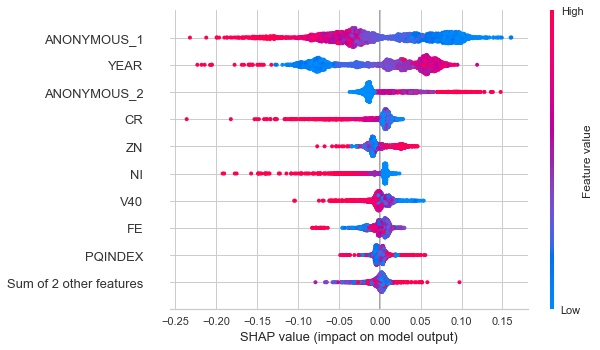

In [168]:
explainer_cat = shap.Explainer(clf_cat3)
shap_values_cat = explainer_cat(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [169]:
fi_cat = pd.DataFrame(clf_cat3.feature_importances_, index=X_train3.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
YEAR                      22.186295
ANONYMOUS_1               22.091364
ANONYMOUS_2                8.865299
CR                         7.722359
FE                         6.874417
V40                        6.814168
ZN                         6.564403
PQINDEX                    5.406097
NI                         5.303599
CU                         4.405789
MO                         3.766211

In [170]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
YEAR                       0.221863
ANONYMOUS_1                0.220914
ANONYMOUS_2                0.088653
CR                         0.077224
FE                         0.068744
V40                        0.068142
ZN                         0.065644
PQINDEX                    0.054061
NI                         0.053036
CU                         0.044058
MO                         0.037662

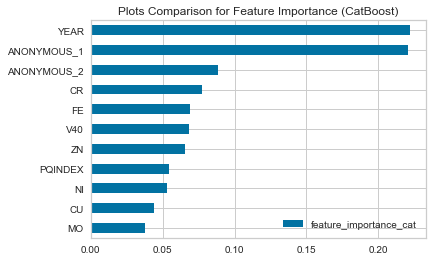

In [171]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [172]:
def objectiveET(trial, X, y):
    
    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = ExtraTreesRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [173]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train3, y_train3), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-11 21:58:49,554] A new study created in memory with name: no-name-97cfa149-9203-4525-ae8e-403d4ccc6f7f
[I 2022-12-11 21:58:56,648] Trial 0 finished with value: 0.29411002762414096 and parameters: {'max_depth': 10, 'max_leaf_nodes': 644, 'n_estimators': 482}. Best is trial 0 with value: 0.29411002762414096.
[I 2022-12-11 21:58:58,843] Trial 1 finished with value: 0.3065749714014349 and parameters: {'max_depth': 4, 'max_leaf_nodes': 627, 'n_estimators': 375}. Best is trial 0 with value: 0.29411002762414096.
[I 2022-12-11 21:59:02,573] Trial 2 finished with value: 0.2939825079223714 and parameters: {'max_depth': 11, 'max_leaf_nodes': 487, 'n_estimators': 233}. Best is trial 2 with value: 0.2939825079223714.
[I 2022-12-11 21:59:03,965] Trial 3 finished with value: 0.3064673790464576 and parameters: {'max_depth': 4, 'max_leaf_nodes': 353, 'n_estimators': 236}. Best is trial 2 with value: 0.2939825079223714.
[I 2022-12-11 21:59:06,658] Trial 4 finished with value: 0.30266069489331

[I 2022-12-11 22:02:09,986] Trial 38 finished with value: 0.2944860564632105 and parameters: {'max_depth': 13, 'max_leaf_nodes': 161, 'n_estimators': 453}. Best is trial 29 with value: 0.2931675337828339.
[I 2022-12-11 22:02:18,190] Trial 39 finished with value: 0.2937005133387702 and parameters: {'max_depth': 12, 'max_leaf_nodes': 362, 'n_estimators': 497}. Best is trial 29 with value: 0.2931675337828339.
[I 2022-12-11 22:02:22,872] Trial 40 finished with value: 0.29686132726389997 and parameters: {'max_depth': 13, 'max_leaf_nodes': 76, 'n_estimators': 396}. Best is trial 29 with value: 0.2931675337828339.
[I 2022-12-11 22:02:28,819] Trial 41 finished with value: 0.29318845693350887 and parameters: {'max_depth': 12, 'max_leaf_nodes': 280, 'n_estimators': 363}. Best is trial 29 with value: 0.2931675337828339.
[I 2022-12-11 22:02:34,943] Trial 42 finished with value: 0.29326077403421 and parameters: {'max_depth': 12, 'max_leaf_nodes': 252, 'n_estimators': 361}. Best is trial 29 with val

[I 2022-12-11 22:05:53,144] Trial 76 finished with value: 0.2932103075549387 and parameters: {'max_depth': 12, 'max_leaf_nodes': 264, 'n_estimators': 459}. Best is trial 29 with value: 0.2931675337828339.
[I 2022-12-11 22:06:01,096] Trial 77 finished with value: 0.29352525305211313 and parameters: {'max_depth': 13, 'max_leaf_nodes': 271, 'n_estimators': 454}. Best is trial 29 with value: 0.2931675337828339.
[I 2022-12-11 22:06:09,349] Trial 78 finished with value: 0.29410519081018266 and parameters: {'max_depth': 10, 'max_leaf_nodes': 384, 'n_estimators': 464}. Best is trial 29 with value: 0.2931675337828339.
[I 2022-12-11 22:06:16,576] Trial 79 finished with value: 0.2939478231188038 and parameters: {'max_depth': 11, 'max_leaf_nodes': 166, 'n_estimators': 480}. Best is trial 29 with value: 0.2931675337828339.
[I 2022-12-11 22:06:23,463] Trial 80 finished with value: 0.2935602935865438 and parameters: {'max_depth': 12, 'max_leaf_nodes': 344, 'n_estimators': 400}. Best is trial 29 with 

study.best_params: 0.2931675337828339
Number of finished trials: 100
Best trial: {'max_depth': 12, 'max_leaf_nodes': 240, 'n_estimators': 423}
study.best_params: {'max_depth': 12, 'max_leaf_nodes': 240, 'n_estimators': 423}


In [174]:
param_et = studyET.best_params

clf_et3 = ExtraTreesRegressor(**param_et, random_state=42)

In [175]:
clf_et3.fit(X_train3, y_train3.Score_0)

pred_test_et = clf_et3.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.221
F1 Score : 0.2353
Macro F1 Score : 0.5824 

[[2399  196]
 [ 168   56]]


In [176]:
optuna.visualization.plot_param_importances(studyET)

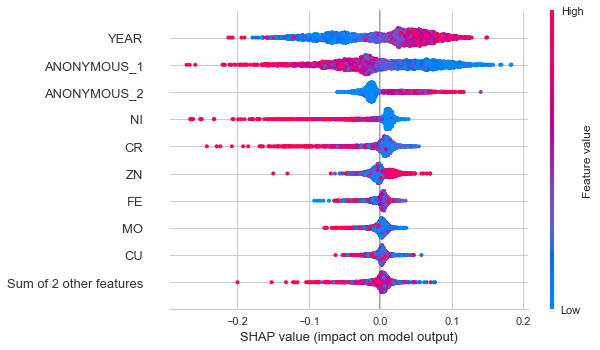

In [177]:
explainer_et = shap.Explainer(clf_et3)
shap_values_et = explainer_et(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [178]:
fi_et = pd.DataFrame(clf_et3.feature_importances_, index=X_train3.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.192807
YEAR                      0.170384
CR                        0.089611
FE                        0.073239
V40                       0.071661
NI                        0.070178
CU                        0.070079
ZN                        0.069446
PQINDEX                   0.065764
ANONYMOUS_2               0.063580
MO                        0.063251

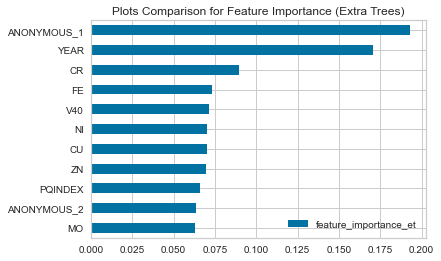

In [179]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Dataset 4

### Decision Tree

In [180]:
def objectiveDT(trial, X, y):
    
    param = {
    'criterion': trial.suggest_categorical('criterion',['mae']),
    'splitter': trial.suggest_categorical('splitter',['best','random']),
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = DecisionTreeRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [181]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train4, y_train4), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-11 22:09:26,054] A new study created in memory with name: no-name-3bd2c53b-6ee2-49b2-abee-d8ac3f028378
[I 2022-12-11 22:09:27,672] Trial 0 finished with value: 0.23570996497373028 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 6, 'max_leaf_nodes': 882}. Best is trial 0 with value: 0.23570996497373028.
[I 2022-12-11 22:09:28,654] Trial 1 finished with value: 0.2328918914185639 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 129}. Best is trial 1 with value: 0.2328918914185639.
[I 2022-12-11 22:09:29,822] Trial 2 finished with value: 0.2328918914185639 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 481}. Best is trial 1 with value: 0.2328918914185639.
[I 2022-12-11 22:09:30,597] Trial 3 finished with value: 0.24342306479859893 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 9, 'max_leaf_nodes': 591}. Best is trial 1 with value: 0.232891891418563

[I 2022-12-11 22:10:18,221] Trial 35 finished with value: 0.2328196147110333 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 4, 'max_leaf_nodes': 219}. Best is trial 14 with value: 0.23277535901926444.
[I 2022-12-11 22:10:18,970] Trial 36 finished with value: 0.2342294220665499 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 5, 'max_leaf_nodes': 213}. Best is trial 14 with value: 0.23277535901926444.
[I 2022-12-11 22:10:20,205] Trial 37 finished with value: 0.2328918914185639 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 431}. Best is trial 14 with value: 0.23277535901926444.
[I 2022-12-11 22:10:21,557] Trial 38 finished with value: 0.23647558669001753 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 7, 'max_leaf_nodes': 260}. Best is trial 14 with value: 0.23277535901926444.
[I 2022-12-11 22:10:23,715] Trial 39 finished with value: 0.2328196147110333 and parameters: {'crit

[I 2022-12-11 22:11:14,177] Trial 70 finished with value: 0.2328918914185639 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 3, 'max_leaf_nodes': 162}. Best is trial 14 with value: 0.23277535901926444.
[I 2022-12-11 22:11:15,472] Trial 71 finished with value: 0.2328196147110333 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 4, 'max_leaf_nodes': 185}. Best is trial 14 with value: 0.23277535901926444.
[I 2022-12-11 22:11:16,984] Trial 72 finished with value: 0.23464388791593693 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 5, 'max_leaf_nodes': 23}. Best is trial 14 with value: 0.23277535901926444.
[I 2022-12-11 22:11:18,285] Trial 73 finished with value: 0.2328196147110333 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 4, 'max_leaf_nodes': 307}. Best is trial 14 with value: 0.23277535901926444.
[I 2022-12-11 22:11:19,583] Trial 74 finished with value: 0.2328196147110333 and parameters: {'criterion

study.best_params: 0.23277535901926444
Number of finished trials: 100
Best trial: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 6, 'max_leaf_nodes': 6}
study.best_params: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 6, 'max_leaf_nodes': 6}


In [182]:
param_dt = studyDT.best_params

clf_dt4 = DecisionTreeRegressor(**param_dt, random_state=42)

In [183]:
clf_dt4.fit(X_train4, y_train4.Score_0)

pred_test_dt = clf_dt4.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.0917
F1 Score : 0.1425
Macro F1 Score : 0.5416 

[[2480  226]
 [  87   26]]


In [184]:
optuna.visualization.plot_param_importances(studyDT)

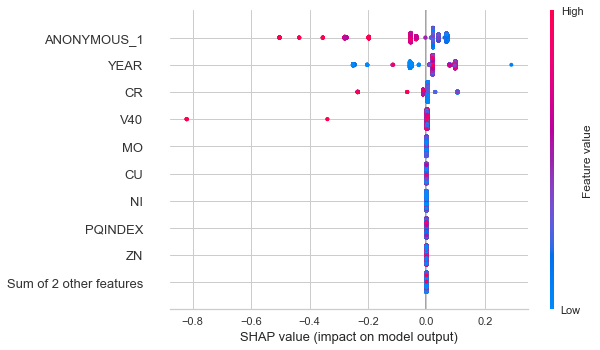

In [185]:
explainer_dt = shap.Explainer(clf_dt4)
shap_values_dt = explainer_dt(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [186]:
fi_dt = pd.DataFrame(clf_dt4.feature_importances_, index=X_train4.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
ANONYMOUS_1               0.575190
YEAR                      0.184063
CR                        0.156256
V40                       0.084491
FE                        0.000000
ANONYMOUS_2               0.000000
ZN                        0.000000
PQINDEX                   0.000000
NI                        0.000000
CU                        0.000000
MO                        0.000000

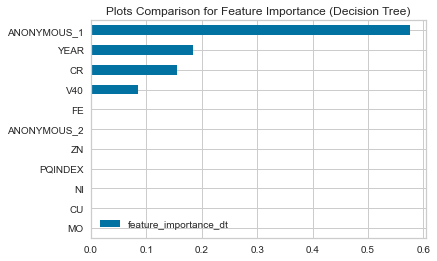

In [187]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [188]:
def objectiveSVR(trial, X, y):
    
    param = {
        'C': trial.suggest_loguniform('C', 0.3, 10.0),
        'degree': trial.suggest_int('degree', 2, 7),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 0.01),
        'epsilon': trial.suggest_float('epsilon', 0.05, 0.5),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = SVR(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [189]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train4, y_train4), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-11 22:11:51,255] A new study created in memory with name: no-name-f5314c05-1588-4770-ba43-6e8e387ba474
[I 2022-12-11 22:11:52,739] Trial 0 finished with value: 0.40261286226224835 and parameters: {'C': 1.1941506251598548, 'degree': 6, 'gamma': 0.0020635159979385436, 'epsilon': 0.4096169193970365}. Best is trial 0 with value: 0.40261286226224835.
[I 2022-12-11 22:11:55,096] Trial 1 finished with value: 0.28436501029852784 and parameters: {'C': 4.53238798147676, 'degree': 4, 'gamma': 0.002628453363465549, 'epsilon': 0.11870116970451967}. Best is trial 1 with value: 0.28436501029852784.
[I 2022-12-11 22:11:57,666] Trial 2 finished with value: 0.2749703409995567 and parameters: {'C': 4.197228653174153, 'degree': 4, 'gamma': 0.002704896819084846, 'epsilon': 0.08311004230615646}. Best is trial 2 with value: 0.2749703409995567.
[I 2022-12-11 22:12:00,539] Trial 3 finished with value: 0.33362069388438653 and parameters: {'C': 8.199485388520028, 'degree': 7, 'gamma': 0.00670620304536

[I 2022-12-11 22:13:03,503] Trial 32 finished with value: 0.2608979235858694 and parameters: {'C': 0.36983888370444984, 'degree': 2, 'gamma': 0.001967618186846397, 'epsilon': 0.07555815233236315}. Best is trial 31 with value: 0.2528714668031216.
[I 2022-12-11 22:13:05,907] Trial 33 finished with value: 0.2534462819943687 and parameters: {'C': 0.31706447456671205, 'degree': 3, 'gamma': 0.0025734606943962394, 'epsilon': 0.05331975850457526}. Best is trial 31 with value: 0.2528714668031216.
[I 2022-12-11 22:13:08,216] Trial 34 finished with value: 0.2754703268259225 and parameters: {'C': 0.4994324666268266, 'degree': 3, 'gamma': 0.002646019008767024, 'epsilon': 0.10877991303787767}. Best is trial 31 with value: 0.2528714668031216.
[I 2022-12-11 22:13:10,511] Trial 35 finished with value: 0.26477269045563057 and parameters: {'C': 0.7543878179289134, 'degree': 4, 'gamma': 0.0018792375122882454, 'epsilon': 0.0812593460812975}. Best is trial 31 with value: 0.2528714668031216.
[I 2022-12-11 22

[I 2022-12-11 22:14:16,512] Trial 64 finished with value: 0.2551746331526886 and parameters: {'C': 0.33534856360640103, 'degree': 7, 'gamma': 0.00149428119485489, 'epsilon': 0.06282929187467871}. Best is trial 61 with value: 0.2512264119697347.
[I 2022-12-11 22:14:18,206] Trial 65 finished with value: 0.26437850991102785 and parameters: {'C': 0.4142385991148089, 'degree': 5, 'gamma': 0.0013932457041137768, 'epsilon': 0.08661175108218361}. Best is trial 61 with value: 0.2512264119697347.
[I 2022-12-11 22:14:21,287] Trial 66 finished with value: 0.2629056279050497 and parameters: {'C': 9.61269480544166, 'degree': 6, 'gamma': 0.0012362962479117953, 'epsilon': 0.050889353002723355}. Best is trial 61 with value: 0.2512264119697347.
[I 2022-12-11 22:14:23,103] Trial 67 finished with value: 0.2742579278611408 and parameters: {'C': 0.3027839886752034, 'degree': 6, 'gamma': 0.0010241886098485884, 'epsilon': 0.11367850061256976}. Best is trial 61 with value: 0.2512264119697347.
[I 2022-12-11 22:

[I 2022-12-11 22:15:20,642] Trial 96 finished with value: 0.2662885198508912 and parameters: {'C': 0.3226591288995037, 'degree': 2, 'gamma': 0.002876526382378774, 'epsilon': 0.08769593820276461}. Best is trial 61 with value: 0.2512264119697347.
[I 2022-12-11 22:15:24,435] Trial 97 finished with value: 0.28003699586238057 and parameters: {'C': 6.3452248652687215, 'degree': 6, 'gamma': 0.003721334550064916, 'epsilon': 0.05101724351877648}. Best is trial 61 with value: 0.2512264119697347.
[I 2022-12-11 22:15:27,300] Trial 98 finished with value: 0.2639468232535836 and parameters: {'C': 1.1244678153991696, 'degree': 2, 'gamma': 0.002381925210555446, 'epsilon': 0.0725018271070319}. Best is trial 61 with value: 0.2512264119697347.
[I 2022-12-11 22:15:29,695] Trial 99 finished with value: 0.25421257788730556 and parameters: {'C': 0.3543109693992752, 'degree': 5, 'gamma': 0.0013281125790758728, 'epsilon': 0.060369505168258716}. Best is trial 61 with value: 0.2512264119697347.


study.best_params: 0.2512264119697347
Number of finished trials: 100
Best trial: {'C': 0.30119201006520535, 'degree': 6, 'gamma': 0.001400274859226743, 'epsilon': 0.05257660091041997}
study.best_params: {'C': 0.30119201006520535, 'degree': 6, 'gamma': 0.001400274859226743, 'epsilon': 0.05257660091041997}


In [190]:
param_svr = studySVR.best_params

clf_svr4 = SVR(**param_svr)

In [191]:
clf_svr4.fit(X_train4, y_train4.Score_0)

pred_test_svr = clf_svr4.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.1091
F1 Score : 0.0
Macro F1 Score : 0.4764 

[[2565  252]
 [   2    0]]


In [192]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [193]:
def objectiveRF(trial, X, y):

    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),  # max_depth 제한
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),  # n_estimators 제한
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = RandomForestRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [194]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train4, y_train4), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-11 22:15:33,108] A new study created in memory with name: no-name-4db740f8-7409-48c6-9692-0fe267041c76
[I 2022-12-11 22:15:43,340] Trial 0 finished with value: 0.29290377449017146 and parameters: {'max_depth': 9, 'max_leaf_nodes': 680, 'n_estimators': 237}. Best is trial 0 with value: 0.29290377449017146.
[I 2022-12-11 22:15:57,995] Trial 1 finished with value: 0.29448986457719467 and parameters: {'max_depth': 12, 'max_leaf_nodes': 602, 'n_estimators': 283}. Best is trial 0 with value: 0.29290377449017146.
[I 2022-12-11 22:16:17,149] Trial 2 finished with value: 0.2931463962478717 and parameters: {'max_depth': 10, 'max_leaf_nodes': 731, 'n_estimators': 319}. Best is trial 0 with value: 0.29290377449017146.
[I 2022-12-11 22:16:32,002] Trial 3 finished with value: 0.2931388702858589 and parameters: {'max_depth': 10, 'max_leaf_nodes': 613, 'n_estimators': 286}. Best is trial 0 with value: 0.29290377449017146.
[I 2022-12-11 22:16:50,364] Trial 4 finished with value: 0.2931686436

[I 2022-12-11 22:25:11,728] Trial 38 finished with value: 0.29369449458828045 and parameters: {'max_depth': 7, 'max_leaf_nodes': 663, 'n_estimators': 380}. Best is trial 34 with value: 0.29282658767852787.
[I 2022-12-11 22:25:33,834] Trial 39 finished with value: 0.29320956394872855 and parameters: {'max_depth': 10, 'max_leaf_nodes': 453, 'n_estimators': 489}. Best is trial 34 with value: 0.29282658767852787.
[I 2022-12-11 22:25:44,512] Trial 40 finished with value: 0.2931194515737061 and parameters: {'max_depth': 8, 'max_leaf_nodes': 628, 'n_estimators': 294}. Best is trial 34 with value: 0.29282658767852787.
[I 2022-12-11 22:25:58,603] Trial 41 finished with value: 0.29291919794749266 and parameters: {'max_depth': 9, 'max_leaf_nodes': 782, 'n_estimators': 343}. Best is trial 34 with value: 0.29282658767852787.
[I 2022-12-11 22:26:20,808] Trial 42 finished with value: 0.29318798618913744 and parameters: {'max_depth': 10, 'max_leaf_nodes': 697, 'n_estimators': 369}. Best is trial 34 wi

[I 2022-12-11 22:35:35,588] Trial 76 finished with value: 0.2928540359661271 and parameters: {'max_depth': 9, 'max_leaf_nodes': 815, 'n_estimators': 458}. Best is trial 64 with value: 0.29277280383010806.
[I 2022-12-11 22:35:54,181] Trial 77 finished with value: 0.2931280870564835 and parameters: {'max_depth': 10, 'max_leaf_nodes': 764, 'n_estimators': 458}. Best is trial 64 with value: 0.29277280383010806.
[I 2022-12-11 22:36:10,860] Trial 78 finished with value: 0.2931110977509902 and parameters: {'max_depth': 8, 'max_leaf_nodes': 720, 'n_estimators': 481}. Best is trial 64 with value: 0.29277280383010806.
[I 2022-12-11 22:36:31,934] Trial 79 finished with value: 0.29292628640866536 and parameters: {'max_depth': 9, 'max_leaf_nodes': 569, 'n_estimators': 496}. Best is trial 64 with value: 0.29277280383010806.
[I 2022-12-11 22:36:55,442] Trial 80 finished with value: 0.2930967483324994 and parameters: {'max_depth': 10, 'max_leaf_nodes': 638, 'n_estimators': 444}. Best is trial 64 with 

study.best_params: 0.29277280383010806
Number of finished trials: 100
Best trial: {'max_depth': 9, 'max_leaf_nodes': 821, 'n_estimators': 297}
study.best_params: {'max_depth': 9, 'max_leaf_nodes': 821, 'n_estimators': 297}


In [195]:
param_rf = studyRF.best_params

clf_rf4 = RandomForestRegressor(**param_rf, random_state=42)

In [196]:
clf_rf4.fit(X_train4, y_train4.Score_0)

pred_test_rf = clf_rf4.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.2194
F1 Score : 0.2355
Macro F1 Score : 0.5805 

[[2377  193]
 [ 190   59]]


In [197]:
optuna.visualization.plot_param_importances(studyRF)

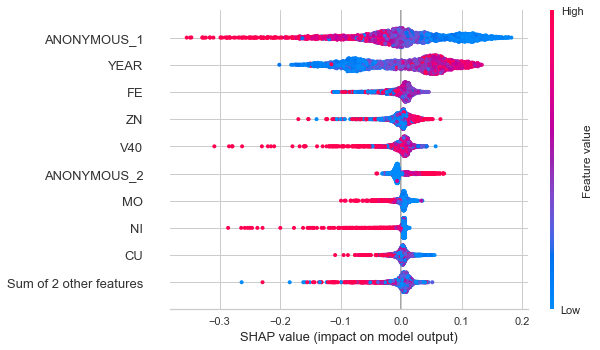

In [198]:
explainer_rf = shap.Explainer(clf_rf4)
shap_values_rf = explainer_rf(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [199]:
fi_rf = pd.DataFrame(clf_rf4.feature_importances_, index=X_train4.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.228382
YEAR                      0.126044
V40                       0.112537
ZN                        0.105872
FE                        0.095377
PQINDEX                   0.086835
CU                        0.073422
MO                        0.048021
CR                        0.047020
ANONYMOUS_2               0.038574
NI                        0.037916

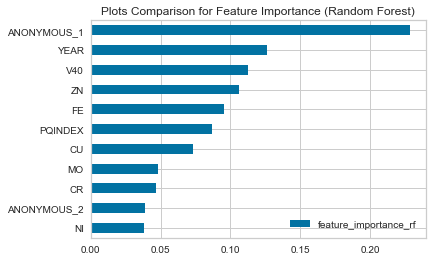

In [200]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [201]:
def objectiveXGB(trial, X, y):

    param = {
    'verbosity':1,
    'objective': trial.suggest_categorical('objective',['reg:squarederror']),
    'max_depth':trial.suggest_int('max_depth',3,13),  # 데이터 수가 적어 3~13으로 제한
    'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'subsample':trial.suggest_loguniform('subsample',0.7,1),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 300 ),
    'alpha': trial.suggest_loguniform( 'alpha', 1e-3, 10.0),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [202]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train4, y_train4), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-11 22:44:01,836] A new study created in memory with name: no-name-af78175a-fb10-433c-b069-c0e708bb44a9
[I 2022-12-11 22:44:02,363] Trial 0 finished with value: 0.4428940455341507 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 1.6452622119280308e-08, 'n_estimators': 136, 'subsample': 0.7978385408415746, 'min_child_weight': 150, 'alpha': 0.02183073772065695}. Best is trial 0 with value: 0.4428940455341507.
[I 2022-12-11 22:44:08,931] Trial 1 finished with value: 0.44140636867483113 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 4.2119582132014144e-05, 'n_estimators': 241, 'subsample': 0.9152126254073806, 'min_child_weight': 19, 'alpha': 0.001120521176168261}. Best is trial 1 with value: 0.44140636867483113.
[I 2022-12-11 22:44:13,833] Trial 2 finished with value: 0.4368759395343493 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.00015414114738051927, 'n_estimators': 2

[I 2022-12-11 22:46:23,589] Trial 23 finished with value: 0.39175503530564115 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.0013287443172841473, 'n_estimators': 335, 'subsample': 0.7825163110134609, 'min_child_weight': 93, 'alpha': 0.002810216746673937}. Best is trial 21 with value: 0.3058542195240629.
[I 2022-12-11 22:46:38,397] Trial 24 finished with value: 0.3545890310041124 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.0022349328318672684, 'n_estimators': 413, 'subsample': 0.8349846325931914, 'min_child_weight': 35, 'alpha': 0.0022701367644426466}. Best is trial 21 with value: 0.3058542195240629.
[I 2022-12-11 22:46:44,347] Trial 25 finished with value: 0.4268709470109222 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.0005816406159743423, 'n_estimators': 209, 'subsample': 0.7731998016522265, 'min_child_weight': 160, 'alpha': 0.03659916591889359}. Best is trial 21 wi

[I 2022-12-11 22:48:49,887] Trial 47 finished with value: 0.3263014408751753 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.0043048376634416624, 'n_estimators': 420, 'subsample': 0.712698914072937, 'min_child_weight': 183, 'alpha': 0.001583857085088903}. Best is trial 30 with value: 0.3056528954402369.
[I 2022-12-11 22:48:57,980] Trial 48 finished with value: 0.39392883135645274 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.0008448052182780582, 'n_estimators': 499, 'subsample': 0.7359557935295259, 'min_child_weight': 83, 'alpha': 0.0010317935143459337}. Best is trial 30 with value: 0.3056528954402369.
[I 2022-12-11 22:49:05,789] Trial 49 finished with value: 0.31759390688643985 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.0052944106322939865, 'n_estimators': 394, 'subsample': 0.7483193555793748, 'min_child_weight': 113, 'alpha': 0.005117904701889214}. Best is trial 30 

[I 2022-12-11 22:51:37,326] Trial 71 finished with value: 0.30103423804199636 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.00962973758653242, 'n_estimators': 447, 'subsample': 0.7717595837015804, 'min_child_weight': 8, 'alpha': 0.29980244204467943}. Best is trial 68 with value: 0.30076167205847293.
[I 2022-12-11 22:51:42,872] Trial 72 finished with value: 0.31199863527981914 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.005407632422649227, 'n_estimators': 447, 'subsample': 0.7704535529053597, 'min_child_weight': 4, 'alpha': 0.3271230606279534}. Best is trial 68 with value: 0.30076167205847293.
[I 2022-12-11 22:51:48,655] Trial 73 finished with value: 0.3495968160572653 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.002571967802560491, 'n_estimators': 406, 'subsample': 0.7809131802569854, 'min_child_weight': 24, 'alpha': 0.15905588788548655}. Best is trial 68 with value: 

[I 2022-12-11 22:54:35,955] Trial 95 finished with value: 0.3060263121386293 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.007057413321725746, 'n_estimators': 439, 'subsample': 0.8313352094578971, 'min_child_weight': 28, 'alpha': 2.5216221554972584}. Best is trial 85 with value: 0.3001856786279252.
[I 2022-12-11 22:54:42,413] Trial 96 finished with value: 0.34226214599819815 and parameters: {'objective': 'reg:squarederror', 'max_depth': 5, 'learning_rate': 0.0029050919648149604, 'n_estimators': 427, 'subsample': 0.8137118495415885, 'min_child_weight': 41, 'alpha': 1.5579248794102367}. Best is trial 85 with value: 0.3001856786279252.
[I 2022-12-11 22:54:49,376] Trial 97 finished with value: 0.30235694901113963 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.009832273458097627, 'n_estimators': 458, 'subsample': 0.7878350940661089, 'min_child_weight': 12, 'alpha': 4.117597737971297}. Best is trial 85 with value: 0

study.best_params: 0.3001856786279252
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.00996387933283221, 'n_estimators': 429, 'subsample': 0.7623404184099818, 'min_child_weight': 2, 'alpha': 1.5916109575577202}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.00996387933283221, 'n_estimators': 429, 'subsample': 0.7623404184099818, 'min_child_weight': 2, 'alpha': 1.5916109575577202}


In [203]:
param_xgb = studyXGB.best_params

clf_xgb4 = xgb.XGBRegressor(**param_xgb, random_state=42)

In [204]:
clf_xgb4.fit(X_train4, y_train4.Score_0)

pred_test_xgb = clf_xgb4.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2229
F1 Score : 0.2394
Macro F1 Score : 0.5812 

[[2363  190]
 [ 204   62]]


In [205]:
optuna.visualization.plot_param_importances(studyXGB)

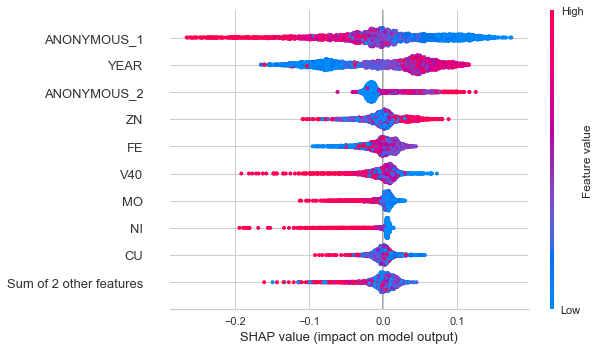

In [206]:
explainer_xgb = shap.Explainer(clf_xgb4)
shap_values_xgb = explainer_xgb(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [207]:
fi_xgb = pd.DataFrame(clf_xgb4.feature_importances_, index=X_train4.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
YEAR                       0.139767
NI                         0.135632
ANONYMOUS_1                0.120402
CR                         0.085771
ANONYMOUS_2                0.085562
V40                        0.077946
FE                         0.074531
ZN                         0.072266
PQINDEX                    0.070000
CU                         0.069927
MO                         0.068195

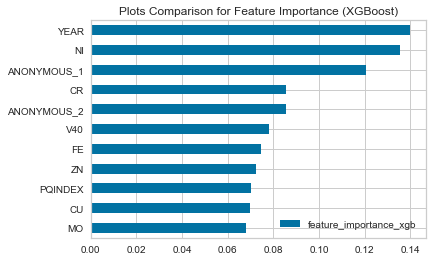

In [208]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
# plt.legend([])  # 범례 없애기
plt.show()

### LGBM

In [209]:
def objectiveLGBM(trial, X, y):

    param = {
        'metric': 'mae', 
        'random_state': 42,
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
#         'max_depth':trial.suggest_int('max_depth',3,30),
        'num_leaves' : trial.suggest_categorical('num_leaves', [8,16,32,64,128,256,512,1024]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [210]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train4, y_train4), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-11 22:55:20,001] A new study created in memory with name: no-name-8713e846-562a-4f52-8a70-6cb670512f43
[I 2022-12-11 22:55:22,435] Trial 0 finished with value: 0.3242834193389793 and parameters: {'n_estimators': 134, 'reg_alpha': 0.14266883827661037, 'reg_lambda': 0.015018488627213214, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.0004960614525954549, 'num_leaves': 64, 'min_child_samples': 12, 'min_data_per_groups': 96}. Best is trial 0 with value: 0.3242834193389793.
[I 2022-12-11 22:55:23,675] Trial 1 finished with value: 0.32455072926550405 and parameters: {'n_estimators': 312, 'reg_alpha': 0.0016010468633262261, 'reg_lambda': 0.0941081905044253, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.0002849725357917223, 'num_leaves': 32, 'min_child_samples': 164, 'min_data_per_groups': 67}. Best is trial 0 with value: 0.3242834193389793.
[I 2022-12-11 22:55:29,393] Trial 2 finished with value: 0.3259768740097028 and parameters: {'n_estimators': 345

[I 2022-12-11 22:55:54,628] Trial 21 finished with value: 0.3103960086447458 and parameters: {'n_estimators': 236, 'reg_alpha': 0.27372679221758506, 'reg_lambda': 0.00360969033334429, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.008121321308264656, 'num_leaves': 1024, 'min_child_samples': 274, 'min_data_per_groups': 82}. Best is trial 13 with value: 0.3064785470052185.
[I 2022-12-11 22:55:55,621] Trial 22 finished with value: 0.3085599805481447 and parameters: {'n_estimators': 241, 'reg_alpha': 0.08152348390853385, 'reg_lambda': 0.0010113515219281194, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.00890516580896721, 'num_leaves': 256, 'min_child_samples': 234, 'min_data_per_groups': 46}. Best is trial 13 with value: 0.3064785470052185.
[I 2022-12-11 22:55:56,939] Trial 23 finished with value: 0.3200088390748791 and parameters: {'n_estimators': 262, 'reg_alpha': 0.0617781347668722, 'reg_lambda': 0.016340722221099432, 'colsample_bytree': 0.5, 'subsample': 

[I 2022-12-11 22:56:36,345] Trial 42 finished with value: 0.3041442923929235 and parameters: {'n_estimators': 318, 'reg_alpha': 0.4822367136997559, 'reg_lambda': 0.004258586380855226, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.0035736565893811907, 'num_leaves': 128, 'min_child_samples': 2, 'min_data_per_groups': 11}. Best is trial 38 with value: 0.303533110110674.
[I 2022-12-11 22:56:40,292] Trial 43 finished with value: 0.30627753432229277 and parameters: {'n_estimators': 319, 'reg_alpha': 1.0112787834967938, 'reg_lambda': 0.0038991803533937794, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.0037811716469399004, 'num_leaves': 128, 'min_child_samples': 25, 'min_data_per_groups': 12}. Best is trial 38 with value: 0.303533110110674.
[I 2022-12-11 22:56:52,004] Trial 44 finished with value: 0.30608769488531784 and parameters: {'n_estimators': 409, 'reg_alpha': 0.9052257515151849, 'reg_lambda': 0.08332672239871741, 'colsample_bytree': 0.8, 'subsample': 0.8

[I 2022-12-11 22:58:52,505] Trial 63 finished with value: 0.31247977043954095 and parameters: {'n_estimators': 498, 'reg_alpha': 0.37049916953245654, 'reg_lambda': 0.0014284289825937276, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.0016785223167714454, 'num_leaves': 32, 'min_child_samples': 66, 'min_data_per_groups': 4}. Best is trial 54 with value: 0.2960080248558753.
[I 2022-12-11 22:58:59,136] Trial 64 finished with value: 0.31441006198102184 and parameters: {'n_estimators': 487, 'reg_alpha': 0.2313956054102752, 'reg_lambda': 0.0017006977642415105, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.0012455324730098432, 'num_leaves': 32, 'min_child_samples': 30, 'min_data_per_groups': 4}. Best is trial 54 with value: 0.2960080248558753.
[I 2022-12-11 22:59:02,708] Trial 65 finished with value: 0.3003309103788373 and parameters: {'n_estimators': 476, 'reg_alpha': 0.5437366061866663, 'reg_lambda': 0.0018031753205031086, 'colsample_bytree': 0.7, 'subsample': 

[I 2022-12-11 23:01:10,131] Trial 84 finished with value: 0.2921142309347688 and parameters: {'n_estimators': 435, 'reg_alpha': 0.07829453442059542, 'reg_lambda': 0.035036004684028905, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.009960775650290247, 'num_leaves': 512, 'min_child_samples': 12, 'min_data_per_groups': 25}. Best is trial 84 with value: 0.2921142309347688.
[I 2022-12-11 23:01:22,163] Trial 85 finished with value: 0.2951212032961159 and parameters: {'n_estimators': 438, 'reg_alpha': 0.0798190682887341, 'reg_lambda': 0.04160217134647348, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.007568253242098996, 'num_leaves': 512, 'min_child_samples': 19, 'min_data_per_groups': 26}. Best is trial 84 with value: 0.2921142309347688.
[I 2022-12-11 23:01:33,931] Trial 86 finished with value: 0.29604820552386124 and parameters: {'n_estimators': 387, 'reg_alpha': 0.07681548678318709, 'reg_lambda': 0.03564572566139991, 'colsample_bytree': 0.6, 'subsample': 0.6

study.best_params: 0.2921142309347688
Number of finished trials: 100
Best trial: {'n_estimators': 435, 'reg_alpha': 0.07829453442059542, 'reg_lambda': 0.035036004684028905, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.009960775650290247, 'num_leaves': 512, 'min_child_samples': 12, 'min_data_per_groups': 25}
study.best_params: {'n_estimators': 435, 'reg_alpha': 0.07829453442059542, 'reg_lambda': 0.035036004684028905, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.009960775650290247, 'num_leaves': 512, 'min_child_samples': 12, 'min_data_per_groups': 25}


In [211]:
param_lgbm = studyLGBM.best_params

clf_lgbm4 = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [212]:
clf_lgbm4.fit(X_train4, y_train4.Score_0)

pred_test_lgbm = clf_lgbm4.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.2215
F1 Score : 0.2024
Macro F1 Score : 0.5543 

[[2286  192]
 [ 281   60]]


In [213]:
optuna.visualization.plot_param_importances(studyLGBM)

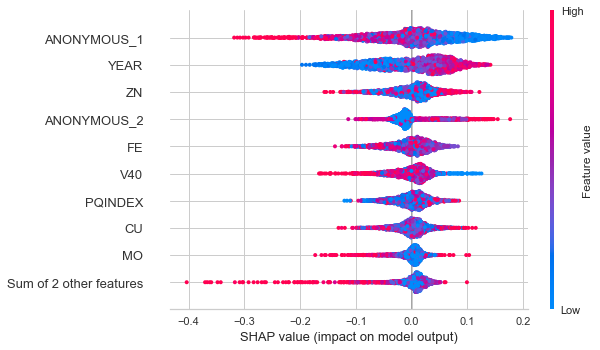

In [214]:
explainer_lgbm = shap.Explainer(clf_lgbm4)
shap_values_lgbm = explainer_lgbm(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [215]:
fi_lgbm = pd.DataFrame(clf_lgbm4.feature_importances_, index=X_train4.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                    11311
ZN                             10402
V40                             9981
FE                              9831
PQINDEX                         9567
CU                              7097
YEAR                            4969
MO                              4856
CR                              3403
ANONYMOUS_2                     2477
NI                              1077

In [216]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.150872
ZN                          0.138747
V40                         0.133131
FE                          0.131131
PQINDEX                     0.127609
CU                          0.094663
YEAR                        0.066279
MO                          0.064772
CR                          0.045391
ANONYMOUS_2                 0.033039
NI                          0.014366

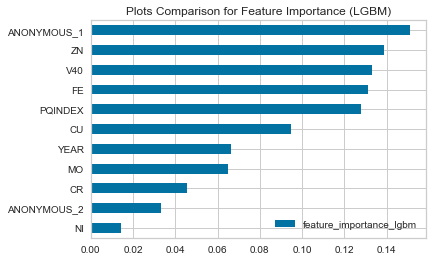

In [217]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [218]:
def objectiveCB(trial, X, y):
    
    param = {
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'max_depth':trial.suggest_int('max_depth',3,13),
        'random_state': 42,
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = CatBoostRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [219]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train4, y_train4), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-11 23:06:04,224] A new study created in memory with name: no-name-bdbac205-8b89-4522-955f-e7ee4b5f4d61
[I 2022-12-11 23:06:16,000] Trial 0 finished with value: 0.30171488469195124 and parameters: {'l2_leaf_reg': 0.05680851786569324, 'max_bin': 369, 'learning_rate': 0.014786368844068103, 'n_estimators': 164, 'max_depth': 9, 'min_data_in_leaf': 270}. Best is trial 0 with value: 0.30171488469195124.
[I 2022-12-11 23:06:18,997] Trial 1 finished with value: 0.30184547223481456 and parameters: {'l2_leaf_reg': 0.0011456060759800003, 'max_bin': 306, 'learning_rate': 0.011084944568271887, 'n_estimators': 444, 'max_depth': 3, 'min_data_in_leaf': 260}. Best is trial 0 with value: 0.30171488469195124.
[I 2022-12-11 23:09:14,776] Trial 2 finished with value: 0.3026272464436633 and parameters: {'l2_leaf_reg': 0.026372204215441602, 'max_bin': 268, 'learning_rate': 0.007571411536179497, 'n_estimators': 312, 'max_depth': 12, 'min_data_in_leaf': 255}. Best is trial 0 with value: 0.30171488469

[I 2022-12-11 23:18:53,721] Trial 27 finished with value: 0.2974063534200241 and parameters: {'l2_leaf_reg': 2.6732643590240595, 'max_bin': 283, 'learning_rate': 0.017006652902440644, 'n_estimators': 500, 'max_depth': 7, 'min_data_in_leaf': 86}. Best is trial 14 with value: 0.296105123288226.
[I 2022-12-11 23:18:56,096] Trial 28 finished with value: 0.3018220932316183 and parameters: {'l2_leaf_reg': 0.7786432934601037, 'max_bin': 325, 'learning_rate': 0.015371813882019511, 'n_estimators': 331, 'max_depth': 3, 'min_data_in_leaf': 40}. Best is trial 14 with value: 0.296105123288226.
[I 2022-12-11 23:19:12,530] Trial 29 finished with value: 0.3001613507700239 and parameters: {'l2_leaf_reg': 0.0344926155253809, 'max_bin': 360, 'learning_rate': 0.014304106862558525, 'n_estimators': 240, 'max_depth': 9, 'min_data_in_leaf': 164}. Best is trial 14 with value: 0.296105123288226.
[I 2022-12-11 23:19:18,167] Trial 30 finished with value: 0.29776936445985436 and parameters: {'l2_leaf_reg': 0.15813

[I 2022-12-11 23:23:19,051] Trial 54 finished with value: 0.29677321613763674 and parameters: {'l2_leaf_reg': 0.02894191633359155, 'max_bin': 369, 'learning_rate': 0.01732325780012844, 'n_estimators': 411, 'max_depth': 6, 'min_data_in_leaf': 33}. Best is trial 14 with value: 0.296105123288226.
[I 2022-12-11 23:23:25,673] Trial 55 finished with value: 0.29961836723478763 and parameters: {'l2_leaf_reg': 0.03768622404360134, 'max_bin': 399, 'learning_rate': 0.007876875265045939, 'n_estimators': 480, 'max_depth': 6, 'min_data_in_leaf': 11}. Best is trial 14 with value: 0.296105123288226.
[I 2022-12-11 23:23:29,718] Trial 56 finished with value: 0.2964074128509287 and parameters: {'l2_leaf_reg': 0.015764580277405474, 'max_bin': 358, 'learning_rate': 0.017902443080394858, 'n_estimators': 397, 'max_depth': 5, 'min_data_in_leaf': 68}. Best is trial 14 with value: 0.296105123288226.
[I 2022-12-11 23:23:32,585] Trial 57 finished with value: 0.2980625850974213 and parameters: {'l2_leaf_reg': 0.01

[I 2022-12-11 23:28:25,013] Trial 81 finished with value: 0.29704798790062403 and parameters: {'l2_leaf_reg': 0.1287543857770633, 'max_bin': 359, 'learning_rate': 0.017811105988834546, 'n_estimators': 445, 'max_depth': 4, 'min_data_in_leaf': 10}. Best is trial 14 with value: 0.296105123288226.
[I 2022-12-11 23:28:28,752] Trial 82 finished with value: 0.2969155214781452 and parameters: {'l2_leaf_reg': 0.16912230096304268, 'max_bin': 355, 'learning_rate': 0.017459033329126395, 'n_estimators': 458, 'max_depth': 5, 'min_data_in_leaf': 15}. Best is trial 14 with value: 0.296105123288226.
[I 2022-12-11 23:28:31,578] Trial 83 finished with value: 0.29863683562066684 and parameters: {'l2_leaf_reg': 0.08575490900018104, 'max_bin': 350, 'learning_rate': 0.017707289692037203, 'n_estimators': 436, 'max_depth': 3, 'min_data_in_leaf': 38}. Best is trial 14 with value: 0.296105123288226.
[I 2022-12-11 23:28:34,880] Trial 84 finished with value: 0.2974781771480628 and parameters: {'l2_leaf_reg': 0.152

study.best_params: 0.2959272219090488
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 1.3615501102858905, 'max_bin': 302, 'learning_rate': 0.01673574463321058, 'n_estimators': 415, 'max_depth': 6, 'min_data_in_leaf': 61}
study.best_params: {'l2_leaf_reg': 1.3615501102858905, 'max_bin': 302, 'learning_rate': 0.01673574463321058, 'n_estimators': 415, 'max_depth': 6, 'min_data_in_leaf': 61}


In [220]:
param_cat = studyCB.best_params

clf_cat4 = CatBoostRegressor(**param_cat, random_state=42)

In [221]:
clf_cat4.fit(X_train4, y_train4.Score_0)

pred_test_cat = clf_cat4.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3804482	total: 15.6ms	remaining: 6.47s
1:	learn: 0.3799575	total: 24.1ms	remaining: 4.97s
2:	learn: 0.3794838	total: 32.8ms	remaining: 4.5s
3:	learn: 0.3789599	total: 39.2ms	remaining: 4.03s
4:	learn: 0.3785358	total: 45.3ms	remaining: 3.71s
5:	learn: 0.3780891	total: 51.7ms	remaining: 3.52s
6:	learn: 0.3776604	total: 57.5ms	remaining: 3.35s
7:	learn: 0.3772438	total: 63.8ms	remaining: 3.24s
8:	learn: 0.3768156	total: 70ms	remaining: 3.16s
9:	learn: 0.3764367	total: 78.4ms	remaining: 3.18s
10:	learn: 0.3759951	total: 84.8ms	remaining: 3.12s
11:	learn: 0.3755500	total: 90.9ms	remaining: 3.05s
12:	learn: 0.3751217	total: 96.7ms	remaining: 2.99s
13:	learn: 0.3747115	total: 102ms	remaining: 2.93s
14:	learn: 0.3743163	total: 109ms	remaining: 2.9s
15:	learn: 0.3739190	total: 115ms	remaining: 2.86s
16:	learn: 0.3735800	total: 120ms	remaining: 2.82s
17:	learn: 0.3732544	total: 126ms	remaining: 2.77s
18:	learn: 0.3728587	total: 132ms	remaining: 2.75s
19:	learn: 0.3725321	total: 139m

171:	learn: 0.3489173	total: 891ms	remaining: 1.26s
172:	learn: 0.3488539	total: 895ms	remaining: 1.25s
173:	learn: 0.3487439	total: 899ms	remaining: 1.24s
174:	learn: 0.3486556	total: 903ms	remaining: 1.24s
175:	learn: 0.3485783	total: 907ms	remaining: 1.23s
176:	learn: 0.3485090	total: 911ms	remaining: 1.23s
177:	learn: 0.3484353	total: 915ms	remaining: 1.22s
178:	learn: 0.3483663	total: 919ms	remaining: 1.21s
179:	learn: 0.3482857	total: 923ms	remaining: 1.21s
180:	learn: 0.3482104	total: 926ms	remaining: 1.2s
181:	learn: 0.3481505	total: 930ms	remaining: 1.19s
182:	learn: 0.3480486	total: 932ms	remaining: 1.18s
183:	learn: 0.3479460	total: 935ms	remaining: 1.17s
184:	learn: 0.3478405	total: 940ms	remaining: 1.17s
185:	learn: 0.3477832	total: 944ms	remaining: 1.16s
186:	learn: 0.3477139	total: 948ms	remaining: 1.16s
187:	learn: 0.3476667	total: 952ms	remaining: 1.15s
188:	learn: 0.3475796	total: 956ms	remaining: 1.14s
189:	learn: 0.3475151	total: 960ms	remaining: 1.14s
190:	learn: 0

338:	learn: 0.3377039	total: 1.64s	remaining: 368ms
339:	learn: 0.3376692	total: 1.65s	remaining: 363ms
340:	learn: 0.3376254	total: 1.65s	remaining: 358ms
341:	learn: 0.3375540	total: 1.65s	remaining: 353ms
342:	learn: 0.3375220	total: 1.66s	remaining: 348ms
343:	learn: 0.3374670	total: 1.66s	remaining: 343ms
344:	learn: 0.3374090	total: 1.67s	remaining: 338ms
345:	learn: 0.3373305	total: 1.67s	remaining: 333ms
346:	learn: 0.3373036	total: 1.67s	remaining: 328ms
347:	learn: 0.3372728	total: 1.68s	remaining: 323ms
348:	learn: 0.3372012	total: 1.68s	remaining: 319ms
349:	learn: 0.3371215	total: 1.69s	remaining: 314ms
350:	learn: 0.3370505	total: 1.69s	remaining: 309ms
351:	learn: 0.3370038	total: 1.7s	remaining: 304ms
352:	learn: 0.3369191	total: 1.7s	remaining: 299ms
353:	learn: 0.3368667	total: 1.71s	remaining: 294ms
354:	learn: 0.3368360	total: 1.71s	remaining: 289ms
355:	learn: 0.3367802	total: 1.72s	remaining: 285ms
356:	learn: 0.3367251	total: 1.72s	remaining: 280ms
357:	learn: 0.

In [222]:
optuna.visualization.plot_param_importances(studyCB)

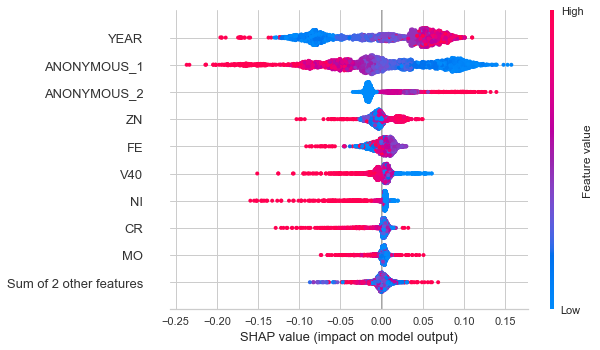

In [223]:
explainer_cat = shap.Explainer(clf_cat4)
shap_values_cat = explainer_cat(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [224]:
fi_cat = pd.DataFrame(clf_cat4.feature_importances_, index=X_train4.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
YEAR                      23.509938
ANONYMOUS_1               22.622767
ANONYMOUS_2                8.440565
FE                         7.508047
ZN                         7.172671
V40                        6.558429
PQINDEX                    5.563340
CU                         4.931014
CR                         4.904879
MO                         4.437332
NI                         4.351017

In [225]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
YEAR                       0.235099
ANONYMOUS_1                0.226228
ANONYMOUS_2                0.084406
FE                         0.075080
ZN                         0.071727
V40                        0.065584
PQINDEX                    0.055633
CU                         0.049310
CR                         0.049049
MO                         0.044373
NI                         0.043510

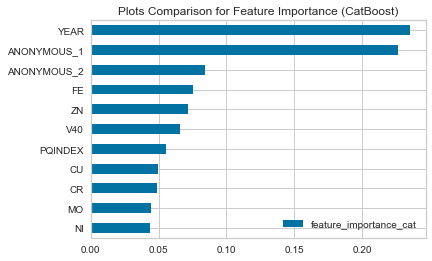

In [226]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [227]:
def objectiveET(trial, X, y):
    
    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = ExtraTreesRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [228]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train4, y_train4), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-11 23:30:03,792] A new study created in memory with name: no-name-623c8650-75e8-46e9-b55a-2173abaeb5f5
[I 2022-12-11 23:30:07,342] Trial 0 finished with value: 0.3119057185114177 and parameters: {'max_depth': 3, 'max_leaf_nodes': 926, 'n_estimators': 359}. Best is trial 0 with value: 0.3119057185114177.
[I 2022-12-11 23:30:14,642] Trial 1 finished with value: 0.2939817311141627 and parameters: {'max_depth': 12, 'max_leaf_nodes': 998, 'n_estimators': 266}. Best is trial 1 with value: 0.2939817311141627.
[I 2022-12-11 23:30:19,282] Trial 2 finished with value: 0.2945864266260044 and parameters: {'max_depth': 10, 'max_leaf_nodes': 185, 'n_estimators': 256}. Best is trial 1 with value: 0.2939817311141627.
[I 2022-12-11 23:30:30,239] Trial 3 finished with value: 0.2936803519524278 and parameters: {'max_depth': 12, 'max_leaf_nodes': 384, 'n_estimators': 434}. Best is trial 3 with value: 0.2936803519524278.
[I 2022-12-11 23:30:35,090] Trial 4 finished with value: 0.2977203413280287

[I 2022-12-11 23:33:44,633] Trial 38 finished with value: 0.29384931699971684 and parameters: {'max_depth': 12, 'max_leaf_nodes': 404, 'n_estimators': 400}. Best is trial 22 with value: 0.29327187660707643.
[I 2022-12-11 23:33:48,478] Trial 39 finished with value: 0.29416523932292804 and parameters: {'max_depth': 11, 'max_leaf_nodes': 238, 'n_estimators': 253}. Best is trial 22 with value: 0.29327187660707643.
[I 2022-12-11 23:33:52,859] Trial 40 finished with value: 0.2962400231165778 and parameters: {'max_depth': 10, 'max_leaf_nodes': 86, 'n_estimators': 369}. Best is trial 22 with value: 0.29327187660707643.
[I 2022-12-11 23:33:58,225] Trial 41 finished with value: 0.29338439973340247 and parameters: {'max_depth': 13, 'max_leaf_nodes': 280, 'n_estimators': 357}. Best is trial 22 with value: 0.29327187660707643.
[I 2022-12-11 23:34:04,951] Trial 42 finished with value: 0.2932250194408724 and parameters: {'max_depth': 13, 'max_leaf_nodes': 288, 'n_estimators': 435}. Best is trial 42 w

[I 2022-12-11 23:38:21,216] Trial 76 finished with value: 0.2934509905870487 and parameters: {'max_depth': 13, 'max_leaf_nodes': 356, 'n_estimators': 231}. Best is trial 61 with value: 0.29321645453603035.
[I 2022-12-11 23:38:30,735] Trial 77 finished with value: 0.29410527990820984 and parameters: {'max_depth': 11, 'max_leaf_nodes': 301, 'n_estimators': 450}. Best is trial 61 with value: 0.29321645453603035.
[I 2022-12-11 23:38:39,511] Trial 78 finished with value: 0.29356976226143255 and parameters: {'max_depth': 13, 'max_leaf_nodes': 235, 'n_estimators': 486}. Best is trial 61 with value: 0.29321645453603035.
[I 2022-12-11 23:38:49,244] Trial 79 finished with value: 0.29382890700760994 and parameters: {'max_depth': 12, 'max_leaf_nodes': 398, 'n_estimators': 470}. Best is trial 61 with value: 0.29321645453603035.
[I 2022-12-11 23:38:56,059] Trial 80 finished with value: 0.2948414009624027 and parameters: {'max_depth': 13, 'max_leaf_nodes': 145, 'n_estimators': 383}. Best is trial 61 

study.best_params: 0.2932049926111735
Number of finished trials: 100
Best trial: {'max_depth': 12, 'max_leaf_nodes': 337, 'n_estimators': 212}
study.best_params: {'max_depth': 12, 'max_leaf_nodes': 337, 'n_estimators': 212}


In [229]:
param_et = studyET.best_params

clf_et4 = ExtraTreesRegressor(**param_et, random_state=42)

In [230]:
clf_et4.fit(X_train4, y_train4.Score_0)

pred_test_et = clf_et4.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.22
F1 Score : 0.2236
Macro F1 Score : 0.5739 

[[2374  196]
 [ 193   56]]


In [231]:
optuna.visualization.plot_param_importances(studyET)

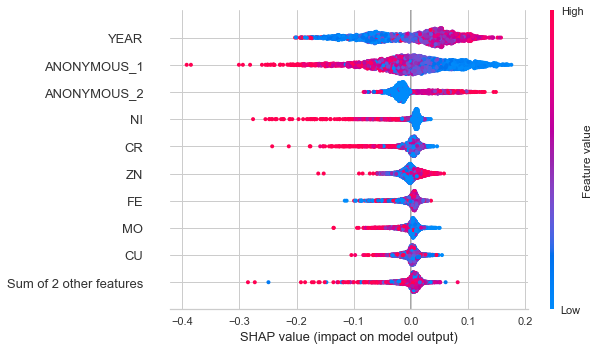

In [232]:
explainer_et = shap.Explainer(clf_et4)
shap_values_et = explainer_et(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [233]:
fi_et = pd.DataFrame(clf_et4.feature_importances_, index=X_train4.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.185611
YEAR                      0.161127
CR                        0.079542
CU                        0.078008
FE                        0.077642
V40                       0.076345
ZN                        0.075502
PQINDEX                   0.072774
MO                        0.066296
ANONYMOUS_2               0.065835
NI                        0.061319

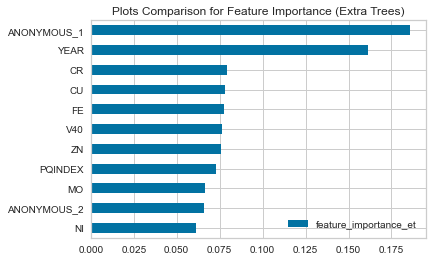

In [234]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Dataset 5

### Decision Tree

In [235]:
def objectiveDT(trial, X, y):
    
    param = {
    'criterion': trial.suggest_categorical('criterion',['mae']),
    'splitter': trial.suggest_categorical('splitter',['best','random']),
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = DecisionTreeRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [236]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train5, y_train5), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-11 23:41:42,124] A new study created in memory with name: no-name-3aed5030-5523-4078-b40f-71240d8647b5
[I 2022-12-11 23:41:44,688] Trial 0 finished with value: 0.25739912434325746 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 13, 'max_leaf_nodes': 657}. Best is trial 0 with value: 0.25739912434325746.
[I 2022-12-11 23:41:45,617] Trial 1 finished with value: 0.24606292469352012 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 10, 'max_leaf_nodes': 402}. Best is trial 1 with value: 0.24606292469352012.
[I 2022-12-11 23:41:48,181] Trial 2 finished with value: 0.2519793345008757 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 12, 'max_leaf_nodes': 675}. Best is trial 1 with value: 0.24606292469352012.
[I 2022-12-11 23:41:50,107] Trial 3 finished with value: 0.23885187390542906 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 5, 'max_leaf_nodes': 314}. Best is trial 3 with value: 0.238851873

[I 2022-12-11 23:42:29,285] Trial 34 finished with value: 0.24606292469352012 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 10, 'max_leaf_nodes': 869}. Best is trial 12 with value: 0.22799884413309984.
[I 2022-12-11 23:42:31,666] Trial 35 finished with value: 0.23668527145359022 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 6, 'max_leaf_nodes': 714}. Best is trial 12 with value: 0.22799884413309984.
[I 2022-12-11 23:42:32,564] Trial 36 finished with value: 0.23354532399299477 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 5, 'max_leaf_nodes': 398}. Best is trial 12 with value: 0.22799884413309984.
[I 2022-12-11 23:42:34,973] Trial 37 finished with value: 0.24125439579684765 and parameters: {'criterion': 'mae', 'splitter': 'best', 'max_depth': 9, 'max_leaf_nodes': 717}. Best is trial 12 with value: 0.22799884413309984.
[I 2022-12-11 23:42:35,907] Trial 38 finished with value: 0.23029992994746057 and parameters: {

[I 2022-12-11 23:43:07,743] Trial 69 finished with value: 0.24103697022767073 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 8, 'max_leaf_nodes': 463}. Best is trial 12 with value: 0.22799884413309984.
[I 2022-12-11 23:43:08,602] Trial 70 finished with value: 0.23029992994746057 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 7, 'max_leaf_nodes': 988}. Best is trial 12 with value: 0.22799884413309984.
[I 2022-12-11 23:43:09,463] Trial 71 finished with value: 0.23029992994746057 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 7, 'max_leaf_nodes': 115}. Best is trial 12 with value: 0.22799884413309984.
[I 2022-12-11 23:43:10,302] Trial 72 finished with value: 0.23029992994746057 and parameters: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 7, 'max_leaf_nodes': 136}. Best is trial 12 with value: 0.22799884413309984.
[I 2022-12-11 23:43:11,036] Trial 73 finished with value: 0.23425640980735554 and parameters

study.best_params: 0.22799884413309984
Number of finished trials: 100
Best trial: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 7, 'max_leaf_nodes': 41}
study.best_params: {'criterion': 'mae', 'splitter': 'random', 'max_depth': 7, 'max_leaf_nodes': 41}


In [237]:
param_dt = studyDT.best_params

clf_dt5 = DecisionTreeRegressor(**param_dt, random_state=42)

In [238]:
clf_dt5.fit(X_train5, y_train5.Score_0)

pred_test_dt = clf_dt5.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.0957
F1 Score : 0.1995
Macro F1 Score : 0.5683 

[[2449  211]
 [ 118   41]]


In [239]:
optuna.visualization.plot_param_importances(studyDT)

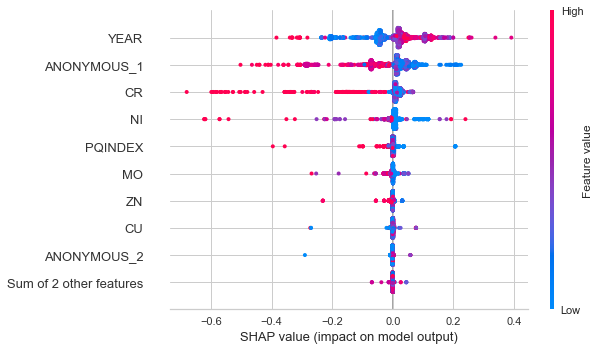

In [240]:
explainer_dt = shap.Explainer(clf_dt5)
shap_values_dt = explainer_dt(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [241]:
fi_dt = pd.DataFrame(clf_dt5.feature_importances_, index=X_train5.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
ANONYMOUS_1               0.258045
YEAR                      0.237151
CR                        0.182509
NI                        0.102913
MO                        0.059344
PQINDEX                   0.055362
CU                        0.045041
ZN                        0.030091
V40                       0.015551
ANONYMOUS_2               0.013993
FE                        0.000000

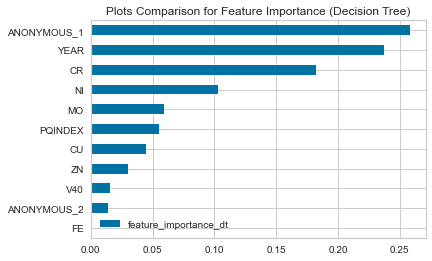

In [242]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [243]:
def objectiveSVR(trial, X, y):
    
    param = {
        'C': trial.suggest_loguniform('C', 0.3, 10.0),
        'degree': trial.suggest_int('degree', 2, 7),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 0.01),
        'epsilon': trial.suggest_float('epsilon', 0.05, 0.5),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = SVR(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [244]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train5, y_train5), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-11 23:43:35,452] A new study created in memory with name: no-name-23890f65-d0bb-49a2-91c8-574bf08e735b
[I 2022-12-11 23:43:37,927] Trial 0 finished with value: 0.30184522327113533 and parameters: {'C': 2.599060543026894, 'degree': 3, 'gamma': 0.0011387026169318235, 'epsilon': 0.17735839559106403}. Best is trial 0 with value: 0.30184522327113533.
[I 2022-12-11 23:43:39,993] Trial 1 finished with value: 0.3550048095851747 and parameters: {'C': 1.2980168683515456, 'degree': 5, 'gamma': 0.0020881090271169384, 'epsilon': 0.29964407343252725}. Best is trial 0 with value: 0.30184522327113533.
[I 2022-12-11 23:43:42,142] Trial 2 finished with value: 0.3740619549117752 and parameters: {'C': 0.9509447792371, 'degree': 5, 'gamma': 0.0061784887660886025, 'epsilon': 0.34102333967585785}. Best is trial 0 with value: 0.30184522327113533.
[I 2022-12-11 23:43:44,619] Trial 3 finished with value: 0.3208364628731301 and parameters: {'C': 2.1206948641089753, 'degree': 7, 'gamma': 0.008595351845

[I 2022-12-11 23:44:53,489] Trial 32 finished with value: 0.25526963173281647 and parameters: {'C': 0.4648929494143279, 'degree': 6, 'gamma': 0.003421476820261633, 'epsilon': 0.051189607003953835}. Best is trial 22 with value: 0.2552524999150781.
[I 2022-12-11 23:44:55,714] Trial 33 finished with value: 0.26637460085998754 and parameters: {'C': 0.44939851462905656, 'degree': 5, 'gamma': 0.0030546351114866628, 'epsilon': 0.08463913360757964}. Best is trial 22 with value: 0.2552524999150781.
[I 2022-12-11 23:44:58,621] Trial 34 finished with value: 0.26047349886927174 and parameters: {'C': 0.5888649263927769, 'degree': 5, 'gamma': 0.00509923476398069, 'epsilon': 0.05379324063449274}. Best is trial 22 with value: 0.2552524999150781.
[I 2022-12-11 23:45:01,279] Trial 35 finished with value: 0.36434402916176245 and parameters: {'C': 0.35453188207899416, 'degree': 7, 'gamma': 0.003342085035557253, 'epsilon': 0.31971614815675886}. Best is trial 22 with value: 0.2552524999150781.
[I 2022-12-11

[I 2022-12-11 23:46:24,012] Trial 64 finished with value: 0.26124493821038275 and parameters: {'C': 0.526553399005967, 'degree': 5, 'gamma': 0.004299110359610562, 'epsilon': 0.06348622581277208}. Best is trial 22 with value: 0.2552524999150781.
[I 2022-12-11 23:46:26,412] Trial 65 finished with value: 0.2637647700137004 and parameters: {'C': 0.3708377390977167, 'degree': 6, 'gamma': 0.003088063953855258, 'epsilon': 0.07896102498482281}. Best is trial 22 with value: 0.2552524999150781.
[I 2022-12-11 23:46:28,396] Trial 66 finished with value: 0.2830575124626405 and parameters: {'C': 0.32817629387340436, 'degree': 3, 'gamma': 0.004022961324325213, 'epsilon': 0.12655873167504728}. Best is trial 22 with value: 0.2552524999150781.
[I 2022-12-11 23:46:30,329] Trial 67 finished with value: 0.3312401788043883 and parameters: {'C': 0.4204125617095678, 'degree': 5, 'gamma': 0.00562650906068096, 'epsilon': 0.23813716632345736}. Best is trial 22 with value: 0.2552524999150781.
[I 2022-12-11 23:46:

[I 2022-12-11 23:47:37,953] Trial 96 finished with value: 0.2632505408203579 and parameters: {'C': 0.3585234261766011, 'degree': 5, 'gamma': 0.004737498234102952, 'epsilon': 0.07379936084014557}. Best is trial 68 with value: 0.2544294211067128.
[I 2022-12-11 23:47:41,138] Trial 97 finished with value: 0.25558552587118444 and parameters: {'C': 0.31128729479600015, 'degree': 5, 'gamma': 0.005659606753632681, 'epsilon': 0.050695212590788644}. Best is trial 68 with value: 0.2544294211067128.
[I 2022-12-11 23:47:43,712] Trial 98 finished with value: 0.4149959158496347 and parameters: {'C': 0.31673437439608637, 'degree': 5, 'gamma': 0.00645640603381282, 'epsilon': 0.4314750945898638}. Best is trial 68 with value: 0.2544294211067128.
[I 2022-12-11 23:47:46,987] Trial 99 finished with value: 0.27373399138502297 and parameters: {'C': 0.4467671032299124, 'degree': 5, 'gamma': 0.0033801679026558467, 'epsilon': 0.10285184219122545}. Best is trial 68 with value: 0.2544294211067128.


study.best_params: 0.2544294211067128
Number of finished trials: 100
Best trial: {'C': 0.37361909800358084, 'degree': 7, 'gamma': 0.0028307776406613317, 'epsilon': 0.05366136472098469}
study.best_params: {'C': 0.37361909800358084, 'degree': 7, 'gamma': 0.0028307776406613317, 'epsilon': 0.05366136472098469}


In [245]:
param_svr = studySVR.best_params

clf_svr5 = SVR(**param_svr)

In [246]:
clf_svr5.fit(X_train5, y_train5.Score_0)

pred_test_svr = clf_svr5.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.114
F1 Score : 0.0153
Macro F1 Score : 0.4836 

[[2559  250]
 [   8    2]]


In [247]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [248]:
def objectiveRF(trial, X, y):

    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),  # max_depth 제한
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),  # n_estimators 제한
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = RandomForestRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [249]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train5, y_train5), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-11 23:47:51,884] A new study created in memory with name: no-name-5324cd69-48f1-4b23-939e-1bc62e3812a1
[I 2022-12-11 23:48:10,112] Trial 0 finished with value: 0.29307137552065016 and parameters: {'max_depth': 9, 'max_leaf_nodes': 88, 'n_estimators': 398}. Best is trial 0 with value: 0.29307137552065016.
[I 2022-12-11 23:48:20,866] Trial 1 finished with value: 0.29763853329422 and parameters: {'max_depth': 5, 'max_leaf_nodes': 284, 'n_estimators': 292}. Best is trial 0 with value: 0.29307137552065016.
[I 2022-12-11 23:48:24,633] Trial 2 finished with value: 0.29477319703428473 and parameters: {'max_depth': 7, 'max_leaf_nodes': 701, 'n_estimators': 84}. Best is trial 0 with value: 0.29307137552065016.
[I 2022-12-11 23:48:32,018] Trial 3 finished with value: 0.2935976392402357 and parameters: {'max_depth': 12, 'max_leaf_nodes': 775, 'n_estimators': 110}. Best is trial 0 with value: 0.29307137552065016.
[I 2022-12-11 23:48:38,852] Trial 4 finished with value: 0.2938089076538296

[I 2022-12-11 23:57:28,719] Trial 38 finished with value: 0.29360750069569813 and parameters: {'max_depth': 9, 'max_leaf_nodes': 152, 'n_estimators': 378}. Best is trial 24 with value: 0.2917873619561148.
[I 2022-12-11 23:57:41,672] Trial 39 finished with value: 0.3002722900143044 and parameters: {'max_depth': 4, 'max_leaf_nodes': 43, 'n_estimators': 459}. Best is trial 24 with value: 0.2917873619561148.
[I 2022-12-11 23:58:00,212] Trial 40 finished with value: 0.29391809254571577 and parameters: {'max_depth': 12, 'max_leaf_nodes': 370, 'n_estimators': 283}. Best is trial 24 with value: 0.2917873619561148.
[I 2022-12-11 23:58:20,683] Trial 41 finished with value: 0.2922271996494231 and parameters: {'max_depth': 11, 'max_leaf_nodes': 99, 'n_estimators': 434}. Best is trial 24 with value: 0.2917873619561148.
[I 2022-12-11 23:58:37,529] Trial 42 finished with value: 0.29196459605430547 and parameters: {'max_depth': 11, 'max_leaf_nodes': 133, 'n_estimators': 431}. Best is trial 24 with val

[I 2022-12-12 00:04:24,412] Trial 76 finished with value: 0.2918043257491246 and parameters: {'max_depth': 12, 'max_leaf_nodes': 167, 'n_estimators': 73}. Best is trial 65 with value: 0.2915134135033365.
[I 2022-12-12 00:04:33,034] Trial 77 finished with value: 0.29432881892441026 and parameters: {'max_depth': 13, 'max_leaf_nodes': 297, 'n_estimators': 129}. Best is trial 65 with value: 0.2915134135033365.
[I 2022-12-12 00:04:36,689] Trial 78 finished with value: 0.291671210353652 and parameters: {'max_depth': 12, 'max_leaf_nodes': 113, 'n_estimators': 100}. Best is trial 65 with value: 0.2915134135033365.
[I 2022-12-12 00:04:39,398] Trial 79 finished with value: 0.2966302484867934 and parameters: {'max_depth': 11, 'max_leaf_nodes': 29, 'n_estimators': 101}. Best is trial 65 with value: 0.2915134135033365.
[I 2022-12-12 00:04:46,012] Trial 80 finished with value: 0.2930153774571629 and parameters: {'max_depth': 13, 'max_leaf_nodes': 225, 'n_estimators': 150}. Best is trial 65 with valu

study.best_params: 0.2911517717410945
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 158, 'n_estimators': 98}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 158, 'n_estimators': 98}


In [250]:
param_rf = studyRF.best_params

clf_rf5 = RandomForestRegressor(**param_rf, random_state=42)

In [251]:
clf_rf5.fit(X_train5, y_train5.Score_0)

pred_test_rf = clf_rf5.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.2169
F1 Score : 0.2267
Macro F1 Score : 0.5718 

[[2334  190]
 [ 233   62]]


In [252]:
optuna.visualization.plot_param_importances(studyRF)

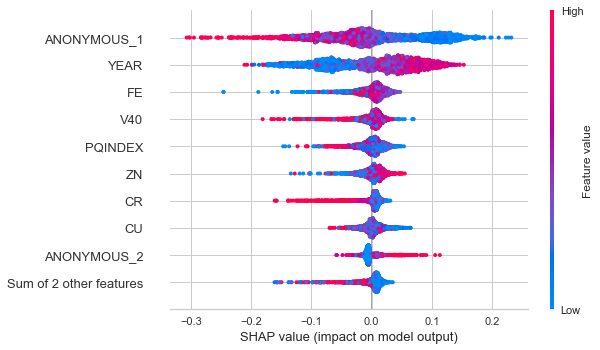

In [253]:
explainer_rf = shap.Explainer(clf_rf5)
shap_values_rf = explainer_rf(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [254]:
fi_rf = pd.DataFrame(clf_rf5.feature_importances_, index=X_train5.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.212791
V40                       0.119091
YEAR                      0.115506
PQINDEX                   0.105709
ZN                        0.101135
FE                        0.101103
CU                        0.080748
CR                        0.051443
MO                        0.049713
ANONYMOUS_2               0.036097
NI                        0.026665

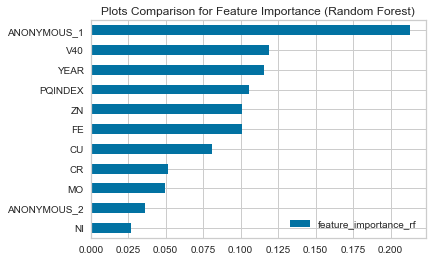

In [255]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [256]:
def objectiveXGB(trial, X, y):

    param = {
    'verbosity':1,
    'objective': trial.suggest_categorical('objective',['reg:squarederror']),
    'max_depth':trial.suggest_int('max_depth',3,13),  # 데이터 수가 적어 3~13으로 제한
    'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'subsample':trial.suggest_loguniform('subsample',0.7,1),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 300 ),
    'alpha': trial.suggest_loguniform( 'alpha', 1e-3, 10.0),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [257]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train5, y_train5), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-12 00:06:11,647] A new study created in memory with name: no-name-806802bd-1afa-4bcf-948d-650b642b0e54
[I 2022-12-12 00:06:13,580] Trial 0 finished with value: 0.41392012710217213 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.0036785337452728607, 'n_estimators': 59, 'subsample': 0.7891853414978656, 'min_child_weight': 4, 'alpha': 0.003760005916641011}. Best is trial 0 with value: 0.41392012710217213.
[I 2022-12-12 00:06:15,564] Trial 1 finished with value: 0.440908472820723 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 7.678091896429434e-05, 'n_estimators': 165, 'subsample': 0.9917839861695223, 'min_child_weight': 182, 'alpha': 0.537850110714538}. Best is trial 0 with value: 0.41392012710217213.
[I 2022-12-12 00:06:18,418] Trial 2 finished with value: 0.4418420959258539 and parameters: {'objective': 'reg:squarederror', 'max_depth': 5, 'learning_rate': 2.4551905420391076e-05, 'n_estimators': 230, 'su

[I 2022-12-12 00:08:08,397] Trial 23 finished with value: 0.3809025667532605 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.0013627790895611512, 'n_estimators': 498, 'subsample': 0.768384193865776, 'min_child_weight': 148, 'alpha': 9.818243551220348}. Best is trial 21 with value: 0.3012117050109603.
[I 2022-12-12 00:08:12,061] Trial 24 finished with value: 0.30714375837008717 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.009842692952978117, 'n_estimators': 439, 'subsample': 0.7315859221938363, 'min_child_weight': 299, 'alpha': 3.011667986262526}. Best is trial 21 with value: 0.3012117050109603.
[I 2022-12-12 00:08:19,650] Trial 25 finished with value: 0.4314527674808102 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.0001777337983842867, 'n_estimators': 466, 'subsample': 0.7782711419954389, 'min_child_weight': 32, 'alpha': 1.221315219078887}. Best is trial 21 with value: 

[I 2022-12-12 00:10:15,410] Trial 47 finished with value: 0.44260337668781313 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 2.4868100359118803e-07, 'n_estimators': 480, 'subsample': 0.7469298700443221, 'min_child_weight': 178, 'alpha': 0.7549294401374631}. Best is trial 21 with value: 0.3012117050109603.
[I 2022-12-12 00:10:24,171] Trial 48 finished with value: 0.3828159381469954 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.001309195641840561, 'n_estimators': 495, 'subsample': 0.7620826903959536, 'min_child_weight': 278, 'alpha': 7.153502201997997}. Best is trial 21 with value: 0.3012117050109603.
[I 2022-12-12 00:10:33,071] Trial 49 finished with value: 0.4200851721180216 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.00039095858538360564, 'n_estimators': 449, 'subsample': 0.8162924118053391, 'min_child_weight': 118, 'alpha': 0.1517155083456243}. Best is trial 21 with va

[I 2022-12-12 00:12:24,853] Trial 71 finished with value: 0.3093474379221487 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.007314121591130184, 'n_estimators': 454, 'subsample': 0.7002016498059934, 'min_child_weight': 282, 'alpha': 0.0030952414363990288}. Best is trial 21 with value: 0.3012117050109603.
[I 2022-12-12 00:12:29,866] Trial 72 finished with value: 0.30469001705032717 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.009929403189350792, 'n_estimators': 500, 'subsample': 0.7120084881126251, 'min_child_weight': 256, 'alpha': 0.012457377929580581}. Best is trial 21 with value: 0.3012117050109603.
[I 2022-12-12 00:12:35,432] Trial 73 finished with value: 0.33319504863151106 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.0034294086871726032, 'n_estimators': 479, 'subsample': 0.7096099778476752, 'min_child_weight': 271, 'alpha': 0.015560866281353261}. Best is trial 21 wi

[I 2022-12-12 00:15:04,078] Trial 95 finished with value: 0.3382478534033419 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.006390348228869535, 'n_estimators': 196, 'subsample': 0.7651067499178213, 'min_child_weight': 30, 'alpha': 0.10312138731886379}. Best is trial 90 with value: 0.29998776217765444.
[I 2022-12-12 00:15:09,878] Trial 96 finished with value: 0.33585600120866776 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.0033464376755629878, 'n_estimators': 386, 'subsample': 0.7485727022880394, 'min_child_weight': 18, 'alpha': 0.04241635143919956}. Best is trial 90 with value: 0.29998776217765444.
[I 2022-12-12 00:15:17,139] Trial 97 finished with value: 0.3430520124616306 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.002489488754278369, 'n_estimators': 464, 'subsample': 0.7360720206753597, 'min_child_weight': 48, 'alpha': 0.07393204870549859}. Best is trial 90 with val

study.best_params: 0.29998776217765444
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.0063214904676759205, 'n_estimators': 482, 'subsample': 0.739308767534685, 'min_child_weight': 10, 'alpha': 0.0830163519193724}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.0063214904676759205, 'n_estimators': 482, 'subsample': 0.739308767534685, 'min_child_weight': 10, 'alpha': 0.0830163519193724}


In [258]:
param_xgb = studyXGB.best_params

clf_xgb5 = xgb.XGBRegressor(**param_xgb, random_state=42)

In [259]:
clf_xgb5.fit(X_train5, y_train5.Score_0)

pred_test_xgb = clf_xgb5.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2318
F1 Score : 0.2256
Macro F1 Score : 0.5732 

[[2355  193]
 [ 212   59]]


In [260]:
optuna.visualization.plot_param_importances(studyXGB)

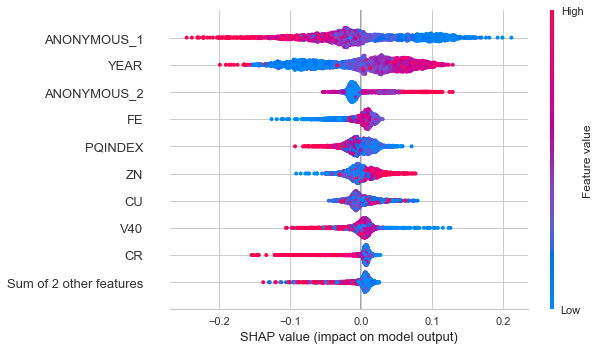

In [261]:
explainer_xgb = shap.Explainer(clf_xgb5)
shap_values_xgb = explainer_xgb(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [262]:
fi_xgb = pd.DataFrame(clf_xgb5.feature_importances_, index=X_train5.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
YEAR                       0.130680
NI                         0.108985
ANONYMOUS_1                0.106772
CR                         0.100717
ANONYMOUS_2                0.089802
PQINDEX                    0.082769
V40                        0.080030
CU                         0.078077
FE                         0.075562
ZN                         0.074024
MO                         0.072580

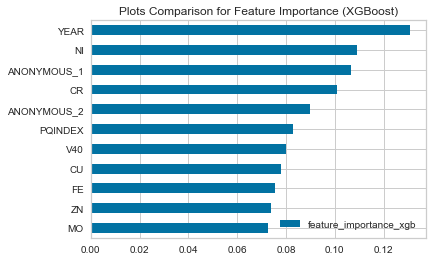

In [263]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
# plt.legend([])  # 범례 없애기
plt.show()

### LGBM

In [264]:
def objectiveLGBM(trial, X, y):

    param = {
        'metric': 'mae', 
        'random_state': 42,
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
#         'max_depth':trial.suggest_int('max_depth',3,30),
        'num_leaves' : trial.suggest_categorical('num_leaves', [8,16,32,64,128,256,512,1024]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [265]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train5, y_train5), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-12 00:15:42,085] A new study created in memory with name: no-name-36a0fdb9-d279-4d5b-bc80-1b3ddebe08d2
[I 2022-12-12 00:15:42,514] Trial 0 finished with value: 0.32704867094662177 and parameters: {'n_estimators': 157, 'reg_alpha': 0.5653504410373005, 'reg_lambda': 0.13232763499336983, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 1.7724450024261916e-06, 'num_leaves': 512, 'min_child_samples': 292, 'min_data_per_groups': 29}. Best is trial 0 with value: 0.32704867094662177.
[I 2022-12-12 00:15:42,985] Trial 1 finished with value: 0.3251594320223132 and parameters: {'n_estimators': 101, 'reg_alpha': 0.016836059651021685, 'reg_lambda': 0.01150314645645706, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.0023680936108636695, 'num_leaves': 64, 'min_child_samples': 247, 'min_data_per_groups': 92}. Best is trial 1 with value: 0.3251594320223132.
[I 2022-12-12 00:15:43,907] Trial 2 finished with value: 0.3270538499978256 and parameters: {'n_estimators': 1

[I 2022-12-12 00:16:22,864] Trial 21 finished with value: 0.2989407640730942 and parameters: {'n_estimators': 498, 'reg_alpha': 3.762644300691349, 'reg_lambda': 2.166780377396754, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.00824304516696853, 'num_leaves': 256, 'min_child_samples': 84, 'min_data_per_groups': 6}. Best is trial 10 with value: 0.29664423095176284.
[I 2022-12-12 00:16:27,536] Trial 22 finished with value: 0.3151188526319349 and parameters: {'n_estimators': 500, 'reg_alpha': 3.178798555487513, 'reg_lambda': 1.204042670363708, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0012800445709427214, 'num_leaves': 256, 'min_child_samples': 45, 'min_data_per_groups': 8}. Best is trial 10 with value: 0.29664423095176284.
[I 2022-12-12 00:16:29,700] Trial 23 finished with value: 0.3255986025136688 and parameters: {'n_estimators': 451, 'reg_alpha': 4.021462965688755, 'reg_lambda': 0.35071676607176044, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning

[I 2022-12-12 00:17:34,594] Trial 42 finished with value: 0.2991867669522827 and parameters: {'n_estimators': 476, 'reg_alpha': 0.037394743111752005, 'reg_lambda': 4.526444890648075, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009067687244698693, 'num_leaves': 512, 'min_child_samples': 218, 'min_data_per_groups': 68}. Best is trial 10 with value: 0.29664423095176284.
[I 2022-12-12 00:17:36,131] Trial 43 finished with value: 0.2993345759794832 and parameters: {'n_estimators': 486, 'reg_alpha': 0.02924577718367617, 'reg_lambda': 3.313681561918456, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009023207868612191, 'num_leaves': 512, 'min_child_samples': 232, 'min_data_per_groups': 74}. Best is trial 10 with value: 0.29664423095176284.
[I 2022-12-12 00:17:37,327] Trial 44 finished with value: 0.3124218771302964 and parameters: {'n_estimators': 499, 'reg_alpha': 0.0022074019560451145, 'reg_lambda': 3.7003888075475677, 'colsample_bytree': 1.0, 'subsample': 1.

[I 2022-12-12 00:18:04,020] Trial 63 finished with value: 0.3270537774650667 and parameters: {'n_estimators': 457, 'reg_alpha': 0.021132833816353135, 'reg_lambda': 4.050010826868167, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 1.103956514369515e-08, 'num_leaves': 512, 'min_child_samples': 75, 'min_data_per_groups': 88}. Best is trial 61 with value: 0.29575537240356786.
[I 2022-12-12 00:18:07,802] Trial 64 finished with value: 0.2969479910999367 and parameters: {'n_estimators': 489, 'reg_alpha': 0.07235191935733065, 'reg_lambda': 2.4522128273825032, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.005790519789870702, 'num_leaves': 256, 'min_child_samples': 60, 'min_data_per_groups': 84}. Best is trial 61 with value: 0.29575537240356786.
[I 2022-12-12 00:18:11,274] Trial 65 finished with value: 0.3050456892144264 and parameters: {'n_estimators': 489, 'reg_alpha': 0.002776713267667773, 'reg_lambda': 2.5471756558223286, 'colsample_bytree': 0.5, 'subsample': 0.8

[I 2022-12-12 00:22:22,135] Trial 84 finished with value: 0.29991909009075224 and parameters: {'n_estimators': 391, 'reg_alpha': 0.002169036717848861, 'reg_lambda': 7.796858490113904, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.004648096911910001, 'num_leaves': 256, 'min_child_samples': 21, 'min_data_per_groups': 91}. Best is trial 81 with value: 0.28789936047593423.
[I 2022-12-12 00:22:43,311] Trial 85 finished with value: 0.31844106966646163 and parameters: {'n_estimators': 360, 'reg_alpha': 0.0013030316278844504, 'reg_lambda': 5.111130364073124, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.0010446472051518557, 'num_leaves': 256, 'min_child_samples': 6, 'min_data_per_groups': 95}. Best is trial 81 with value: 0.28789936047593423.
[I 2022-12-12 00:22:51,508] Trial 86 finished with value: 0.3095914496934029 and parameters: {'n_estimators': 409, 'reg_alpha': 0.0011960333545596982, 'reg_lambda': 3.4426047709597585, 'colsample_bytree': 1.0, 'subsample': 

study.best_params: 0.28789936047593423
Number of finished trials: 100
Best trial: {'n_estimators': 414, 'reg_alpha': 0.0012276193806936226, 'reg_lambda': 7.476356050477609, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.007022241882737302, 'num_leaves': 256, 'min_child_samples': 3, 'min_data_per_groups': 92}
study.best_params: {'n_estimators': 414, 'reg_alpha': 0.0012276193806936226, 'reg_lambda': 7.476356050477609, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.007022241882737302, 'num_leaves': 256, 'min_child_samples': 3, 'min_data_per_groups': 92}


In [266]:
param_lgbm = studyLGBM.best_params

clf_lgbm5 = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [267]:
clf_lgbm5.fit(X_train5, y_train5.Score_0)

pred_test_lgbm = clf_lgbm5.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.2135
F1 Score : 0.2274
Macro F1 Score : 0.5679 

[[2289  184]
 [ 278   68]]


In [268]:
optuna.visualization.plot_param_importances(studyLGBM)

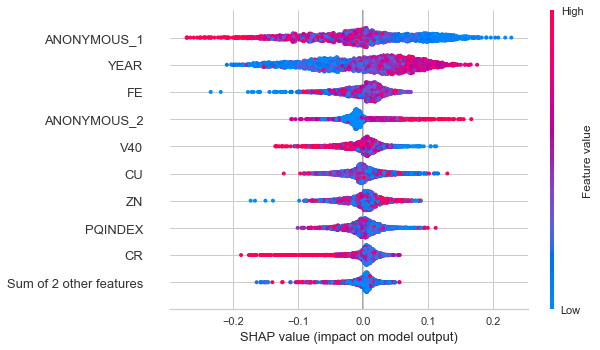

In [269]:
explainer_lgbm = shap.Explainer(clf_lgbm5)
shap_values_lgbm = explainer_lgbm(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [270]:
fi_lgbm = pd.DataFrame(clf_lgbm5.feature_importances_, index=X_train5.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                    17345
V40                            14962
ZN                             14530
FE                             13084
PQINDEX                        11737
CU                             10599
YEAR                            7174
MO                              6655
CR                              4358
ANONYMOUS_2                     3811
NI                              1315

In [271]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.164299
V40                         0.141726
ZN                          0.137634
FE                          0.123937
PQINDEX                     0.111177
CU                          0.100398
YEAR                        0.067955
MO                          0.063039
CR                          0.041281
ANONYMOUS_2                 0.036099
NI                          0.012456

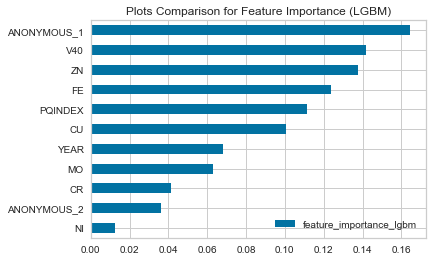

In [272]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [273]:
def objectiveCB(trial, X, y):
    
    param = {
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'max_depth':trial.suggest_int('max_depth',3,13),
        'random_state': 42,
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = CatBoostRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=25, verbose=False)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [274]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train5, y_train5), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-12 00:25:59,996] A new study created in memory with name: no-name-c528b86a-2e2e-44a5-8c30-5d64b6bb6cb3
[I 2022-12-12 00:26:03,698] Trial 0 finished with value: 0.31035527048940176 and parameters: {'l2_leaf_reg': 0.013443018209023265, 'max_bin': 203, 'learning_rate': 0.007081660798270803, 'n_estimators': 166, 'max_depth': 6, 'min_data_in_leaf': 175}. Best is trial 0 with value: 0.31035527048940176.
[I 2022-12-12 00:26:10,413] Trial 1 finished with value: 0.2985253674618575 and parameters: {'l2_leaf_reg': 0.003348432222714264, 'max_bin': 215, 'learning_rate': 0.014093459871934185, 'n_estimators': 313, 'max_depth': 6, 'min_data_in_leaf': 298}. Best is trial 1 with value: 0.2985253674618575.
[I 2022-12-12 00:26:12,306] Trial 2 finished with value: 0.3094042793610308 and parameters: {'l2_leaf_reg': 0.08264429091318642, 'max_bin': 318, 'learning_rate': 0.015223163219220764, 'n_estimators': 92, 'max_depth': 5, 'min_data_in_leaf': 218}. Best is trial 1 with value: 0.2985253674618575

[I 2022-12-12 00:38:10,564] Trial 26 finished with value: 0.29572523507793763 and parameters: {'l2_leaf_reg': 0.0018000183255051756, 'max_bin': 365, 'learning_rate': 0.017987336338881662, 'n_estimators': 450, 'max_depth': 6, 'min_data_in_leaf': 246}. Best is trial 26 with value: 0.29572523507793763.
[I 2022-12-12 00:38:16,763] Trial 27 finished with value: 0.2963190988905369 and parameters: {'l2_leaf_reg': 0.008928076520587639, 'max_bin': 396, 'learning_rate': 0.017702582479426864, 'n_estimators': 448, 'max_depth': 5, 'min_data_in_leaf': 260}. Best is trial 26 with value: 0.29572523507793763.
[I 2022-12-12 00:38:23,396] Trial 28 finished with value: 0.29730001845212184 and parameters: {'l2_leaf_reg': 0.0017004549100349705, 'max_bin': 375, 'learning_rate': 0.01708527869509606, 'n_estimators': 429, 'max_depth': 5, 'min_data_in_leaf': 200}. Best is trial 26 with value: 0.29572523507793763.
[I 2022-12-12 00:38:30,620] Trial 29 finished with value: 0.29628899240041673 and parameters: {'l2_l

[I 2022-12-12 00:41:15,584] Trial 53 finished with value: 0.2964365465827335 and parameters: {'l2_leaf_reg': 0.0015201428060057317, 'max_bin': 269, 'learning_rate': 0.014882135219458336, 'n_estimators': 385, 'max_depth': 7, 'min_data_in_leaf': 266}. Best is trial 41 with value: 0.29518637140849846.
[I 2022-12-12 00:44:33,235] Trial 54 finished with value: 0.30161959943845684 and parameters: {'l2_leaf_reg': 0.002902304397340935, 'max_bin': 354, 'learning_rate': 0.01799432094120602, 'n_estimators': 455, 'max_depth': 13, 'min_data_in_leaf': 238}. Best is trial 41 with value: 0.29518637140849846.
[I 2022-12-12 00:44:59,909] Trial 55 finished with value: 0.2968150975634218 and parameters: {'l2_leaf_reg': 0.0026509131090640715, 'max_bin': 381, 'learning_rate': 0.016092839756245154, 'n_estimators': 302, 'max_depth': 9, 'min_data_in_leaf': 222}. Best is trial 41 with value: 0.29518637140849846.
[I 2022-12-12 00:45:09,711] Trial 56 finished with value: 0.29742489045142834 and parameters: {'l2_l

[I 2022-12-12 00:50:47,320] Trial 80 finished with value: 0.29712979157852165 and parameters: {'l2_leaf_reg': 0.304446741091528, 'max_bin': 391, 'learning_rate': 0.014503004812661563, 'n_estimators': 445, 'max_depth': 8, 'min_data_in_leaf': 134}. Best is trial 41 with value: 0.29518637140849846.
[I 2022-12-12 00:51:04,034] Trial 81 finished with value: 0.29704080941944755 and parameters: {'l2_leaf_reg': 1.244581636525583, 'max_bin': 270, 'learning_rate': 0.017672946018025895, 'n_estimators': 430, 'max_depth': 9, 'min_data_in_leaf': 128}. Best is trial 41 with value: 0.29518637140849846.
[I 2022-12-12 00:51:12,339] Trial 82 finished with value: 0.29578517299036544 and parameters: {'l2_leaf_reg': 2.5838725155359774, 'max_bin': 288, 'learning_rate': 0.01638944601023397, 'n_estimators': 397, 'max_depth': 7, 'min_data_in_leaf': 154}. Best is trial 41 with value: 0.29518637140849846.
[I 2022-12-12 00:51:20,709] Trial 83 finished with value: 0.2958137110614586 and parameters: {'l2_leaf_reg': 

study.best_params: 0.29518637140849846
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.011543104983589516, 'max_bin': 399, 'learning_rate': 0.01786071214146499, 'n_estimators': 474, 'max_depth': 5, 'min_data_in_leaf': 265}
study.best_params: {'l2_leaf_reg': 0.011543104983589516, 'max_bin': 399, 'learning_rate': 0.01786071214146499, 'n_estimators': 474, 'max_depth': 5, 'min_data_in_leaf': 265}


In [275]:
param_cat = studyCB.best_params

clf_cat5 = CatBoostRegressor(**param_cat, random_state=42)

In [276]:
clf_cat5.fit(X_train5, y_train5.Score_0)

pred_test_cat = clf_cat5.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3808176	total: 3.08ms	remaining: 1.46s
1:	learn: 0.3802242	total: 5.33ms	remaining: 1.26s
2:	learn: 0.3797216	total: 7.34ms	remaining: 1.15s
3:	learn: 0.3792467	total: 9.41ms	remaining: 1.1s
4:	learn: 0.3787495	total: 11.6ms	remaining: 1.09s
5:	learn: 0.3782594	total: 13.8ms	remaining: 1.07s
6:	learn: 0.3778174	total: 16ms	remaining: 1.07s
7:	learn: 0.3772935	total: 18.9ms	remaining: 1.1s
8:	learn: 0.3768078	total: 21.2ms	remaining: 1.09s
9:	learn: 0.3763215	total: 23.4ms	remaining: 1.08s
10:	learn: 0.3758057	total: 25.9ms	remaining: 1.09s
11:	learn: 0.3754115	total: 28.4ms	remaining: 1.09s
12:	learn: 0.3749892	total: 30.4ms	remaining: 1.08s
13:	learn: 0.3745743	total: 33.2ms	remaining: 1.09s
14:	learn: 0.3741865	total: 35.6ms	remaining: 1.09s
15:	learn: 0.3737800	total: 37.8ms	remaining: 1.08s
16:	learn: 0.3734049	total: 40.9ms	remaining: 1.1s
17:	learn: 0.3730795	total: 43.4ms	remaining: 1.1s
18:	learn: 0.3727301	total: 46.1ms	remaining: 1.1s
19:	learn: 0.3723646	total: 4

211:	learn: 0.3481080	total: 461ms	remaining: 570ms
212:	learn: 0.3480434	total: 463ms	remaining: 568ms
213:	learn: 0.3479534	total: 465ms	remaining: 565ms
214:	learn: 0.3478726	total: 467ms	remaining: 563ms
215:	learn: 0.3477806	total: 470ms	remaining: 561ms
216:	learn: 0.3477374	total: 473ms	remaining: 560ms
217:	learn: 0.3477035	total: 475ms	remaining: 558ms
218:	learn: 0.3476481	total: 477ms	remaining: 556ms
219:	learn: 0.3475701	total: 479ms	remaining: 553ms
220:	learn: 0.3475047	total: 482ms	remaining: 551ms
221:	learn: 0.3474233	total: 484ms	remaining: 549ms
222:	learn: 0.3473387	total: 486ms	remaining: 547ms
223:	learn: 0.3472562	total: 489ms	remaining: 545ms
224:	learn: 0.3471613	total: 491ms	remaining: 543ms
225:	learn: 0.3471276	total: 493ms	remaining: 541ms
226:	learn: 0.3471003	total: 495ms	remaining: 539ms
227:	learn: 0.3470442	total: 497ms	remaining: 537ms
228:	learn: 0.3469385	total: 500ms	remaining: 535ms
229:	learn: 0.3468899	total: 502ms	remaining: 532ms
230:	learn: 

370:	learn: 0.3391687	total: 802ms	remaining: 223ms
371:	learn: 0.3390956	total: 804ms	remaining: 220ms
372:	learn: 0.3390522	total: 805ms	remaining: 218ms
373:	learn: 0.3389875	total: 808ms	remaining: 216ms
374:	learn: 0.3389491	total: 810ms	remaining: 214ms
375:	learn: 0.3388784	total: 812ms	remaining: 212ms
376:	learn: 0.3388347	total: 814ms	remaining: 209ms
377:	learn: 0.3387710	total: 816ms	remaining: 207ms
378:	learn: 0.3386800	total: 818ms	remaining: 205ms
379:	learn: 0.3386419	total: 819ms	remaining: 203ms
380:	learn: 0.3386013	total: 821ms	remaining: 200ms
381:	learn: 0.3385252	total: 823ms	remaining: 198ms
382:	learn: 0.3384847	total: 825ms	remaining: 196ms
383:	learn: 0.3384495	total: 827ms	remaining: 194ms
384:	learn: 0.3383825	total: 829ms	remaining: 192ms
385:	learn: 0.3382998	total: 831ms	remaining: 189ms
386:	learn: 0.3382895	total: 832ms	remaining: 187ms
387:	learn: 0.3382217	total: 834ms	remaining: 185ms
388:	learn: 0.3381401	total: 835ms	remaining: 183ms
389:	learn: 

In [277]:
optuna.visualization.plot_param_importances(studyCB)

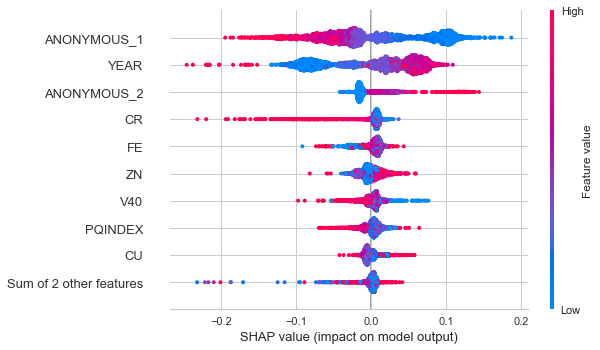

In [278]:
explainer_cat = shap.Explainer(clf_cat5)
shap_values_cat = explainer_cat(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [279]:
fi_cat = pd.DataFrame(clf_cat5.feature_importances_, index=X_train5.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
YEAR                      22.356265
ANONYMOUS_1               21.536397
ANONYMOUS_2                8.709822
CR                         7.437055
V40                        7.034211
FE                         7.018618
ZN                         6.987603
PQINDEX                    6.951008
CU                         5.611770
MO                         3.896149
NI                         2.461102

In [280]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
YEAR                       0.223563
ANONYMOUS_1                0.215364
ANONYMOUS_2                0.087098
CR                         0.074371
V40                        0.070342
FE                         0.070186
ZN                         0.069876
PQINDEX                    0.069510
CU                         0.056118
MO                         0.038961
NI                         0.024611

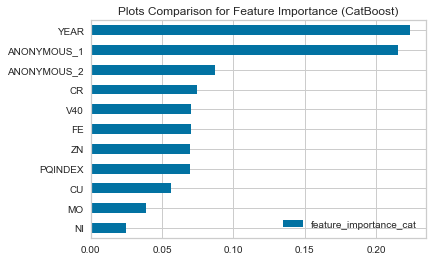

In [281]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [282]:
def objectiveET(trial, X, y):
    
    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'random_state': 42}
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y.Label)):  # Stratify K Fold 실행
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.loc[train_idx,'Score_0'], y.loc[test_idx,'Score_0']

        #학습모델 생성
        model = ExtraTreesRegressor(**param)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, pred)
    
    return np.mean(cv_scores)

In [283]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train5, y_train5), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-12 00:53:42,872] A new study created in memory with name: no-name-24cf638f-f92c-450e-97bc-5809e817a6d2
[I 2022-12-12 00:53:43,534] Trial 0 finished with value: 0.2963729710922203 and parameters: {'max_depth': 8, 'max_leaf_nodes': 263, 'n_estimators': 56}. Best is trial 0 with value: 0.2963729710922203.
[I 2022-12-12 00:53:51,599] Trial 1 finished with value: 0.2935905087936942 and parameters: {'max_depth': 11, 'max_leaf_nodes': 918, 'n_estimators': 461}. Best is trial 1 with value: 0.2935905087936942.
[I 2022-12-12 00:53:55,187] Trial 2 finished with value: 0.29325737459300466 and parameters: {'max_depth': 12, 'max_leaf_nodes': 875, 'n_estimators': 188}. Best is trial 2 with value: 0.29325737459300466.
[I 2022-12-12 00:53:55,975] Trial 3 finished with value: 0.2981789495903875 and parameters: {'max_depth': 7, 'max_leaf_nodes': 563, 'n_estimators': 79}. Best is trial 2 with value: 0.29325737459300466.
[I 2022-12-12 00:53:57,565] Trial 4 finished with value: 0.2934467120910912

[I 2022-12-12 00:55:53,057] Trial 38 finished with value: 0.29300377294951707 and parameters: {'max_depth': 13, 'max_leaf_nodes': 299, 'n_estimators': 80}. Best is trial 12 with value: 0.2925329210642969.
[I 2022-12-12 00:55:55,965] Trial 39 finished with value: 0.2954621315606517 and parameters: {'max_depth': 9, 'max_leaf_nodes': 133, 'n_estimators': 245}. Best is trial 12 with value: 0.2925329210642969.
[I 2022-12-12 00:55:58,682] Trial 40 finished with value: 0.29279731153429667 and parameters: {'max_depth': 12, 'max_leaf_nodes': 539, 'n_estimators': 126}. Best is trial 12 with value: 0.2925329210642969.
[I 2022-12-12 00:56:01,741] Trial 41 finished with value: 0.2927980281845975 and parameters: {'max_depth': 12, 'max_leaf_nodes': 796, 'n_estimators': 126}. Best is trial 12 with value: 0.2925329210642969.
[I 2022-12-12 00:56:04,053] Trial 42 finished with value: 0.29357247218376525 and parameters: {'max_depth': 13, 'max_leaf_nodes': 864, 'n_estimators': 107}. Best is trial 12 with v

[I 2022-12-12 00:58:09,811] Trial 76 finished with value: 0.2930229548229213 and parameters: {'max_depth': 13, 'max_leaf_nodes': 253, 'n_estimators': 312}. Best is trial 12 with value: 0.2925329210642969.
[I 2022-12-12 00:58:19,753] Trial 77 finished with value: 0.293083274555587 and parameters: {'max_depth': 13, 'max_leaf_nodes': 378, 'n_estimators': 366}. Best is trial 12 with value: 0.2925329210642969.
[I 2022-12-12 00:58:28,603] Trial 78 finished with value: 0.29264074938171025 and parameters: {'max_depth': 13, 'max_leaf_nodes': 333, 'n_estimators': 319}. Best is trial 12 with value: 0.2925329210642969.
[I 2022-12-12 00:58:35,835] Trial 79 finished with value: 0.292688326953804 and parameters: {'max_depth': 13, 'max_leaf_nodes': 336, 'n_estimators': 327}. Best is trial 12 with value: 0.2925329210642969.
[I 2022-12-12 00:58:46,148] Trial 80 finished with value: 0.29271606138208284 and parameters: {'max_depth': 13, 'max_leaf_nodes': 326, 'n_estimators': 324}. Best is trial 12 with va

study.best_params: 0.2925329210642969
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 318, 'n_estimators': 168}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 318, 'n_estimators': 168}


In [284]:
param_et = studyET.best_params

clf_et5 = ExtraTreesRegressor(**param_et, random_state=42)

In [285]:
clf_et5.fit(X_train5, y_train5.Score_0)

pred_test_et = clf_et5.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.2215
F1 Score : 0.2451
Macro F1 Score : 0.5847 

[[2368  189]
 [ 199   63]]


In [286]:
optuna.visualization.plot_param_importances(studyET)

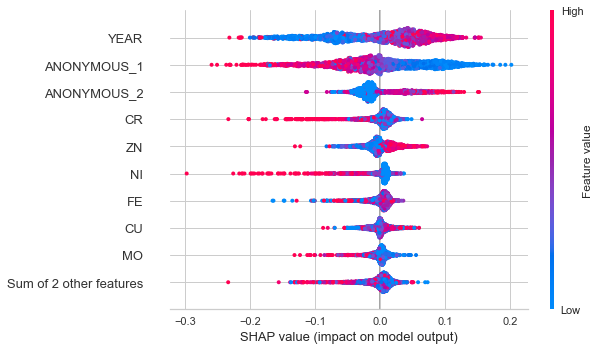

In [287]:
explainer_et = shap.Explainer(clf_et5)
shap_values_et = explainer_et(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [288]:
fi_et = pd.DataFrame(clf_et5.feature_importances_, index=X_train5.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.179216
YEAR                      0.156418
CR                        0.082848
CU                        0.082820
FE                        0.082322
ZN                        0.077263
PQINDEX                   0.075460
V40                       0.074841
MO                        0.068324
ANONYMOUS_2               0.063452
NI                        0.057035

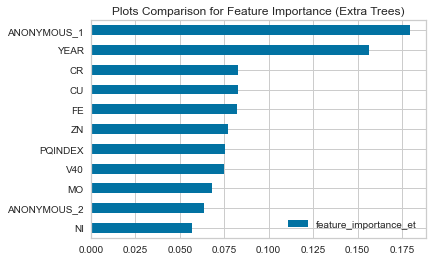

In [289]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Stacking
### mean

In [306]:
pred_test_et1 = clf_et1.predict(X_test)
pred_test_rf2 = clf_rf2.predict(X_test)
pred_test_rf3 = clf_rf3.predict(X_test)
pred_test_cat4 = clf_cat4.predict(X_test)
pred_test_et5 = clf_et5.predict(X_test)

In [318]:
pred_test_stack = 0.2*pred_test_et1 + 0.2*pred_test_rf2 + 0.2*pred_test_rf3 + 0.2*pred_test_cat4 + 0.2*pred_test_et5

y_test['pred_mean'] = [labeling(pred, threshold=0.6) for pred in pred_test_stack]

print('MAE :', round(mean_absolute_error(pred_test_stack, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_mean, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_mean, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_mean, y_test.Y_LABEL))

MAE : 0.2183
F1 Score : 0.2619
Macro F1 Score : 0.5861 

[[2288  172]
 [ 279   80]]


## Submission

In [309]:
# Stacking Median
pred_test_real_et1 = clf_et1.predict(real_test)
pred_test_real_rf2 = clf_rf2.predict(real_test)
pred_test_real_rf3 = clf_rf3.predict(real_test)
pred_test_real_cat4 = clf_cat4.predict(real_test)
pred_test_real_et5 = clf_et5.predict(real_test)

# # 모델의 median으로 stacking
# pred_test_real_median = pd.DataFrame({'et1' : pred_test_real_cat1, 
#                                       'cat2' : pred_test_real_et2, 
#                                       'et3' : pred_test_real_et3, 
#                                       'cat4' : pred_test_real_et4,
#                                       'et5' : pred_test_real_lgbm5}).median(axis=1).values

# # pred_test_real = [labeling(pred, threshold=0.6) for pred in pred_test_real_median]

# # pred_test_real = 0.2*pred_test_real_xgb + 0.2*pred_test_real_rf + 0.2*pred_test_real_lgbm + 0.2*pred_test_real_cat + 0.2*pred_test_real_et

# # real_pred = [labeling(pred, threshold=0.6) for pred in pred_test_real]

In [322]:
# Stacking Mean
pred_test_real = 0.2*pred_test_real_et1 + 0.2*pred_test_real_rf2 + 0.2*pred_test_real_rf3 + 0.2*pred_test_real_cat4 + 0.2*pred_test_real_et5

pred_test_real = [labeling(pred, threshold=0.6) for pred in pred_test_real]

In [323]:
submit = pd.read_csv('C:/Users/cdbre/Desktop/MyLife/DACON/data/sample_submission.csv')
submit['Y_LABEL'] = pred_test_real
submit.head()

ID  Y_LABEL
0  TEST_0000        0
1  TEST_0001        0
2  TEST_0002        0
3  TEST_0003        0
4  TEST_0004        1

In [324]:
submit.Y_LABEL.value_counts()  # 이상 비율 : 0.08756828339678861

0    5512
1     529
Name: Y_LABEL, dtype: int64

In [315]:
submit.to_csv('C:/Users/cdbre/Desktop/MyLife/DACON/data/submit_same_kfold.csv', index=False)  # 0.5778971727